#### **Install Libraries**

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 16.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **Imports Libraries**

In [ ]:
# Imports Libraries
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time
import optuna
from functools import partial

# Enhanced imports for new techniques
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, InceptionV3, Xception, MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

#### **Define Paths & Data Loading**

In [ ]:
# Define paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath   label
0  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
1  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
2  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
3  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL
4  /content/drive/MyDrive/chest_xray/train/NORMAL...  NORMAL

The shape of The Train data is: (5233, 2)
The shape of The Test data is: (625, 2)


### **Data Preparation**

In [ ]:
# Data Preparation
# Count files
def retrieveNumberOfFiles(path):
    normal_count = len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')])
    pneumonia_count = len([f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])
    return normal_count + pneumonia_count

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Get class weights
allTrainFiles = [os.path.join(TRAIN_PATH, "NORMAL", f) for f in os.listdir(os.path.join(TRAIN_PATH, "NORMAL"))] + \
                [os.path.join(TRAIN_PATH, "PNEUMONIA", f) for f in os.listdir(os.path.join(TRAIN_PATH, "PNEUMONIA"))]

trainLabels = [0 if "NORMAL" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# data generators with augmentation and validation split
BATCH_SIZE = 32
INIT_LR = 0.001
EPOCHS = 15

def create_generators(preprocess_func, target_size):
    # Create main generator with validation split
    main_generator = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2  # 20% validation split
    )

    # Train generator (80% of data)
    trainGen = main_generator.flow_from_directory(
        TRAIN_PATH,
        class_mode="categorical",
        target_size=target_size,
        color_mode="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        subset='training',
        seed=123
    )

    # Validation generator (20% of data)
    validationGen = main_generator.flow_from_directory(
        TRAIN_PATH,
        class_mode="categorical",
        target_size=target_size,
        color_mode="rgb",
        shuffle=False,
        batch_size=BATCH_SIZE,
        subset='validation',
        seed=123
    )

    # Test generator (separate directory)
    testGen = ImageDataGenerator(preprocessing_function=preprocess_func).flow_from_directory(
        TEST_PATH,
        class_mode="categorical",
        target_size=target_size,
        color_mode="rgb",
        shuffle=False,
        batch_size=BATCH_SIZE
    )

    # Calculate actual counts
    train_count = trainGen.samples
    val_count = validationGen.samples
    test_count = testGen.samples

    print(f"Data counts: Train={train_count}, Val={val_count}, Test={test_count}")

    return trainGen, validationGen, testGen, train_count, val_count

# -----------------------------------------------------#
# Explicitly create and assign testGen after calling the function
# We need to call create_generators with appropriate args.
if 'model_configs' in locals():

    first_model_config = model_configs[0]
    trainGen, validationGen, testGen, train_count, val_count = create_generators(
        first_model_config['preprocess_func'],
        first_model_config['target_size']
    )
else:
    print("Error: 'model_configs' not found. Cannot create data generators. Please run Cell E.")

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data counts: Train=4187, Val=1045, Test=624


### **Model Creation**

In [ ]:
# Model Creation
# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fn

# Enhanced model creation with Monte Carlo Dropout
def create_resnet50_model(input_shape=(224, 224, 3), classes=2):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_densenet121_model(input_shape=(224, 224, 3), classes=2):
    base_model = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_inceptionv3_model(input_shape=(299, 299, 3), classes=2):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_xception_model(input_shape=(299, 299, 3), classes=2):
    base_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_mobilenetv2_model(input_shape=(224, 224, 3), classes=2):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-15]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
# Cell E: Model Configurations
model_configs = [
    {
        'name': 'ResNet18',
        'create_func': create_resnet50_model,
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': resnet_preprocess
    },
    {
        'name': 'DenseNet121',
        'create_func': create_densenet121_model,
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': densenet_preprocess
    },
    {
        'name': 'InceptionV3',
        'create_func': create_inceptionv3_model,
        'input_shape': (299, 299, 3),
        'target_size': (299, 299),
        'preprocess_func': inception_preprocess
    },
    {
        'name': 'Xception',
        'create_func': create_xception_model,
        'input_shape': (299, 299, 3),
        'target_size': (299, 299),
        'preprocess_func': xception_preprocess
    },
    {
        'name': 'MobileNetV2',
        'create_func': create_mobilenetv2_model,
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': mobilenet_preprocess
    }
]

In [ ]:
# Model Parameter Counts
model_creators = {
    'ResNet50': create_resnet50_model,
    'DenseNet121': create_densenet121_model,
    'InceptionV3': create_inceptionv3_model,
    'Xception': create_xception_model,
    'MobileNetV2': create_mobilenetv2_model
}

for name, build_fn in model_creators.items():
    # instantiate with default input_shape and classes
    model = build_fn()

    total_params = model.count_params()
    trainable_params = sum(
        K.count_params(w) for w in model.trainable_weights
    )
    non_trainable_params = sum(
        K.count_params(w) for w in model.non_trainable_weights
    )

    print(f"{name}:")
    print(f"  Total params         : {total_params:,}")
    print(f"  Trainable params     : {trainable_params:,}")
    print(f"  Non-trainable params : {non_trainable_params:,}\n")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
ResNet50:
  Total params         : 24,112,770
  Trainable params     : 9,456,386
  Non-trainable params : 14,656,384

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
DenseNet121:
  Total params         : 7,300,418
  Trainable params     : 904,322
  Non-trainable params : 6,396,096

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
InceptionV3:
  Total params         : 22,327,842
  Trainable params     : 5,681,090
  Non-trainable params : 16,646,752

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Xception:
  Total params         : 21,386,538
  Trainable params     : 9,465,410
  Non-trainable params : 11,921,128

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2:
  Total params         : 2,586,434
  Trainable params     : 1,368,450
  Non-trainable params : 1,217,984



### **Training with Loss Curves**

Training individual models...

Training ResNet18...
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data counts: Train=4187, Val=1045, Test=624
Steps per epoch: 131, Validation steps: 33
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8450 - loss: 2.0766

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.07575, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/ResNet18_weights-001-0.0758.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 917s 7s/step - accuracy: 0.8452 - loss: 2.0680 - val_accuracy: 0.9321 - val_loss: 0.0758 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9331 - loss: 0.0626
Epoch 2: val_loss improved from 0.07575 to 0.02000, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/ResNet18_weights-002-0.0200.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 886ms/step - accuracy: 0.9331 - loss: 0.0625 - val_accuracy: 0.9502 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9257 - loss: 0.0275
Epoch 3: val_loss did not improve from 0.02000
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 891ms/step - accuracy: 0.9258 - loss: 0.0275 - val_accuracy: 0.9148 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6

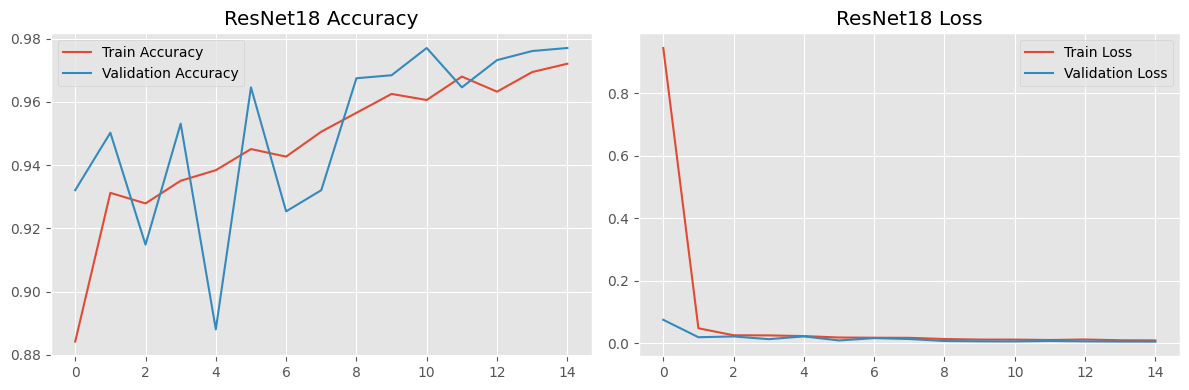

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ResNet18 - Test Accuracy: 93.75%, Test Loss: 0.0131

Training DenseNet121...
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data counts: Train=4187, Val=1045, Test=624
Steps per epoch: 131, Validation steps: 33
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.8073 - loss: 2.1920

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.30582, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/DenseNet121_weights-001-0.3058.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8077 - loss: 2.1847 - val_accuracy: 0.9455 - val_loss: 0.3058 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9162 - loss: 0.2309
Epoch 2: val_loss improved from 0.30582 to 0.07064, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/DenseNet121_weights-002-0.0706.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 913ms/step - accuracy: 0.9162 - loss: 0.2305 - val_accuracy: 0.9512 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9283 - loss: 0.0640
Epoch 3: val_loss improved from 0.07064 to 0.02901, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/DenseNet121_weights-003-0.0290.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 910ms/step - accuracy: 0.9283 - loss: 0.0

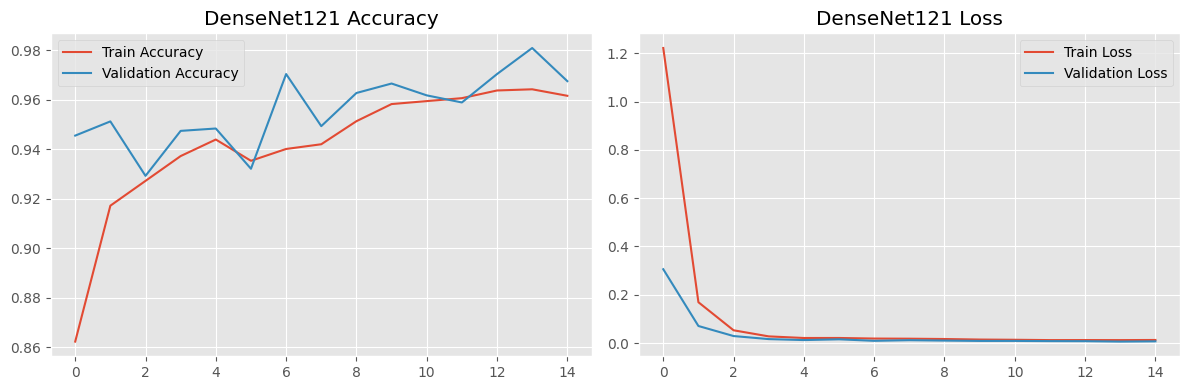

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


DenseNet121 - Test Accuracy: 90.87%, Test Loss: 0.0151

Training InceptionV3...
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data counts: Train=4187, Val=1045, Test=624
Steps per epoch: 131, Validation steps: 33
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8607 - loss: 2.0758

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.05140, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/InceptionV3_weights-001-0.0514.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8609 - loss: 2.0671 - val_accuracy: 0.9244 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.9079 - loss: 0.0441
Epoch 2: val_loss improved from 0.05140 to 0.01516, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/InceptionV3_weights-002-0.0152.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9080 - loss: 0.0440 - val_accuracy: 0.9340 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.9326 - loss: 0.0217
Epoch 3: val_loss did not improve from 0.01516
131/131 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9326 - loss: 0.0217 - val_accuracy: 0.9378 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 9

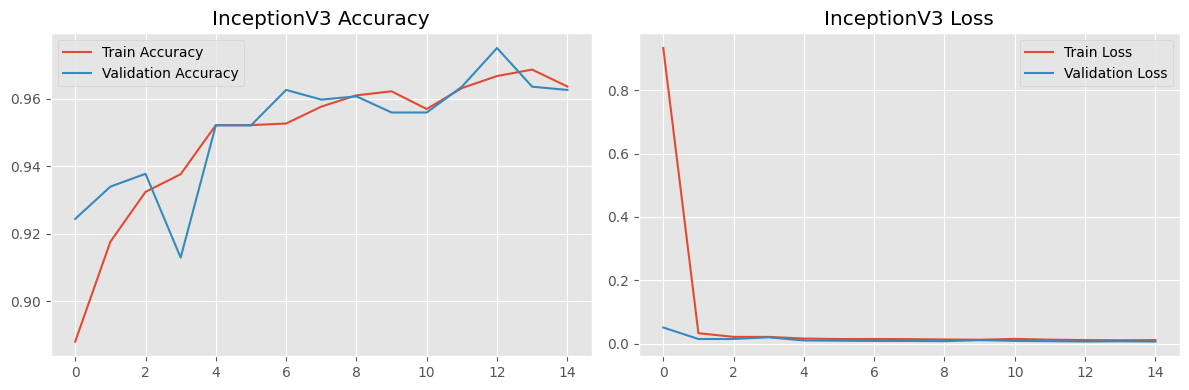

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


InceptionV3 - Test Accuracy: 93.59%, Test Loss: 0.0131

Training Xception...
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data counts: Train=4187, Val=1045, Test=624
Steps per epoch: 131, Validation steps: 33
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8212 - loss: 1.6542

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.01941, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/Xception_weights-001-0.0194.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.8217 - loss: 1.6463 - val_accuracy: 0.9139 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.9271 - loss: 0.0247
Epoch 2: val_loss improved from 0.01941 to 0.01390, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/Xception_weights-002-0.0139.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9271 - loss: 0.0246 - val_accuracy: 0.9531 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9387 - loss: 0.0218
Epoch 3: val_loss improved from 0.01390 to 0.01163, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/Xception_weights-003-0.0116.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9388 - loss: 0.0218 - val_accuracy

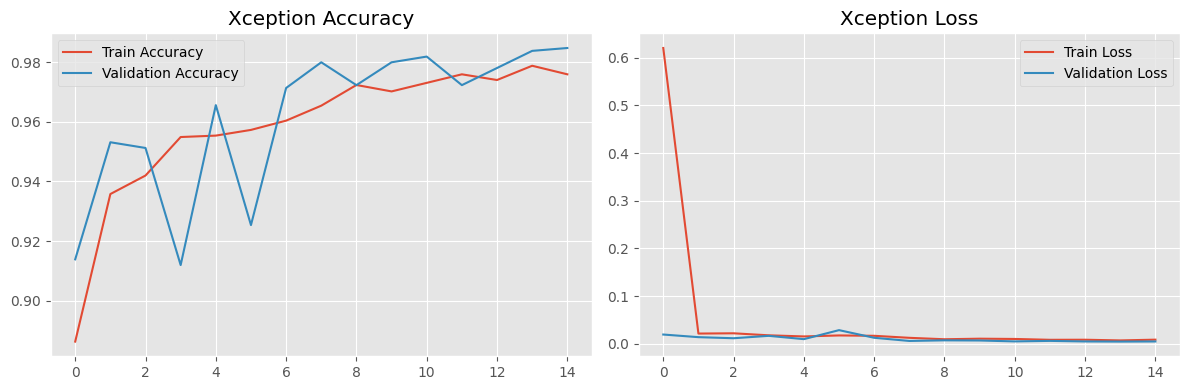

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Xception - Test Accuracy: 96.96%, Test Loss: 0.0081

Training MobileNetV2...
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Data counts: Train=4187, Val=1045, Test=624
Steps per epoch: 131, Validation steps: 33
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8154 - loss: 2.0304
Epoch 1: val_loss improved from inf to 0.95084, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/MobileNetV2_weights-001-0.9508.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 135s 935ms/step - accuracy: 0.8157 - loss: 2.0222 - val_accuracy: 0.7426 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9176 - loss: 0.0455
Epoch 2: val_loss improved from 0.95084 to 0.70438, saving model to /content/drive/MyDrive/chest_xray/ensemble_models/MobileNetV2_weights-002-0.7044.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 8

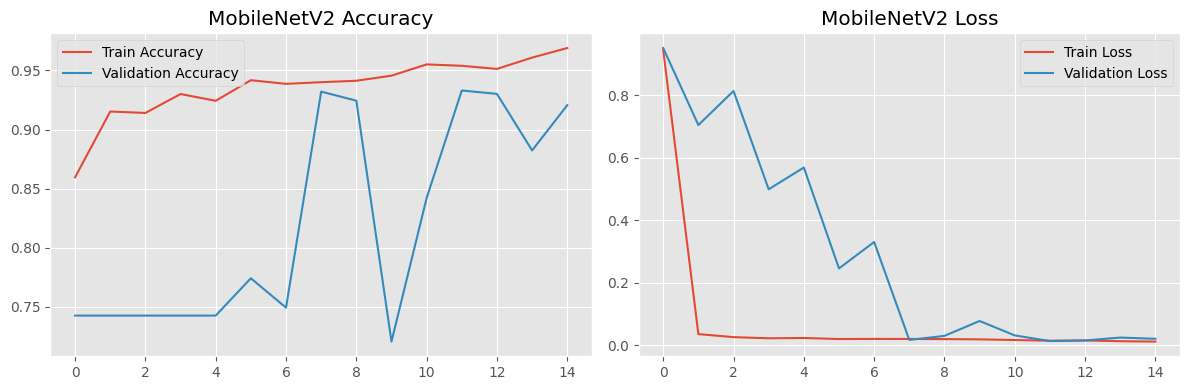

MobileNetV2 - Test Accuracy: 91.83%, Test Loss: 0.0227


In [ ]:
# Cell F: Training with Loss Curves
trained_models = []
model_predictions = []
model_performances = []
model_histories = []

print("Training individual models...")
for i, config in enumerate(model_configs):
    print(f"\nTraining {config['name']}...")

    # Create data generators with proper split
    trainGen, validationGen, testGen, train_count, val_count = create_generators(
        config['preprocess_func'],
        config['target_size']
    )

    # Calculate steps per epoch
    steps_per_epoch = train_count // BATCH_SIZE
    validation_steps = val_count // BATCH_SIZE

    # For last partial batch
    if train_count % BATCH_SIZE != 0:
        steps_per_epoch += 1
    if val_count % BATCH_SIZE != 0:
        validation_steps += 1

    print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

    model = config['create_func'](config['input_shape'], classes=2)

    # Use Focal Loss
    opt = Adam(learning_rate=INIT_LR, weight_decay=0.0001)
    model.compile(loss=focal_loss(gamma=2.0, alpha=0.25), optimizer=opt, metrics=["accuracy"])

    os.makedirs("/content/drive/MyDrive/chest_xray/ensemble_models", exist_ok=True)
    MCName = os.path.sep.join(["/content/drive/MyDrive/chest_xray/ensemble_models",
                               f"{config['name']}_weights-{{epoch:03d}}-{{val_loss:.4f}}.keras"])

    # Callbacks
    checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
    tensorboard = TensorBoard(log_dir=f'./logs/{config["name"]}', histogram_freq=1)

    callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

    start_time = time.time()
    history = model.fit(
        x=trainGen,
        steps_per_epoch=steps_per_epoch,
        validation_data=validationGen,
        validation_steps=validation_steps,
        class_weight=classWeight,
        callbacks=callbacks,
        epochs=EPOCHS,
        verbose=1)

    training_time = (time.time() - start_time) / 60
    print(f"{config['name']} training completed in {training_time:.2f} minutes")
    model_histories.append(history)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{config["name"]} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{config["name"]} Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/chest_xray/{config['name']}_training_history.png")
    plt.show()

    # Evaluate model
    test_results = model.evaluate(testGen, verbose=0)
    print(f"{config['name']} - Test Accuracy: {test_results[1]*100:.2f}%, Test Loss: {test_results[0]:.4f}")

    # Get predictions for ensemble
    testGen.reset()  # Reset generator for consistent ordering
    predIdxs = model.predict(testGen, verbose=0)

    trained_models.append(model)
    model_predictions.append(predIdxs)
    model_performances.append(test_results[1])

    tf.keras.backend.clear_session()

### **Load Saved Individual Model Weights**

In [ ]:
# Load Saved Individual Model Weights

print("Loading saved individual model weights...")

loaded_trained_models = []

if 'model_configs' in locals():
    for config in model_configs:
        model_name = config['name']
        print(f"Attempting to load weights for {model_name}...")

        ensemble_models_dir = "/content/drive/MyDrive/chest_xray/ensemble_models"
        saved_weights_files = [f for f in os.listdir(ensemble_models_dir) if f.startswith(model_name) and f.endswith('.keras')]

        if saved_weights_files:
            # Sort files by modification time (assuming latest is best)
            saved_weights_files.sort(key=lambda x: os.path.getmtime(os.path.join(ensemble_models_dir, x)))
            best_weights_filename = saved_weights_files[-1]
            best_weights_path = os.path.join(ensemble_models_dir, best_weights_filename)
            print(f"Found latest weights at: {best_weights_path}")

            try:
                model = config['create_func'](config['input_shape'], classes=2)
                model.load_weights(best_weights_path)
                loaded_trained_models.append(model)
                print(f"Loaded weights for {model_name}.")
            except Exception as e:
                print(f"Error loading weights for {model_name} from {best_weights_path}: {e}")
                loaded_trained_models.append(None)
        else:
            print(f"No saved weights found for {model_name}.")
            loaded_trained_models.append(None)

    trained_models = loaded_trained_models
    print("\nIndividual model weights loading process completed.")
    print(f"Number of models loaded successfully: {len([m for m in trained_models if m is not None])}/{len(model_configs)}")

else:
    print("'model_configs' not found. Please run Cell E first.")

Loading saved individual model weights...
Attempting to load weights for ResNet18...
Found latest weights at: /content/drive/MyDrive/chest_xray/ensemble_models/ResNet18_weights-015-0.0060.keras
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Loaded weights for ResNet18.
Attempting to load weights for DenseNet121...
Found latest weights at: /content/drive/MyDrive/chest_xray/ensemble_models/DenseNet121_weights-014-0.0060.keras
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Loaded weights for DenseNet121.
Attempting to load weights for InceptionV3...
Found latest weights at: /content/drive/MyDrive/chest_xray/ensemble_models/InceptionV3_weights-015-0.0070.keras
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Loaded weights for InceptionV3.
Attempting to load weights for Xception...
Found latest weights at: /content/drive/MyDrive/chest_xray/ensemble_models/Xception_weights-014-0.0046.keras
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Loaded weights for Xception.
Attempting t

### **Neural Meta-Learner Implementation**

In [ ]:
#  Neural Meta-Learner Implementation
print("\nBuilding Neural Meta-Learner for ensemble weighting...")

# Prepare meta-learner training data from validation set
meta_features = []
meta_labels = []

# Use validation set to train meta-learner
for batch_data, batch_labels in validationGen:
    if len(meta_labels) >= 1000:  # Limit to 1000 samples
        break

    batch_predictions = []
    for j, model in enumerate(trained_models):
        config = model_configs[j]
        resized_batch = tf.image.resize(batch_data, config['target_size'])
        resized_batch = config['preprocess_func'](resized_batch)
        pred = model.predict(resized_batch, verbose=0)
        batch_predictions.append(pred)

    # Stack predictions from all models
    stacked_preds = np.stack(batch_predictions, axis=1)
    meta_features.append(stacked_preds)
    meta_labels.append(batch_labels)

meta_features = np.vstack(meta_features)
meta_labels = np.vstack(meta_labels)

# Build neural meta-learner
input_layer = Input(shape=(len(trained_models), 2))
x = Flatten()(input_layer)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation='softmax')(x)

meta_model = Model(inputs=input_layer, outputs=output_layer)
meta_model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train meta-learner
meta_model.fit(
    meta_features,
    meta_labels,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Building Neural Meta-Learner for ensemble weighting...


Epoch 1/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9250 - loss: 0.1854 - val_accuracy: 0.9749 - val_loss: 0.0690
Epoch 2/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9734 - loss: 0.0717 - val_accuracy: 0.9754 - val_loss: 0.0664
Epoch 3/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9703 - loss: 0.0764 - val_accuracy: 0.9757 - val_loss: 0.0659
Epoch 4/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9754 - loss: 0.0675 - val_accuracy: 0.9749 - val_loss: 0.0659
Epoch 5/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9701 - loss: 0.0762 - val_accuracy: 0.9749 - val_loss: 0.0655
Epoch 6/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9734 - loss: 0.0702 - val_accuracy: 0.9752 - val_loss: 0.0657
Epoch 7/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9708 - loss: 0.0728 - val_accuracy: 0.9763 - val_loss: 0.0660
Epoch 8/15
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9741 - loss: 0.0690 - val_accuracy: 0.

### **Optuna Optimisation for Final Ensemble Weighting**

In [ ]:
# Optuna Hyperparameter Optimization for Final Ensemble
print("\nRunning Optuna optimization for final ensemble weighting...")

# Create optimization dataset
opt_samples = 0
target_opt_samples = 400
optimization_features = []
optimization_labels = []

for batch_data, batch_labels in testGen:
    if opt_samples >= target_opt_samples:
        break

    batch_predictions = []
    for j, model in enumerate(trained_models):
        config = model_configs[j]
        resized_batch = tf.image.resize(batch_data, config['target_size'])
        resized_batch = config['preprocess_func'](resized_batch)
        pred = model.predict(resized_batch, verbose=0)
        batch_predictions.append(pred)

    stacked_preds = np.stack(batch_predictions, axis=1)
    optimization_features.append(stacked_preds)
    optimization_labels.append(batch_labels)
    opt_samples += len(batch_data)

optimization_features = np.vstack(optimization_features)
optimization_labels = np.vstack(optimization_labels)

# Optuna objective function
def objective(trial, features, labels):
    # Suggest weights for each model
    weights = []
    for i in range(len(trained_models)):
        weights.append(trial.suggest_float(f'weight_{i}', 0, 1))

    # Normalize weights
    weights = np.array(weights)
    weights /= weights.sum()

    # Calculate weighted ensemble predictions
    weighted_preds = np.zeros_like(features[:, 0, :])
    for i in range(len(trained_models)):
        weighted_preds += weights[i] * features[:, i, :]

    # Calculate accuracy
    pred_labels = np.argmax(weighted_preds, axis=1)
    true_labels = np.argmax(labels, axis=1)
    accuracy = np.mean(pred_labels == true_labels)
    return accuracy

# Optimize with Optuna
study = optuna.create_study(direction='maximize')
objective_partial = partial(objective, features=optimization_features, labels=optimization_labels)
study.optimize(objective_partial, n_trials=100, timeout=3600)

# Get optimal weights
optimal_weights = [study.best_params[f'weight_{i}'] for i in range(len(trained_models))]
optimal_weights = np.array(optimal_weights)
optimal_weights /= optimal_weights.sum()

print("Optimal weights from Optuna:")
for i, (config, weight) in enumerate(zip(model_configs, optimal_weights)):
    print(f"{config['name']}: {weight:.4f}")


Running Optuna optimization for final ensemble weighting...


[I 2025-06-18 13:28:50,841] A new study created in memory with name: no-name-1f2f911b-1510-41ae-965a-5938835d7272
[I 2025-06-18 13:28:50,844] Trial 0 finished with value: 0.9278846153846154 and parameters: {'weight_0': 0.3701834508844526, 'weight_1': 0.7754905089924494, 'weight_2': 0.8259942130536972, 'weight_3': 0.566464540265591, 'weight_4': 0.30009054145275205}. Best is trial 0 with value: 0.9278846153846154.
[I 2025-06-18 13:28:50,845] Trial 1 finished with value: 0.9206730769230769 and parameters: {'weight_0': 0.4268885438460881, 'weight_1': 0.7704299981808348, 'weight_2': 0.5581623824257277, 'weight_3': 0.6896364377412182, 'weight_4': 0.5885245204779127}. Best is trial 0 with value: 0.9278846153846154.
[I 2025-06-18 13:28:50,847] Trial 2 finished with value: 0.9014423076923077 and parameters: {'weight_0': 0.13963621860586173, 'weight_1': 0.3048899743036586, 'weight_2': 0.4124707015371216, 'weight_3': 0.8533215677921155, 'weight_4': 0.33785682117102167}. Best is trial 0 with value

Optimal weights from Optuna:
ResNet18: 0.3599
DenseNet121: 0.3283
InceptionV3: 0.0086
Xception: 0.3000
MobileNetV2: 0.0031


### **Evaluating Final Ensemble With Meta-Learning**

Loading saved ensemble components and evaluating...
Meta-learner model loaded successfully.
Optimal weights loaded successfully.
Evaluation will run for 20 batches.
Processing batch 1/20...
Processing batch 2/20...
Processing batch 3/20...
Processing batch 4/20...
Processing batch 5/20...
Processing batch 6/20...
Processing batch 7/20...
Processing batch 8/20...
Processing batch 9/20...
Processing batch 10/20...
Processing batch 11/20...
Processing batch 12/20...
Processing batch 13/20...
Processing batch 14/20...
Processing batch 15/20...
Processing batch 16/20...
Processing batch 17/20...
Processing batch 18/20...
Processing batch 19/20...
Processing batch 20/20...
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Nuclear Ensemble Evaluation (from saved components):
Test Accuracy: 96.79%
Test Loss: 0.1435
AUC Score: 0.9915

Classification Report (from saved components):
              precision    recall  f1-score   support

      NORMAL     0.9458    0.9701    0.9578       234
   PNEUMONIA   

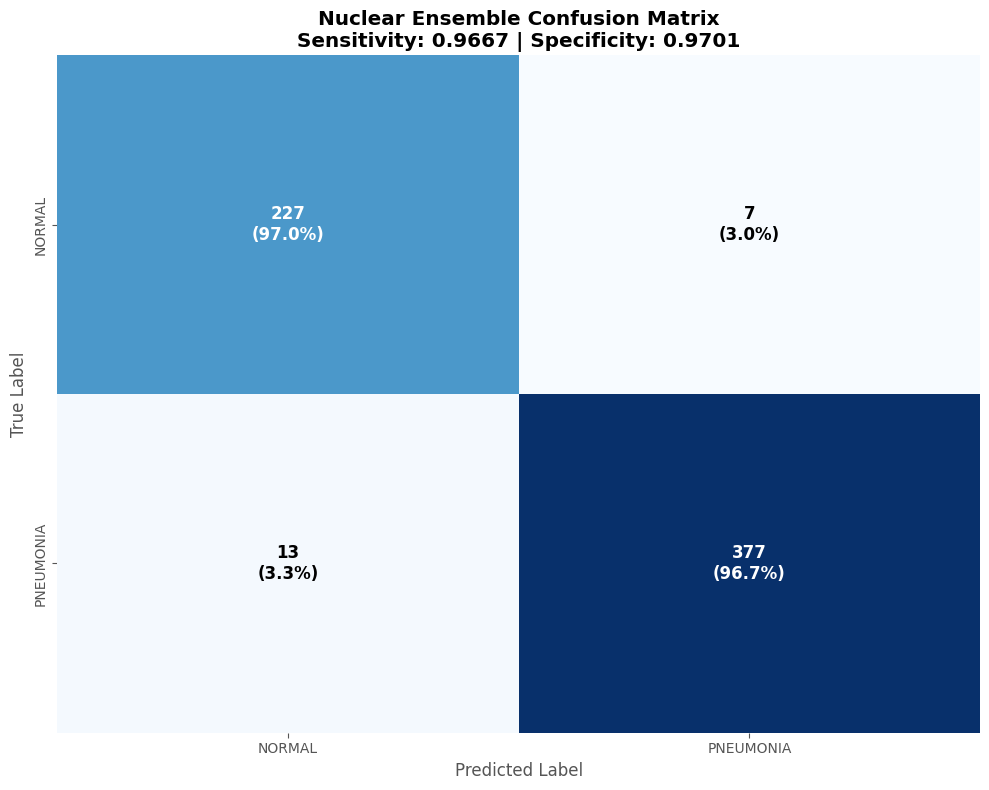

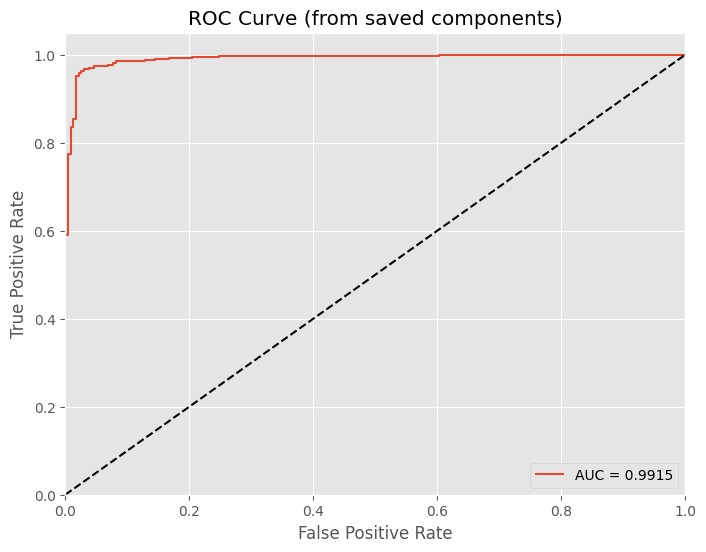


Nuclear Ensemble Final Performance:
Accuracy: 96.79%
Test Loss: 0.1435
AUC Score: 0.9915
Sensitivity (Recall for Pneumonia): 0.9667
Specificity: 0.9701
Precision for Pneumonia: 0.9818
F1-Score for Pneumonia: 0.9742


In [ ]:
# Evaluation from Saved Ensemble

# Import required metrics
from sklearn.metrics import precision_score, f1_score

print("Loading saved ensemble components and evaluating...")

meta_learner_path = "/content/drive/MyDrive/chest_xray/nuclear_ensemble_meta_learner.keras"
optimal_weights_path = "/content/drive/MyDrive/chest_xray/nuclear_ensemble_optimal_weights.npy"

try:
    loaded_meta_model = tf.keras.models.load_model(meta_learner_path)
    print("Meta-learner model loaded successfully.")
except Exception as e:
    print(f"Error loading meta-learner model: {e}")
    loaded_meta_model = None

try:
    loaded_optimal_weights = np.load(optimal_weights_path)
    print("Optimal weights loaded successfully.")
except Exception as e:
    print(f"Error loading optimal weights: {e}")
    loaded_optimal_weights = None

# Ensure individual trained models are available (either from current runtime or loaded)
if loaded_meta_model is not None and loaded_optimal_weights is not None and trained_models:
    all_meta_features_loaded = []
    all_test_predictions_loaded = []
    true_labels_loaded = []

    if 'testGen' not in locals():
         print("Warning: 'testGen' not found. Please ensure the data generators are created before running this cell.")
    else:
        testGen.reset()

        # Calculate test steps if not already defined
        if 'test_count' not in locals():
            # Recalculate test_count if it's not found
            def retrieveNumberOfFiles(path):
                normal_count = len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')])
                pneumonia_count = len([f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])
                return normal_count + pneumonia_count

            if 'TEST_PATH' in locals():
                test_count = retrieveNumberOfFiles(TEST_PATH)
                print(f"Calculated test_count: {test_count}")
            else:
                print("Error: 'TEST_PATH' not found. Cannot determine test steps.")
                test_count = None

        if test_count is not None:
            steps_test = test_count // BATCH_SIZE
            if test_count % BATCH_SIZE != 0:
                steps_test += 1
            print(f"Evaluation will run for {steps_test} batches.")

            batch_counter = 0
            # Iterate through the test generator
            for batch_data, batch_labels in testGen:
                if batch_counter >= steps_test:
                    break

                print(f"Processing batch {batch_counter + 1}/{steps_test}...")
                true_labels_loaded.extend(np.argmax(batch_labels, axis=1))

                batch_meta_features_loaded = []
                batch_model_predictions_loaded = []

                # Get predictions from each model
                for j, model in enumerate(trained_models):
                    if model is not None:
                        config = model_configs[j]
                        # Direct prediction without TTA
                        resized_batch = tf.image.resize(batch_data, config['target_size'])
                        preprocessed_batch = config['preprocess_func'](resized_batch)
                        pred = model.predict(preprocessed_batch, verbose=0)

                        batch_meta_features_loaded.append(pred)
                        batch_model_predictions_loaded.append(pred)
                    else:
                        print(f"Skipping predictions for model index {j} due to loading error.")
                        batch_meta_features_loaded.append(np.zeros((len(batch_data), 2)))
                        batch_model_predictions_loaded.append(np.zeros((len(batch_data), 2)))

                stacked_preds_loaded = np.stack(batch_meta_features_loaded, axis=1)
                all_meta_features_loaded.append(stacked_preds_loaded)

                weighted_pred_loaded = np.zeros_like(batch_model_predictions_loaded[0])
                for j, pred in enumerate(batch_model_predictions_loaded):
                    weighted_pred_loaded += loaded_optimal_weights[j] * pred
                all_test_predictions_loaded.append(weighted_pred_loaded)

                batch_counter += 1

            # Combine results
            if all_meta_features_loaded:
                all_meta_features_loaded = np.vstack(all_meta_features_loaded)
                all_test_predictions_loaded = np.vstack(all_test_predictions_loaded)
                true_labels_loaded = np.array(true_labels_loaded)

                # Get final predictions from meta-learner
                meta_predictions_loaded = loaded_meta_model.predict(all_meta_features_loaded)

                # Blend predictions
                final_predictions_loaded = 0.6 * meta_predictions_loaded + 0.4 * all_test_predictions_loaded
                predicted_labels_loaded = np.argmax(final_predictions_loaded, axis=1)

                # Calculate metrics
                final_accuracy_loaded = np.mean(predicted_labels_loaded == true_labels_loaded)
                # Calculate test loss
                test_loss = tf.keras.losses.sparse_categorical_crossentropy(true_labels_loaded, final_predictions_loaded)
                test_loss = np.mean(test_loss)
                auc_score_loaded = roc_auc_score(true_labels_loaded, final_predictions_loaded[:, 1])

                # Calculate pneumonia-specific metrics
                precision_pneumonia = precision_score(true_labels_loaded, predicted_labels_loaded, pos_label=1)
                f1_pneumonia = f1_score(true_labels_loaded, predicted_labels_loaded, pos_label=1)

                print(f"\nNuclear Ensemble Evaluation (from saved components):")
                print(f"Test Accuracy: {final_accuracy_loaded*100:.2f}%")
                print(f"Test Loss: {test_loss:.4f}")
                print(f"AUC Score: {auc_score_loaded:.4f}")

                print("\nClassification Report (from saved components):")
                class_names = ['NORMAL', 'PNEUMONIA']
                print(classification_report(true_labels_loaded, predicted_labels_loaded, target_names=class_names, digits=4))

                cm_loaded = confusion_matrix(true_labels_loaded, predicted_labels_loaded)
                total_loaded = sum(sum(cm_loaded))
                acc_loaded = (cm_loaded[0, 0] + cm_loaded[1, 1]) / total_loaded
                sensitivity_loaded = cm_loaded[1, 1] / (cm_loaded[1, 0] + cm_loaded[1, 1])
                specificity_loaded = cm_loaded[0, 0] / (cm_loaded[0, 0] + cm_loaded[0, 1])

                print("\nConfusion Matrix (from saved components):")
                print(cm_loaded)
                print("Accuracy: {:.4f}".format(acc_loaded))
                print("Sensitivity: {:.4f}".format(sensitivity_loaded))
                print("Specificity: {:.4f}".format(specificity_loaded))

                plt.figure(figsize=(10, 8))
                ax_loaded = sns.heatmap(cm_loaded, annot=False, fmt='d', cmap='Blues',
                                        xticklabels=class_names,
                                        yticklabels=class_names,
                                        cbar=False)

                # Custom annotations with improved formatting
                for i in range(cm_loaded.shape[0]):
                    for j in range(cm_loaded.shape[1]):
                        value = cm_loaded[i, j]
                        total_in_row = cm_loaded[i, :].sum()
                        percentage = value / total_in_row * 100 if total_in_row > 0 else 0

                        # Determine text color and weight
                        is_diagonal = (i == j)
                        text_color = 'white' if is_diagonal else 'black'
                        font_weight = 'bold'

                        # Format text with count and percentage in one line
                        text = f"{value}\n({percentage:.1f}%)"

                        # Position text in center of cell with proper spacing
                        ax_loaded.text(j + 0.5, i + 0.5, text,
                                horizontalalignment='center',
                                verticalalignment='center',
                                color=text_color,
                                fontsize=12,
                                fontweight=font_weight,
                                linespacing=1.2)

                plt.title(f"Nuclear Ensemble Confusion Matrix\nSensitivity: {sensitivity_loaded:.4f} | Specificity: {specificity_loaded:.4f}", weight= 'bold' )
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.tight_layout()
                plt.show()

                fpr_loaded, tpr_loaded, thresholds_loaded = roc_curve(true_labels_loaded, final_predictions_loaded[:, 1])
                plt.figure(figsize=(8, 6))
                plt.plot(fpr_loaded, tpr_loaded, label=f'AUC = {auc_score_loaded:.4f}')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('ROC Curve (from saved components)')
                plt.legend(loc="lower right")
                plt.show()

                print("\nNuclear Ensemble Final Performance:")
                print(f"Accuracy: {final_accuracy_loaded*100:.2f}%")
                print(f"Test Loss: {test_loss:.4f}")
                print(f"AUC Score: {auc_score_loaded:.4f}")
                print(f"Sensitivity (Recall for Pneumonia): {sensitivity_loaded:.4f}")
                print(f"Specificity: {specificity_loaded:.4f}")
                print(f"Precision for Pneumonia: {precision_pneumonia:.4f}")
                print(f"F1-Score for Pneumonia: {f1_pneumonia:.4f}")

            else:
                print("No batches processed for evaluation.")

else:
    print("Could not perform evaluation. Ensure meta-learner, optimal weights, and individual models are available.")

## **Evaluation of Saved Models**

## **Ensemble Model Size**

In [ ]:
# Model Size Calculation for Ensemble
import os

def get_model_size(path):
    """Return file size in MB"""
    if os.path.exists(path):
        size_bytes = os.path.getsize(path)
        return size_bytes / (1024 * 1024)
    return 0

# Corrected paths to ensemble components
base_model_paths = [
    "/content/drive/MyDrive/chest_xray/base_model_0.keras",
    "/content/drive/MyDrive/chest_xray/base_model_1.keras",
    "/content/drive/MyDrive/chest_xray/base_model_2.keras",
    "/content/drive/MyDrive/chest_xray/base_model_3.keras",
    "/content/drive/MyDrive/chest_xray/base_model_4.keras"
]
meta_learner_path = "/content/drive/MyDrive/chest_xray/nuclear_ensemble_meta_learner.keras"
optimal_weights_path = "/content/drive/MyDrive/chest_xray/Nuclear_ensemble_optimal_weights.npy"

# Calculate sizes
base_model_sizes = [get_model_size(path) for path in base_model_paths]
meta_learner_size = get_model_size(meta_learner_path)
optimal_weights_size = get_model_size(optimal_weights_path)

# Total size calculation
total_size = sum(base_model_sizes) + meta_learner_size + optimal_weights_size

print("\nEnsemble Model Size Analysis:")
for i, size in enumerate(base_model_sizes):
    print(f"Base model {i} size: {size:.2f} MB")
print(f"Meta-learner size: {meta_learner_size:.2f} MB")
print(f"Optimal weights size: {optimal_weights_size:.5f} MB")
print(f"Total ensemble size: {total_size:.5f} MB")


Ensemble Model Size Analysis:
Base model 0 size: 92.61 MB
Base model 1 size: 29.29 MB
Base model 2 size: 86.22 MB
Base model 3 size: 82.06 MB
Base model 4 size: 10.42 MB
Meta-learner size: 0.15 MB
Optimal weights size: 0.00016 MB
Total ensemble size: 300.74107 MB


## **Ensemble Prediction Visualisation**

Base model 0 (ResNet18) loaded successfully
Base model 1 (DenseNet121) loaded successfully
Base model 2 (InceptionV3) loaded successfully
Base model 3 (Xception) loaded successfully
Base model 4 (MobileNetV2) loaded successfully
Meta-learner model loaded successfully
Optimal weights loaded successfully

Running predictions on test images...


100%|██████████| 624/624 [10:11<00:00,  1.02it/s]



Visualizing predictions...


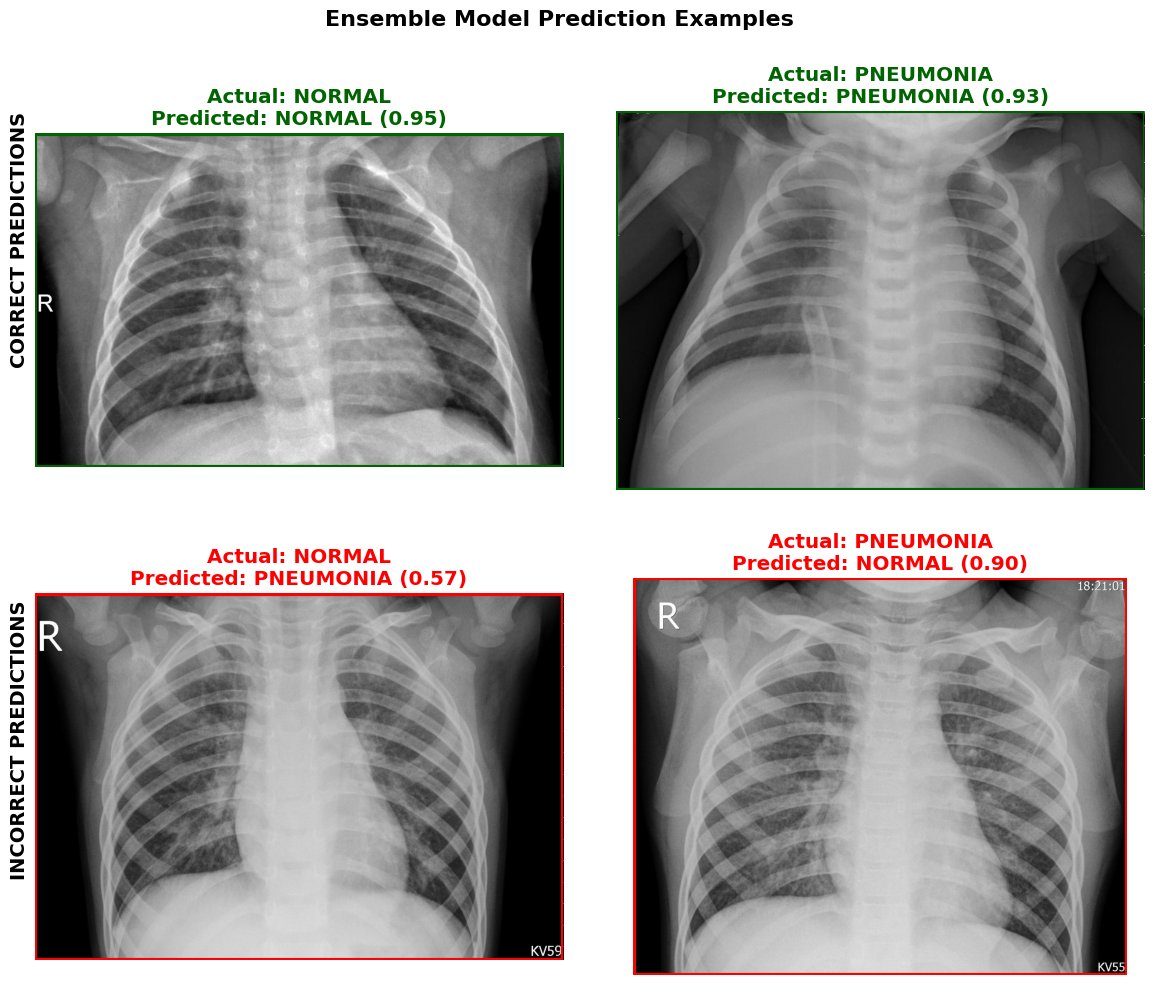

In [ ]:
# Ensemble Prediction Visualization (Handles Different Input Sizes)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.patches as patches
from tqdm import tqdm

# Define paths and parameters
TEST_PATH = "/content/drive/MyDrive/chest_xray/test"
BATCH_SIZE = 32

# Define model configurations with proper preprocessing
model_configs = [
    {
        'name': 'ResNet18',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.resnet.preprocess_input
    },
    {
        'name': 'DenseNet121',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.densenet.preprocess_input
    },
    {
        'name': 'InceptionV3',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.inception_v3.preprocess_input
    },
    {
        'name': 'Xception',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.xception.preprocess_input
    },
    {
        'name': 'MobileNetV2',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input
    }
]

# Load ensemble components
base_models = []
for i, path in enumerate([
    "/content/drive/MyDrive/chest_xray/base_model_0.keras",
    "/content/drive/MyDrive/chest_xray/base_model_1.keras",
    "/content/drive/MyDrive/chest_xray/base_model_2.keras",
    "/content/drive/MyDrive/chest_xray/base_model_3.keras",
    "/content/drive/MyDrive/chest_xray/base_model_4.keras"
]):
    try:
        model = tf.keras.models.load_model(path)
        base_models.append(model)
        print(f"Base model {i} ({model_configs[i]['name']}) loaded successfully")
    except Exception as e:
        print(f"Error loading base model {i}: {e}")
        base_models.append(None)

try:
    meta_model = tf.keras.models.load_model("/content/drive/MyDrive/chest_xray/nuclear_ensemble_meta_learner.keras")
    print("Meta-learner model loaded successfully")
except Exception as e:
    print(f"Error loading meta-learner model: {e}")
    meta_model = None

try:
    optimal_weights = np.load("/content/drive/MyDrive/chest_xray/Nuclear_ensemble_optimal_weights.npy")
    print("Optimal weights loaded successfully")
except Exception as e:
    print(f"Error loading optimal weights: {e}")
    optimal_weights = None

# Get test image paths
def get_image_paths():
    normal_path = os.path.join(TEST_PATH, "NORMAL")
    pneumonia_path = os.path.join(TEST_PATH, "PNEUMONIA")

    normal_images = [os.path.join(normal_path, f) for f in os.listdir(normal_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    pneumonia_images = [os.path.join(pneumonia_path, f) for f in os.listdir(pneumonia_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    return normal_images, pneumonia_images

normal_images, pneumonia_images = get_image_paths()
all_images = normal_images + pneumonia_images
all_labels = [0] * len(normal_images) + [1] * len(pneumonia_images)

# Predict function for a single image (handles different input sizes)
def predict_single_image(img_path):
    # Get predictions from base models
    base_preds = []

    for i, (model, config) in enumerate(zip(base_models, model_configs)):
        if model is None:
            # If model failed to load, use zeros
            base_preds.append(np.zeros((1, 2)))
            continue

        # Load and preprocess image for this specific model
        img = tf.keras.utils.load_img(img_path, target_size=config['target_size'])
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = config['preprocess_func'](img_array)

        # Get prediction
        pred = model.predict(img_array, verbose=0)
        base_preds.append(pred)

    # Stack predictions for meta-learner
    stacked_preds = np.stack(base_preds, axis=1)

    # Get meta-learner prediction
    if meta_model is not None:
        meta_pred = meta_model.predict(stacked_preds, verbose=0)
    else:
        # If meta-model failed to load, use average
        meta_pred = np.mean(stacked_preds, axis=1)

    # Weighted ensemble prediction
    weighted_pred = np.zeros_like(base_preds[0])
    for i, pred in enumerate(base_preds):
        if optimal_weights is not None and i < len(optimal_weights):
            weighted_pred += optimal_weights[i] * pred
        else:
            # If weights not available, use equal weighting
            weighted_pred += (1/len(base_preds)) * pred

    # Blend predictions
    final_pred = 0.6 * meta_pred + 0.4 * weighted_pred
    predicted_class = np.argmax(final_pred, axis=1)[0]
    confidence = np.max(final_pred)

    return predicted_class, confidence

# Run predictions on all images
results = []
print("\nRunning predictions on test images...")
for img_path, actual_label in tqdm(zip(all_images, all_labels), total=len(all_images)):
    predicted_class, confidence = predict_single_image(img_path)
    correct = (predicted_class == actual_label)
    results.append({
        'path': img_path,
        'actual_label': "NORMAL" if actual_label == 0 else "PNEUMONIA",
        'predicted_label': "NORMAL" if predicted_class == 0 else "PNEUMONIA",
        'confidence': confidence,
        'correct': correct
    })

# Categorize results
correct_normal = [r for r in results if r['actual_label'] == "NORMAL" and r['correct']]
wrong_normal = [r for r in results if r['actual_label'] == "NORMAL" and not r['correct']]
correct_pneumonia = [r for r in results if r['actual_label'] == "PNEUMONIA" and r['correct']]
wrong_pneumonia = [r for r in results if r['actual_label'] == "PNEUMONIA" and not r['correct']]

# Visualization function
def visualize_predictions():
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Set titles
    fig.suptitle("Ensemble Model Prediction Examples", fontsize=16, fontweight='bold', y=0.98)
    fig.text(0.05, 0.75, 'CORRECT PREDICTIONS', va='center', ha='center',
             rotation='vertical', fontsize=14, weight='bold')
    fig.text(0.05, 0.25, 'INCORRECT PREDICTIONS', va='center', ha='center',
             rotation='vertical', fontsize=14, weight='bold')

    # Plot Correct Normal
    if correct_normal:
        img_data = random.choice(correct_normal)
        img = tf.keras.utils.load_img(img_data['path'])
        axes[0, 0].imshow(img)
        axes[0, 0].set_title(f"Actual: NORMAL\nPredicted: NORMAL ({img_data['confidence']:.2f})",
                             color='darkgreen', fontweight='bold')
        axes[0, 0].axis('off')
        rect = patches.Rectangle((0, 0), img.width, img.height, linewidth=3,
                                edgecolor='darkgreen', facecolor='none')
        axes[0, 0].add_patch(rect)
    else:
        axes[0, 0].text(0.5, 0.5, "No Correct Normal\nPredictions",
                        ha='center', va='center', fontsize=12)
        axes[0, 0].axis('off')

    # Plot Correct Pneumonia
    if correct_pneumonia:
        img_data = random.choice(correct_pneumonia)
        img = tf.keras.utils.load_img(img_data['path'])
        axes[0, 1].imshow(img)
        axes[0, 1].set_title(f"Actual: PNEUMONIA\nPredicted: PNEUMONIA ({img_data['confidence']:.2f})",
                             color='darkgreen', fontweight='bold')
        axes[0, 1].axis('off')
        rect = patches.Rectangle((0, 0), img.width, img.height, linewidth=3,
                                edgecolor='darkgreen', facecolor='none')
        axes[0, 1].add_patch(rect)
    else:
        axes[0, 1].text(0.5, 0.5, "No Correct Pneumonia\nPredictions",
                        ha='center', va='center', fontsize=12)
        axes[0, 1].axis('off')

    # Plot Wrong Normal
    if wrong_normal:
        img_data = random.choice(wrong_normal)
        img = tf.keras.utils.load_img(img_data['path'])
        axes[1, 0].imshow(img)
        axes[1, 0].set_title(f"Actual: NORMAL\nPredicted: {img_data['predicted_label']} ({img_data['confidence']:.2f})",
                             color='red', fontweight='bold')
        axes[1, 0].axis('off')
        rect = patches.Rectangle((0, 0), img.width, img.height, linewidth=3,
                                edgecolor='red', facecolor='none')
        axes[1, 0].add_patch(rect)
    else:
        axes[1, 0].text(0.5, 0.5, "No Incorrect Normal\nPredictions",
                        ha='center', va='center', fontsize=12)
        axes[1, 0].axis('off')

    # Plot Wrong Pneumonia
    if wrong_pneumonia:
        img_data = random.choice(wrong_pneumonia)
        img = tf.keras.utils.load_img(img_data['path'])
        axes[1, 1].imshow(img)
        axes[1, 1].set_title(f"Actual: PNEUMONIA\nPredicted: {img_data['predicted_label']} ({img_data['confidence']:.2f})",
                             color='red', fontweight='bold')
        axes[1, 1].axis('off')
        rect = patches.Rectangle((0, 0), img.width, img.height, linewidth=3,
                                edgecolor='red', facecolor='none')
        axes[1, 1].add_patch(rect)
    else:
        axes[1, 1].text(0.5, 0.5, "No Incorrect Pneumonia\nPredictions",
                        ha='center', va='center', fontsize=12)
        axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])  # [left, bottom, right, top]
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.show()

# Visualize predictions
print("\nVisualizing predictions...")
visualize_predictions()

### **Evaluation of individual Models (Before Optimisation)**

#### **Individual Base Models**

Evaluating individual models...

Evaluating ResNet18...
Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.8764    0.9701    0.9209       234
   PNEUMONIA     0.9808    0.9179    0.9483       390

    accuracy                         0.9375       624
   macro avg     0.9286    0.9440    0.9346       624
weighted avg     0.9417    0.9375    0.9380       624

Accuracy: 0.9375
Test Loss: 0.1854
Sensitivity (Recall): 0.9179
Specificity: 0.9701
Precision (Pneumonia): 0.9808
F1-Score (Pneumonia): 0.9483
AUC: 0.9885


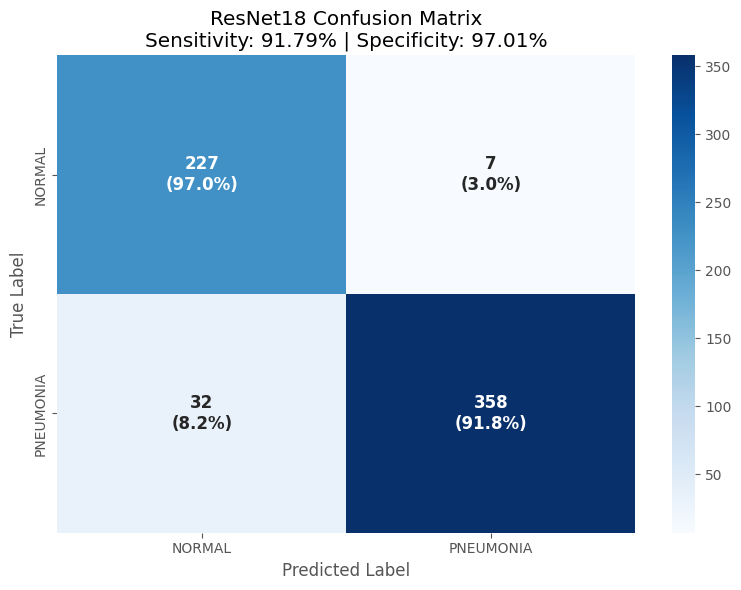


Evaluating DenseNet121...
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.8242    0.9615    0.8876       234
   PNEUMONIA     0.9744    0.8769    0.9231       390

    accuracy                         0.9087       624
   macro avg     0.8993    0.9192    0.9053       624
weighted avg     0.9180    0.9087    0.9098       624

Accuracy: 0.9087
Test Loss: 0.2614
Sensitivity (Recall): 0.8769
Specificity: 0.9615
Precision (Pneumonia): 0.9744
F1-Score (Pneumonia): 0.9231
AUC: 0.9855


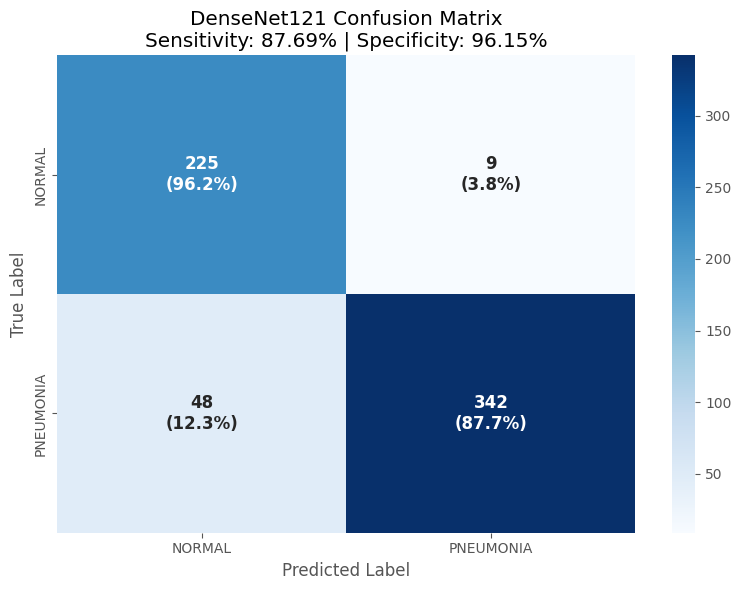


Evaluating InceptionV3...
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 795ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9181    0.9103    0.9142       234
   PNEUMONIA     0.9464    0.9513    0.9488       390

    accuracy                         0.9359       624
   macro avg     0.9323    0.9308    0.9315       624
weighted avg     0.9358    0.9359    0.9358       624

Accuracy: 0.9359
Test Loss: 0.2961
Sensitivity (Recall): 0.9513
Specificity: 0.9103
Precision (Pneumonia): 0.9464
F1-Score (Pneumonia): 0.9488
AUC: 0.9807


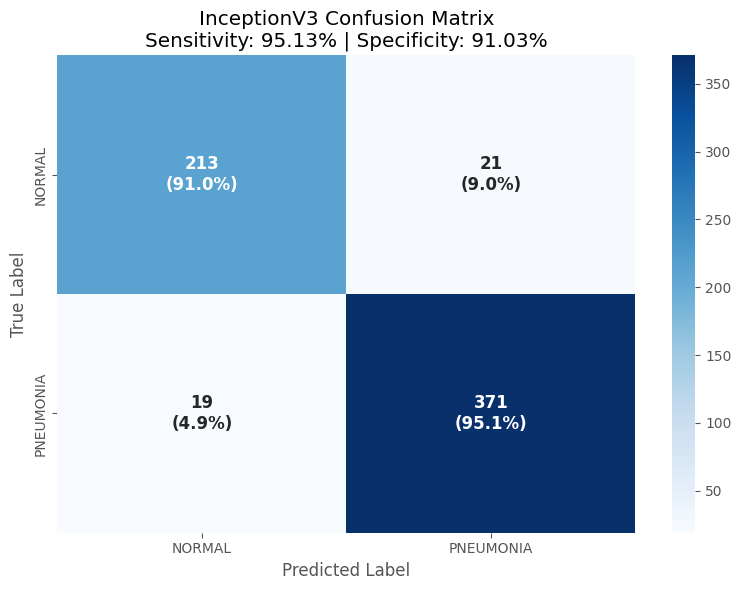


Evaluating Xception...
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9498    0.9701    0.9598       234
   PNEUMONIA     0.9818    0.9692    0.9755       390

    accuracy                         0.9696       624
   macro avg     0.9658    0.9697    0.9677       624
weighted avg     0.9698    0.9696    0.9696       624

Accuracy: 0.9696
Test Loss: 0.1839
Sensitivity (Recall): 0.9692
Specificity: 0.9701
Precision (Pneumonia): 0.9818
F1-Score (Pneumonia): 0.9755
AUC: 0.9933


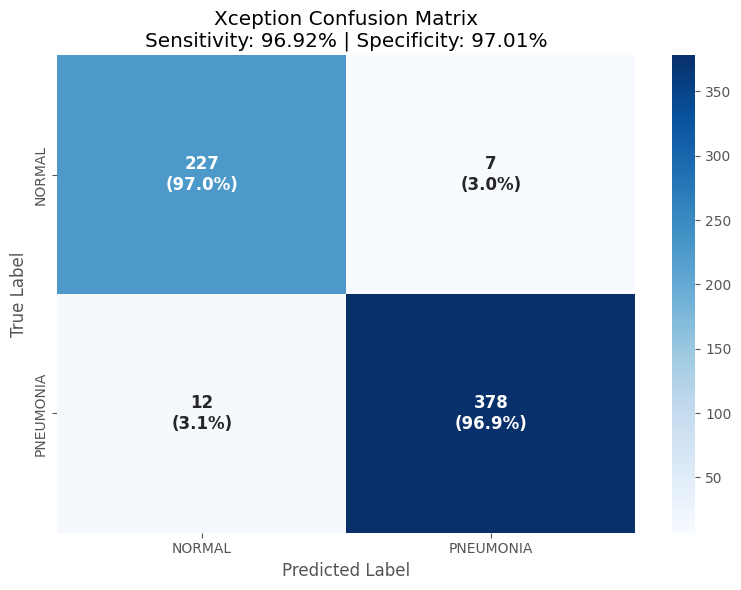


Evaluating MobileNetV2...
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 787ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.8828    0.9017    0.8922       234
   PNEUMONIA     0.9403    0.9282    0.9342       390

    accuracy                         0.9183       624
   macro avg     0.9116    0.9150    0.9132       624
weighted avg     0.9187    0.9183    0.9184       624

Accuracy: 0.9183
Test Loss: 0.2208
Sensitivity (Recall): 0.9282
Specificity: 0.9017
Precision (Pneumonia): 0.9403
F1-Score (Pneumonia): 0.9342
AUC: 0.9740


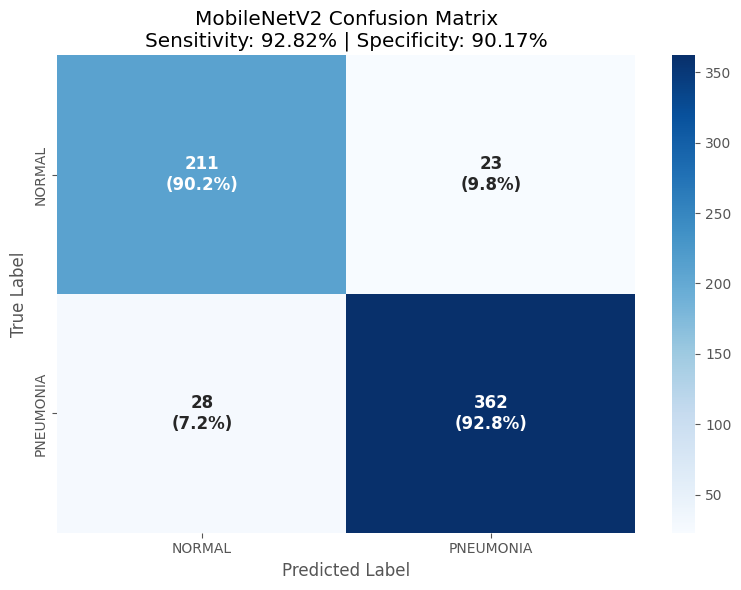


Model Performance Summary:
Model           Accuracy  Test Loss  Sensitivity  Specificity  Precision   F1-Score      AUC
ResNet18          0.9375     0.1854       0.9179       0.9701     0.9808     0.9483   0.9885
DenseNet121       0.9087     0.2614       0.8769       0.9615     0.9744     0.9231   0.9855
InceptionV3       0.9359     0.2961       0.9513       0.9103     0.9464     0.9488   0.9807
Xception          0.9696     0.1839       0.9692       0.9701     0.9818     0.9755   0.9933
MobileNetV2       0.9183     0.2208       0.9282       0.9017     0.9403     0.9342   0.9740


In [ ]:
# Evaluate Individual Models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Evaluating individual models...")

# Define metrics storage
model_metrics = []

for i, (model, config) in enumerate(zip(base_models, model_configs)):
    if model is None:
        print(f"Skipping evaluation for model {i} ({config['name']}) - not loaded")
        continue

    print(f"\nEvaluating {config['name']}...")

    # Prepare test generator
    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )

    test_generator = test_gen.flow_from_directory(
        TEST_PATH,
        target_size=config['target_size'],
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Evaluate model
    test_generator.reset()
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Calculate test loss
    test_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    test_loss = np.mean(test_loss)

    # Generate and print classification report with 4 significant figures
    print("\nClassification Report:")
    report = classification_report(
        y_true,
        y_pred_labels,
        target_names=['NORMAL', 'PNEUMONIA'],
        digits=4
    )
    print(report)

    # Calculate metrics
    accuracy = np.mean(y_true == y_pred_labels)
    cm = confusion_matrix(y_true, y_pred_labels)

    # Calculate class-specific metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision_pneumonia = precision_score(y_true, y_pred_labels, pos_label=1)
    f1_pneumonia = f1_score(y_true, y_pred_labels, pos_label=1)
    auc_score = roc_auc_score(y_true, y_pred[:, 1])

    # Store metrics
    metrics = {
        'name': config['name'],
        'accuracy': accuracy,
        'test_loss': test_loss,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pneumonia': precision_pneumonia,
        'f1_pneumonia': f1_pneumonia,
        'auc': auc_score,
        'confusion_matrix': cm
    }
    model_metrics.append(metrics)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision (Pneumonia): {precision_pneumonia:.4f}")
    print(f"F1-Score (Pneumonia): {f1_pneumonia:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # Calculate class-wise percentages
    class_totals = cm.sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_matrix = np.round((cm.astype(float) / class_totals.reshape(-1, 1)) * 100, 1)
    percentage_matrix = np.nan_to_num(percentage_matrix)

    # Create combined annotations
    annot_matrix = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({percentage_matrix[i, j]}%)"
            row.append(text)
        annot_matrix.append(row)

    # Plot confusion matrix with enhanced annotations
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(
        cm,
        annot=np.array(annot_matrix),
        fmt='',
        cmap='Blues',
        xticklabels=['NORMAL', 'PNEUMONIA'],
        yticklabels=['NORMAL', 'PNEUMONIA'],
        annot_kws={'fontweight': 'bold', 'fontsize': 12}
    )

    # Center-align text in cells
    for text in heatmap.texts:
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')

    plt.title(f"{config['name']} Confusion Matrix\nSensitivity: {sensitivity*100:.2f}% | Specificity: {specificity*100:.2f}%")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Print summary table
print("\nModel Performance Summary:")
print(f"{'Model':<15} {'Accuracy':>8} {'Test Loss':>10} {'Sensitivity':>12} {'Specificity':>12} {'Precision':>10} {'F1-Score':>10} {'AUC':>8}")
for metrics in model_metrics:
    print(f"{metrics['name']:<15} {metrics['accuracy']:>8.4f} {metrics['test_loss']:>10.4f} {metrics['sensitivity']:>12.4f} "
          f"{metrics['specificity']:>12.4f} {metrics['precision_pneumonia']:>10.4f} "
          f"{metrics['f1_pneumonia']:>10.4f} {metrics['auc']:>8.4f}")

## **Quantisation Experiments**

### **Quantise The Ensemble Models Float16**

In [ ]:
# Quantize Ensemble for Low-Resource Settings Float16
import tensorflow as tf
import os

print("\nQuantizing ensemble components...")

# Create directory for quantized models
quant_dir = "/content/drive/MyDrive/chest_xray/quantized_ensemble"
os.makedirs(quant_dir, exist_ok=True)

# Quantize base models
quantized_base_paths = []
for i, (model, config) in enumerate(zip(base_models, model_configs)):
    if model is None:
        quantized_base_paths.append(None)
        continue

    print(f"Quantizing {config['name']}...")

    # Create converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Set optimization options (FP16 quantization)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]

    # Convert model
    tflite_model = converter.convert()

    # Save model
    model_path = os.path.join(quant_dir, f"base_model_{i}_quant.tflite")
    with open(model_path, 'wb') as f:
        f.write(tflite_model)

    quantized_base_paths.append(model_path)
    print(f"Quantized model saved to {model_path}")

# Quantize meta-learner
print("Quantizing meta-learner...")
converter = tf.lite.TFLiteConverter.from_keras_model(meta_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_meta = converter.convert()
meta_path = os.path.join(quant_dir, "meta_learner_quant.tflite")
with open(meta_path, 'wb') as f:
    f.write(tflite_meta)
print(f"Quantized meta-learner saved to {meta_path}")

# Save optimal weights
weights_path = os.path.join(quant_dir, "optimal_weights_quant.npy")
np.save(weights_path, optimal_weights)
print(f"Optimal weights saved to {weights_path}")

print("Quantization complete!")


Quantizing ensemble components...
Quantizing ResNet18...
Saved artifact at '/tmp/tmpsjdmby0n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133003710061200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710062736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710062928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710062160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710061968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710062544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710064464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710065040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710065232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133003710064080: TensorSpec

#### **Evaluate Float 16 Quantised Models**


Evaluating FP16 quantized models...

Evaluating FP16 quantized ResNet18...
Found 624 images belonging to 2 classes.


Evaluating ResNet18: 100%|██████████| 624/624 [02:10<00:00,  4.79it/s]


Model size: 45.83 MB
Accuracy: 0.9375
Sensitivity: 0.9179
Specificity: 0.9701
Precision (Pneumonia): 0.9808
F1-Score (Pneumonia): 0.9483
AUC: 0.9886

Evaluating FP16 quantized DenseNet121...
Found 624 images belonging to 2 classes.


Evaluating DenseNet121: 100%|██████████| 624/624 [01:35<00:00,  6.51it/s]


Model size: 13.89 MB
Accuracy: 0.9071
Sensitivity: 0.8744
Specificity: 0.9615
Precision (Pneumonia): 0.9743
F1-Score (Pneumonia): 0.9216
AUC: 0.9855

Evaluating FP16 quantized InceptionV3...
Found 624 images belonging to 2 classes.


Evaluating InceptionV3: 100%|██████████| 624/624 [02:46<00:00,  3.74it/s]


Model size: 42.60 MB
Accuracy: 0.9343
Sensitivity: 0.9513
Specificity: 0.9060
Precision (Pneumonia): 0.9440
F1-Score (Pneumonia): 0.9476
AUC: 0.9806

Evaluating FP16 quantized Xception...
Found 624 images belonging to 2 classes.


Evaluating Xception: 100%|██████████| 624/624 [04:27<00:00,  2.34it/s]

Model size: 40.69 MB
Accuracy: 0.9696
Sensitivity: 0.9692
Specificity: 0.9701
Precision (Pneumonia): 0.9818
F1-Score (Pneumonia): 0.9755
AUC: 0.9933


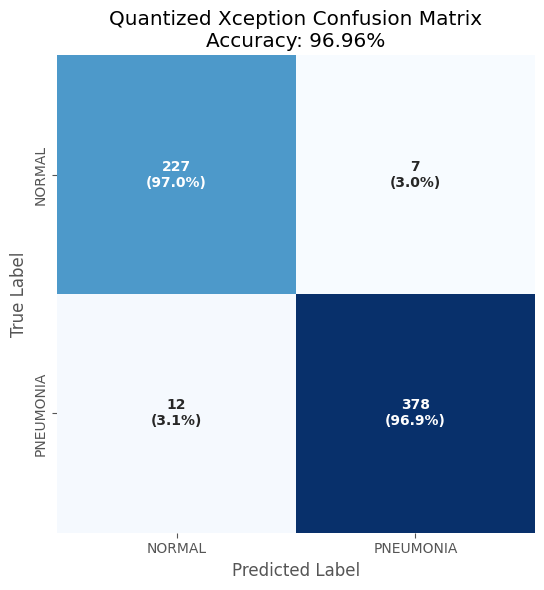


Evaluating FP16 quantized MobileNetV2...
Found 624 images belonging to 2 classes.


Evaluating MobileNetV2: 100%|██████████| 624/624 [00:19<00:00, 32.69it/s]

Model size: 4.88 MB
Accuracy: 0.9215
Sensitivity: 0.9333
Specificity: 0.9017
Precision (Pneumonia): 0.9406
F1-Score (Pneumonia): 0.9369
AUC: 0.9741

Evaluating FP16 quantized ensemble...
Found 624 images belonging to 2 classes.



Evaluating Quantized Ensemble: 100%|██████████| 624/624 [19:51<00:00,  1.91s/it]


FP16 Quantized Ensemble Performance:
Model size: 147.91 MB
Accuracy: 0.9455
Sensitivity: 0.9231
Specificity: 0.9829
Precision (Pneumonia): 0.9890
F1-Score (Pneumonia): 0.9549
AUC: 0.9926


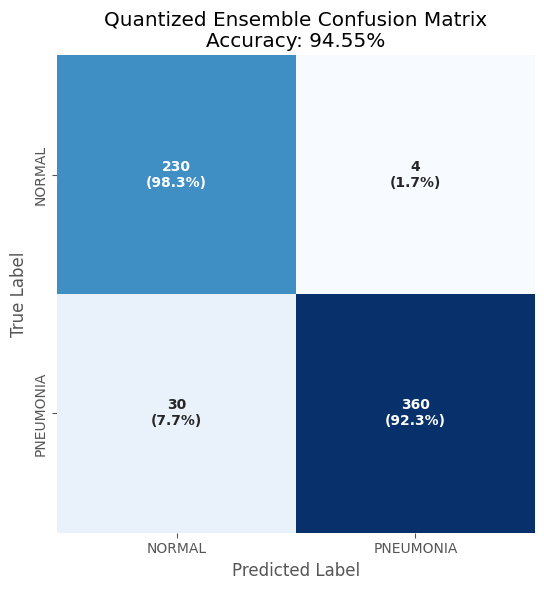


Quantized Models Performance Summary:
Model                Size (MB) Accuracy  Sensitivity  Specificity  Precision   F1-Score      AUC
Quant ResNet18           45.83   0.9375       0.9179       0.9701     0.9808     0.9483   0.9886
Quant DenseNet121        13.89   0.9071       0.8744       0.9615     0.9743     0.9216   0.9855
Quant InceptionV3        42.60   0.9343       0.9513       0.9060     0.9440     0.9476   0.9806
Quant Xception           40.69   0.9696       0.9692       0.9701     0.9818     0.9755   0.9933
Quant MobileNetV2         4.88   0.9215       0.9333       0.9017     0.9406     0.9369   0.9741
Quantized Ensemble      147.91   0.9455       0.9231       0.9829     0.9890     0.9549   0.9926


In [ ]:
# Evaluate Quantized Models
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os

# Function to plot enhanced confusion matrix
def plot_enhanced_confusion_matrix(cm, class_names, model_name, accuracy=None):
    """
    Plots enhanced confusion matrix with counts and class-wise percentages
    """
    plt.figure(figsize=(8, 6))
    total_samples = np.sum(cm)

    # Calculate percentages
    percentages = cm / cm.sum(axis=1, keepdims=True).astype(float) * 100

    # Create annotation labels
    annot_labels = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct = percentages[i, j]
            annot_labels[i, j] = f"{count}\n({pct:.1f}%)"

    # Plot heatmap
    ax = sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
                     cbar=False, square=True,
                     xticklabels=class_names,
                     yticklabels=class_names,
                     annot_kws={'weight': 'bold'})  # Made annotations bold

    # Add title and labels
    title = f"{model_name} Confusion Matrix"
    if accuracy is not None:
        title += f"\nAccuracy: {accuracy:.2%}"
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

print("\nEvaluating FP16 quantized models...")

def get_model_size_mb(path):
    """Return file size in MB"""
    if os.path.exists(path):
        size_bytes = os.path.getsize(path)
        return size_bytes / (1024 * 1024)
    return 0.0

def evaluate_quantized_model(model_path, config):
    """Evaluate a quantized TFLite model with AUC calculation"""
    # Get model size first
    model_size = get_model_size_mb(model_path)

    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare test data
    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )

    test_generator = test_gen.flow_from_directory(
        TEST_PATH,
        target_size=config['target_size'],
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    # Run predictions
    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for AUC calculation

    # Reset generator and get total number of samples
    test_generator.reset()
    num_samples = len(test_generator)

    for _ in tqdm(range(num_samples), desc=f"Evaluating {config['name']}"):
        # Use Python's next() function with the generator
        batch = next(test_generator)
        img = batch[0]  # Image data
        label = batch[1]  # Label

        y_true.append(np.argmax(label))

        # Prepare input - ensure correct data type
        input_dtype = input_details[0]['dtype']
        if img.dtype != input_dtype:
            img = img.astype(input_dtype)

        # Set input and run inference
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])

        # Store prediction and probability
        y_pred.append(np.argmax(output))
        y_probs.append(output[0][1])  # Probability for pneumonia class

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision_pneumonia = precision_score(y_true, y_pred, pos_label=1)
    f1_pneumonia = f1_score(y_true, y_pred, pos_label=1)

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pneumonia': precision_pneumonia,
        'f1_pneumonia': f1_pneumonia,
        'auc': auc,
        'confusion_matrix': cm,
        'model_size': model_size,
        'y_true': y_true,
        'y_pred': y_pred
    }

# Evaluate quantised base models
quantized_metrics = []
for i, (model_path, config) in enumerate(zip(quantized_base_paths, model_configs)):
    if model_path is None or not os.path.exists(model_path):
        print(f"Skipping {config['name']} - model not found")
        continue

    print(f"\nEvaluating FP16 quantized {config['name']}...")
    metrics = evaluate_quantized_model(model_path, config)
    metrics['name'] = f"Quant {config['name']}"
    quantized_metrics.append(metrics)

    # Print metrics with size
    print(f"Model size: {metrics['model_size']:.2f} MB")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Precision (Pneumonia): {metrics['precision_pneumonia']:.4f}")
    print(f"F1-Score (Pneumonia): {metrics['f1_pneumonia']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Plot confusion matrix for Xception
    if config['name'] == 'Xception':
        plot_enhanced_confusion_matrix(
            metrics['confusion_matrix'],
            class_names=['NORMAL', 'PNEUMONIA'],
            model_name=f"Quantized {config['name']}",
            accuracy=metrics['accuracy']
        )

# Evaluate quantized ensemble
print("\nEvaluating FP16 quantized ensemble...")

def predict_quantized_ensemble(img_path):
    """Predict using quantized ensemble with probability output"""
    base_preds = []

    for i, (model_path, config) in enumerate(zip(quantized_base_paths, model_configs)):
        if model_path is None or not os.path.exists(model_path):
            base_preds.append(np.zeros((1, 2)))
            continue

        # Load and preprocess image
        img = tf.keras.utils.load_img(img_path, target_size=config['target_size'])
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = config['preprocess_func'](img_array)

        # Load TFLite model
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Ensure correct input data type
        input_dtype = input_details[0]['dtype']
        if img_array.dtype != input_dtype:
            img_array = img_array.astype(input_dtype)

        # Run inference
        interpreter.set_tensor(input_details[0]['index'], img_array)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_details[0]['index'])
        base_preds.append(pred)

    # Stack predictions for meta-learner
    stacked_preds = np.stack(base_preds, axis=1)

    # Load and run meta-learner
    meta_interpreter = tf.lite.Interpreter(model_path=meta_path)
    meta_interpreter.allocate_tensors()
    meta_input = meta_interpreter.get_input_details()[0]
    meta_output = meta_interpreter.get_output_details()[0]

    # Ensure correct input type for meta-learner
    if stacked_preds.dtype != meta_input['dtype']:
        stacked_preds = stacked_preds.astype(meta_input['dtype'])

    meta_interpreter.set_tensor(meta_input['index'], stacked_preds)
    meta_interpreter.invoke()
    meta_pred = meta_interpreter.get_tensor(meta_output['index'])

    # Weighted ensemble prediction
    weighted_pred = np.zeros_like(base_preds[0])
    for i, pred in enumerate(base_preds):
        weighted_pred += optimal_weights[i] * pred

    # Blend predictions
    final_pred = 0.6 * meta_pred + 0.4 * weighted_pred
    predicted_class = np.argmax(final_pred, axis=1)[0]
    confidence = np.max(final_pred)
    pneumonia_prob = final_pred[0][1]  # Probability for pneumonia class

    return predicted_class, confidence, pneumonia_prob

# Prepare test data
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_gen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),  # Use any size, we'll resize per model
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Run predictions
y_true = []
y_pred = []
pneumonia_probs = []  # Store pneumonia probabilities for AUC

# Reset generator and get total samples
test_generator.reset()
num_samples = len(test_generator)

for _ in tqdm(range(num_samples), desc="Evaluating Quantized Ensemble"):
    # Use next() with the generator
    batch = next(test_generator)
    img_path = test_generator.filepaths[test_generator.batch_index - 1]
    actual_label = np.argmax(batch[1][0])

    pred_class, confidence, pneumonia_prob = predict_quantized_ensemble(img_path)
    y_true.append(actual_label)
    y_pred.append(pred_class)
    pneumonia_probs.append(pneumonia_prob)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, pneumonia_probs)  # Use pneumonia probability for AUC
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision_pneumonia = precision_score(y_true, y_pred, pos_label=1)
f1_pneumonia = f1_score(y_true, y_pred, pos_label=1)

# Calculate ensemble model size
ensemble_size = 0
for path in quantized_base_paths:
    if path and os.path.exists(path):
        ensemble_size += get_model_size_mb(path)
if os.path.exists(meta_path):
    ensemble_size += get_model_size_mb(meta_path)
if os.path.exists(weights_path):
    ensemble_size += get_model_size_mb(weights_path)

# Store metrics
ensemble_metrics = {
    'name': "Quantized Ensemble",
    'accuracy': accuracy,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision_pneumonia': precision_pneumonia,
    'f1_pneumonia': f1_pneumonia,
    'auc': auc_score,
    'confusion_matrix': cm,
    'model_size': ensemble_size
}

# Print metrics
print("\nFP16 Quantized Ensemble Performance:")
print(f"Model size: {ensemble_size:.2f} MB")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision (Pneumonia): {precision_pneumonia:.4f}")
print(f"F1-Score (Pneumonia): {f1_pneumonia:.4f}")
print(f"AUC: {auc_score:.4f}")

# Plot enhanced confusion matrix for ensemble
plot_enhanced_confusion_matrix(
    cm,
    class_names=['NORMAL', 'PNEUMONIA'],
    model_name="Quantized Ensemble",
    accuracy=accuracy
)

# Add to metrics list
quantized_metrics.append(ensemble_metrics)

# Print summary with model sizes
print("\nQuantized Models Performance Summary:")
print(f"{'Model':<20} {'Size (MB)':>9} {'Accuracy':>8} {'Sensitivity':>12} {'Specificity':>12} {'Precision':>10} {'F1-Score':>10} {'AUC':>8}")
for metrics in quantized_metrics:
    print(f"{metrics['name']:<20} {metrics.get('model_size', 0):>9.2f} {metrics['accuracy']:>8.4f} "
          f"{metrics['sensitivity']:>12.4f} {metrics['specificity']:>12.4f} "
          f"{metrics['precision_pneumonia']:>10.4f} {metrics['f1_pneumonia']:>10.4f} {metrics['auc']:>8.4f}")

## **Quantise the Ensemble INT8**

**Load Saved Models**

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Define paths and parameters
TRAIN_PATH = "/content/drive/MyDrive/chest_xray/train"
TEST_PATH = "/content/drive/MyDrive/chest_xray/test"
QUANT_DIR = "/content/drive/MyDrive/chest_xray/Quantized_Ensemble"
BATCH_SIZE = 32

# Define model configurations with proper preprocessing
model_configs = [
    {
        'name': 'ResNet18',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.resnet.preprocess_input
    },
    {
        'name': 'DenseNet121',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.densenet.preprocess_input
    },
    {
        'name': 'InceptionV3',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.inception_v3.preprocess_input
    },
    {
        'name': 'Xception',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.xception.preprocess_input
    },
    {
        'name': 'MobileNetV2',
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input
    }
]

# Load ensemble components
base_models = []
for i, path in enumerate([
    "/content/drive/MyDrive/chest_xray/base_model_0.keras",
    "/content/drive/MyDrive/chest_xray/base_model_1.keras",
    "/content/drive/MyDrive/chest_xray/base_model_2.keras",
    "/content/drive/MyDrive/chest_xray/base_model_3.keras",
    "/content/drive/MyDrive/chest_xray/base_model_4.keras"
]):
    try:
        model = tf.keras.models.load_model(path)
        base_models.append(model)
        print(f"Base model {i} ({model_configs[i]['name']}) loaded successfully")
    except Exception as e:
        print(f"Error loading base model {i}: {e}")
        base_models.append(None)

try:
    meta_model = tf.keras.models.load_model("/content/drive/MyDrive/chest_xray/nuclear_ensemble_meta_learner.keras")
    print("Meta-learner model loaded successfully")
except Exception as e:
    print(f"Error loading meta-learner model: {e}")
    meta_model = None

try:
    optimal_weights = np.load("/content/drive/MyDrive/chest_xray/Nuclear_ensemble_optimal_weights.npy")
    print("Optimal weights loaded successfully")
except Exception as e:
    print(f"Error loading optimal weights: {e}")
    optimal_weights = None

# Define helper functions
def resize_image(image, target_size):
    """Resize image to target dimensions"""
    pil_img = Image.fromarray(image.astype('uint8'))
    pil_img = pil_img.resize(target_size, Image.BILINEAR)
    return img_to_array(pil_img)

def get_calibration_data(config, num_samples=400):
    """Gather real training data for calibration"""
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )
    generator = data_gen.flow_from_directory(
        TRAIN_PATH,
        target_size=config['target_size'],
        batch_size=1,
        class_mode='categorical',
        shuffle=True
    )
    samples = []
    for _ in range(num_samples):
        img, _ = next(generator)
        samples.append(img.astype(np.float32))
    return samples


Base model 0 (ResNet18) loaded successfully
Base model 1 (DenseNet121) loaded successfully
Base model 2 (InceptionV3) loaded successfully
Base model 3 (Xception) loaded successfully
Base model 4 (MobileNetV2) loaded successfully
Meta-learner model loaded successfully
Optimal weights loaded successfully


### **PT-PQ INT8 QUANTISATION Inspired by S. Thakur et al.**

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# CONFIGURATION AND SETUP

# Define paths and parameters
TRAIN_PATH = "/content/drive/MyDrive/chest_xray/train"
TEST_PATH = "/content/drive/MyDrive/chest_xray/test"

# NEW directory for quantized models (to prevent overwriting)
QUANT_DIR = "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble"
os.makedirs(QUANT_DIR, exist_ok=True)  # Create new directory

# Model configurations
model_configs = [
    {'name': 'ResNet18', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.resnet.preprocess_input},
    {'name': 'DenseNet121', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.densenet.preprocess_input},
    {'name': 'InceptionV3', 'input_shape': (299, 299, 3), 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.inception_v3.preprocess_input},
    {'name': 'Xception', 'input_shape': (299, 299, 3), 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.xception.preprocess_input},
    {'name': 'MobileNetV2', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input}
]

# Load original ensemble components
base_models = []
model_paths = [
    "/content/drive/MyDrive/chest_xray/base_model_0.keras",
    "/content/drive/MyDrive/chest_xray/base_model_1.keras",
    "/content/drive/MyDrive/chest_xray/base_model_2.keras",
    "/content/drive/MyDrive/chest_xray/base_model_3.keras",
    "/content/drive/MyDrive/chest_xray/base_model_4.keras"
]

for i, path in enumerate(model_paths):
    try:
        model = tf.keras.models.load_model(path)
        base_models.append(model)
        print(f"Loaded base model {i} ({model_configs[i]['name']})")
    except Exception as e:
        print(f"Error loading base model {i}: {e}")
        base_models.append(None)

# Load meta-learner and weights
try:
    meta_model = tf.keras.models.load_model("/content/drive/MyDrive/chest_xray/nuclear_ensemble_meta_learner.keras")
    print("Loaded meta-learner model")
except Exception as e:
    print(f"Error loading meta-learner: {e}")
    meta_model = None

try:
    optimal_weights = np.load("/content/drive/MyDrive/chest_xray/Nuclear_ensemble_optimal_weights.npy")
    print("Loaded optimal weights")
except Exception as e:
    print(f"Error loading weights: {e}")
    optimal_weights = None


# QUANTISE MODELS USING TENSORFLOW LITE (PT-PQ METHOD)

def get_calibration_data(config, num_samples=520):  # 10% of 5216 ≈ 520
    """Gather calibration data"""
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )
    generator = data_gen.flow_from_directory(
        TRAIN_PATH,
        target_size=config['target_size'],
        batch_size=1,
        class_mode='categorical',
        shuffle=True
    )
    samples = []
    for _ in range(num_samples):
        img, _ = next(generator)
        samples.append(img.astype(np.float32))
    return samples

def quantize_model(model, calibration_data, model_name):
    """Apply TensorFlow Lite PT-PQ quantisation"""
    # Convert to TFLite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Set optimization options (PT-PQ)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Create representative dataset (10% of data)
    def representative_dataset():
        for data in calibration_data:
            yield [data.astype(np.float32)]

    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.float32  #  FP32 input
    converter.inference_output_type = tf.float32  # FP32 output

    # Quantize model
    tflite_model = converter.convert()

    # Save quantized model
    save_path = os.path.join(QUANT_DIR, f"{model_name}_int8.tflite")
    with open(save_path, 'wb') as f:
        f.write(tflite_model)
    model_size = len(tflite_model) / (1024 * 1024)
    print(f"Quantized {model_name} saved to {save_path} ({model_size:.2f} MB)")

    return save_path

print("\nQuantizing base models using TensorFlow Lite...")
quantized_model_paths = []
for i, (model, config) in enumerate(zip(base_models, model_configs)):
    if model is None:
        quantized_model_paths.append(None)
        continue

    print(f"\nQuantizing {config['name']}...")
    calib_data = get_calibration_data(config)
    model_path = quantize_model(model, calib_data, f"base_model_{i}")
    quantized_model_paths.append(model_path)

# Quantise meta-learner
if meta_model:
    print("\nQuantizing meta-learner...")

    # Create representative data for meta-learner (base models' predictions)
    def create_meta_calibration_data(num_samples=520):
        """Generate base model predictions as meta-learner input"""
        # Use first model's config to get images
        calib_data = get_calibration_data(model_configs[0], num_samples)

        meta_inputs = []
        for img in calib_data:
            base_preds = []
            for model, config in zip(base_models, model_configs):
                # Preprocess for specific model
                if config['target_size'] != model_configs[0]['target_size']:
                    pil_img = Image.fromarray(img[0].astype('uint8'))
                    pil_img = pil_img.resize(config['target_size'])
                    processed_img = config['preprocess_func'](img_to_array(pil_img)[np.newaxis, ...])
                else:
                    processed_img = config['preprocess_func'](img)
                pred = model.predict(processed_img, verbose=0)
                base_preds.append(pred[0])
            stacked_preds = np.stack(base_preds, axis=0)[np.newaxis, ...]
            meta_inputs.append(stacked_preds.astype(np.float32))
        return meta_inputs

    meta_calib_data = create_meta_calibration_data()
    quantize_model(meta_model, meta_calib_data, "meta_learner")

# Save optimal weights to quant directory
if optimal_weights is not None:
    weights_path = os.path.join(QUANT_DIR, "optimal_weights.npy")
    np.save(weights_path, optimal_weights)
    print(f"Saved optimal weights to {weights_path}")

print("\nINT8 Quantisation complete! Models saved in:", QUANT_DIR)

Loaded base model 0 (ResNet18)
Loaded base model 1 (DenseNet121)
Loaded base model 2 (InceptionV3)
Loaded base model 3 (Xception)
Loaded base model 4 (MobileNetV2)
Loaded meta-learner model
Loaded optimal weights

Quantizing base models using TensorFlow Lite...

Quantizing ResNet18...
Found 5232 images belonging to 2 classes.
Saved artifact at '/tmp/tmpkmm8sjex'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135176229546960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176229536016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176229546384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176229547152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176229549648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176229547344: TensorSpec(shape=(),

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized base_model_0 saved to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_0_int8.tflite (23.62 MB)

Quantizing DenseNet121...
Found 5232 images belonging to 2 classes.
Saved artifact at '/tmp/tmp4mbcierg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135177069306384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069307152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069307536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069307344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069305616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069308304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069308688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135177069306768: TensorSpec(s

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized base_model_1 saved to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_1_int8.tflite (7.26 MB)

Quantizing InceptionV3...
Found 5232 images belonging to 2 classes.
Saved artifact at '/tmp/tmpiudwgida'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135176503129488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503129104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503130640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503130832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503131792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503131024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503128720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176503131408: TensorSpec(sh

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized base_model_2 saved to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_2_int8.tflite (21.77 MB)

Quantizing Xception...
Found 5232 images belonging to 2 classes.
Saved artifact at '/tmp/tmpfri4nbg6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135176497738960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497739728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497740112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497739920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497738192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497741264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497738384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176497741648: TensorSpec(shap

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized base_model_3 saved to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_3_int8.tflite (21.61 MB)

Quantizing MobileNetV2...
Found 5232 images belonging to 2 classes.
Saved artifact at '/tmp/tmp0ummg68_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135176496176336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496177104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496177488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496177296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496176144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496175568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496179408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176496179792: TensorSpec(s

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized base_model_4 saved to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_4_int8.tflite (2.90 MB)

Quantizing meta-learner...
Found 5232 images belonging to 2 classes.
Saved artifact at '/tmp/tmpye1iarp7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5, 2), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135176492761552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176492773648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176492771536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176492774800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176492774032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135176492775952: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized meta_learner saved to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/meta_learner_int8.t

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### **Evaluation Of Individual INT8 PT-PQ**


Evaluating individual quantized models...
Loaded quantized ResNet18 (23.62 MB)
Loaded quantized DenseNet121 (7.26 MB)
Loaded quantized InceptionV3 (21.77 MB)
Loaded quantized Xception (21.61 MB)
Loaded quantized MobileNetV2 (2.90 MB)
Loaded quantized meta-learner (0.02 MB)
Loaded optimal weights

Evaluating quantized ResNet18...
Found 624 images belonging to 2 classes.


Evaluating ResNet18: 100%|██████████| 624/624 [01:33<00:00,  6.68it/s]


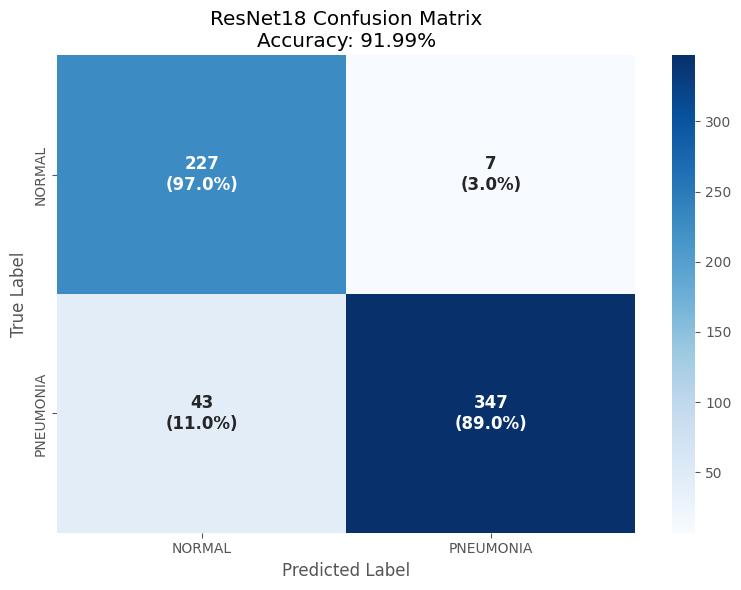

Model size: 23.62 MB
Accuracy: 0.9199
Sensitivity: 0.8897
Specificity: 0.9701
Precision (Pneumonia): 0.9802
F1-Score (Pneumonia): 0.9328
AUC: 0.9876

Evaluating quantized DenseNet121...
Found 624 images belonging to 2 classes.


Evaluating DenseNet121: 100%|██████████| 624/624 [01:17<00:00,  8.00it/s]


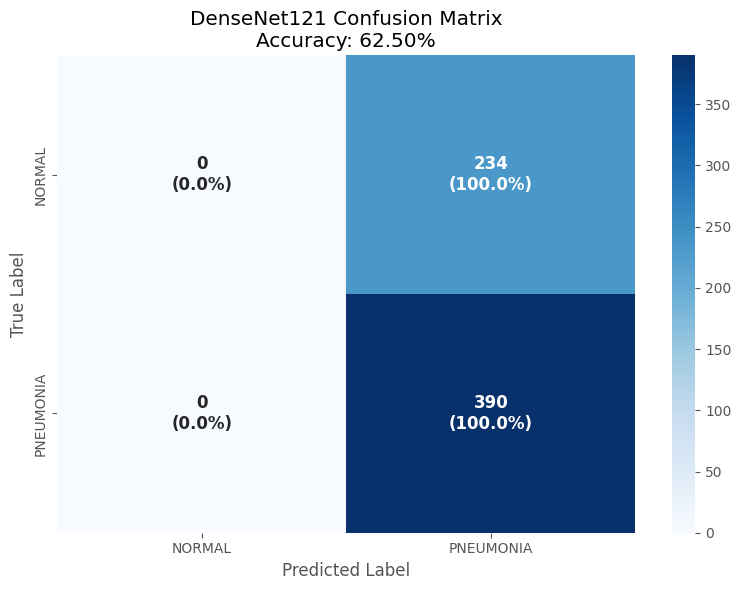

Model size: 7.26 MB
Accuracy: 0.6250
Sensitivity: 1.0000
Specificity: 0.0000
Precision (Pneumonia): 0.6250
F1-Score (Pneumonia): 0.7692
AUC: 0.7872

Evaluating quantized InceptionV3...
Found 624 images belonging to 2 classes.


Evaluating InceptionV3: 100%|██████████| 624/624 [02:10<00:00,  4.76it/s]


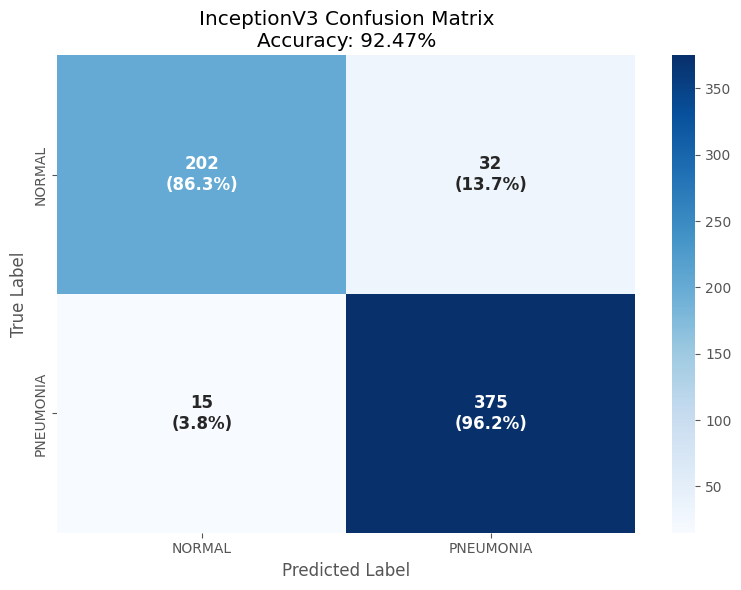

Model size: 21.77 MB
Accuracy: 0.9247
Sensitivity: 0.9615
Specificity: 0.8632
Precision (Pneumonia): 0.9214
F1-Score (Pneumonia): 0.9410
AUC: 0.9817

Evaluating quantized Xception...
Found 624 images belonging to 2 classes.


Evaluating Xception: 100%|██████████| 624/624 [03:26<00:00,  3.02it/s]


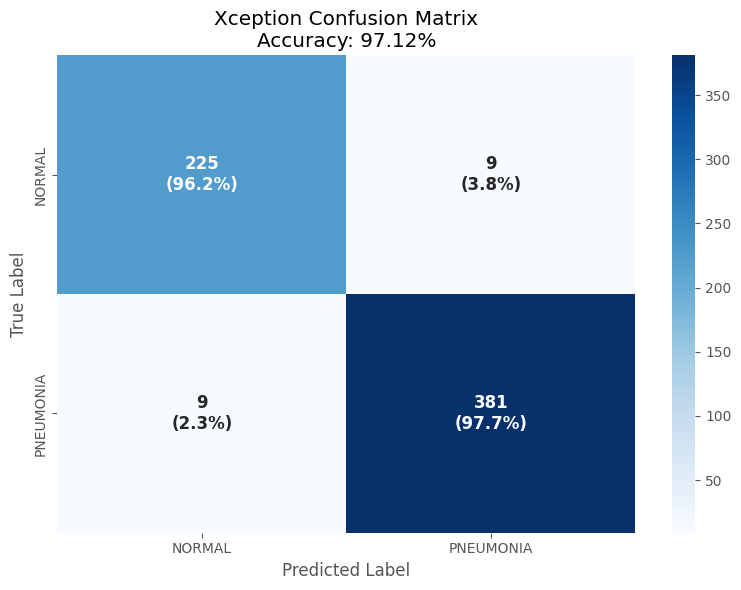

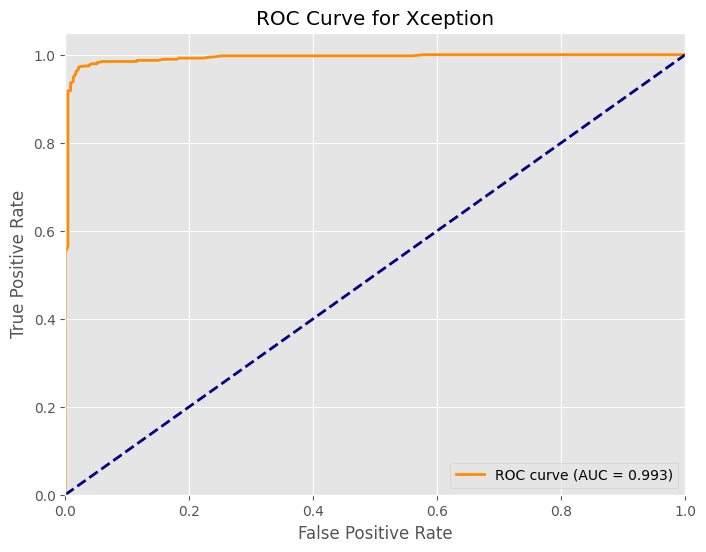

Model size: 21.61 MB
Accuracy: 0.9712
Sensitivity: 0.9769
Specificity: 0.9615
Precision (Pneumonia): 0.9769
F1-Score (Pneumonia): 0.9769
AUC: 0.9934

Evaluating quantized MobileNetV2...
Found 624 images belonging to 2 classes.


Evaluating MobileNetV2: 100%|██████████| 624/624 [00:20<00:00, 31.15it/s]


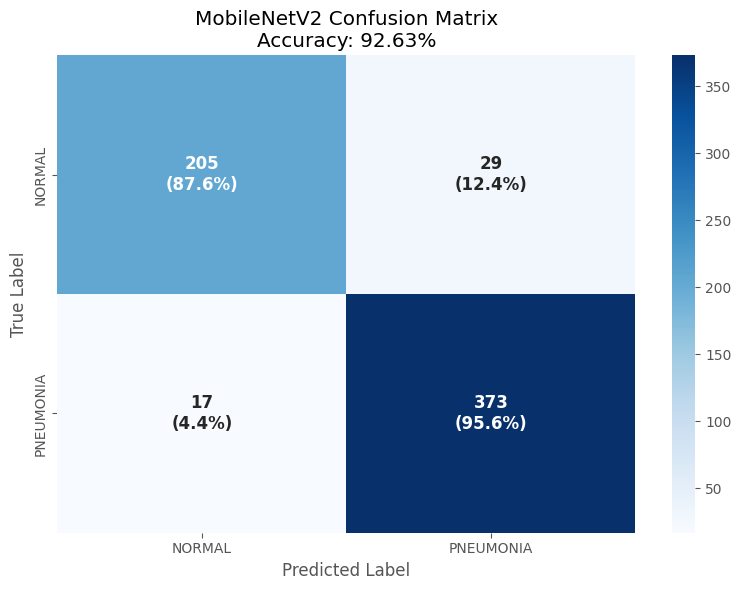

Model size: 2.90 MB
Accuracy: 0.9263
Sensitivity: 0.9564
Specificity: 0.8761
Precision (Pneumonia): 0.9279
F1-Score (Pneumonia): 0.9419
AUC: 0.9789

Quantized Model Performance Summary:
Model                 Size (MB) Accuracy  Sensitivity  Specificity  Precision   F1-Score      AUC
-------------------------------------------------------------------------------------------------
ResNet18                  23.62   0.9199       0.8897       0.9701     0.9802     0.9328   0.9876
DenseNet121                7.26   0.6250       1.0000       0.0000     0.6250     0.7692   0.7872
InceptionV3               21.77   0.9247       0.9615       0.8632     0.9214     0.9410   0.9817
Xception                  21.61   0.9712       0.9769       0.9615     0.9769     0.9769   0.9934
MobileNetV2                2.90   0.9263       0.9564       0.8761     0.9279     0.9419   0.9789

Individual model evaluation complete!


In [ ]:
# INDIVIDUAL QUANTISED MODEL EVALUATION

import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

print("\nEvaluating individual quantized models...")

# Load quantised models as TFLite interpreters
quantized_interpreters = {}
model_sizes = {}
for i, config in enumerate(model_configs):
    model_path = os.path.join(QUANT_DIR, f"base_model_{i}_int8.tflite")
    if not os.path.exists(model_path):
        print(f"Quantized model not found for {config['name']}")
        continue
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    quantized_interpreters[config['name']] = interpreter
    model_sizes[config['name']] = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Loaded quantized {config['name']} ({model_sizes[config['name']]:.2f} MB)")

# Load quantised meta-learner
meta_path = os.path.join(QUANT_DIR, "meta_learner_int8.tflite")
if not os.path.exists(meta_path):
    print(f"Quantized meta-learner not found at {meta_path}")
    meta_interpreter = None
else:
    meta_interpreter = tf.lite.Interpreter(model_path=meta_path)
    meta_interpreter.allocate_tensors()
    meta_size = os.path.getsize(meta_path) / (1024 * 1024)
    print(f"Loaded quantized meta-learner ({meta_size:.2f} MB)")

# Load optimal weights
weights_path = os.path.join(QUANT_DIR, "optimal_weights.npy")
if not os.path.exists(weights_path):
    print(f"Optimal weights not found at {weights_path}")
    optimal_weights = None
else:
    optimal_weights = np.load(weights_path)
    print("Loaded optimal weights")

# Function to plot enhanced confusion matrix
def plot_confusion_matrix(cm, title, accuracy):
    """Plot confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    class_totals = cm.sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_matrix = np.round((cm.astype(float) / class_totals.reshape(-1, 1)) * 100, 1)
    percentage_matrix = np.nan_to_num(percentage_matrix)
    annot_matrix = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({percentage_matrix[i, j]}%)"
            row.append(text)
        annot_matrix.append(row)
    heatmap = sns.heatmap(
        cm,
        annot=np.array(annot_matrix),
        fmt='',
        cmap='Blues',
        xticklabels=['NORMAL', 'PNEUMONIA'],
        yticklabels=['NORMAL', 'PNEUMONIA'],
        annot_kws={'fontweight': 'bold', 'fontsize': 12}
    )
    for text in heatmap.texts:
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    plt.title(f"{title}\nAccuracy: {accuracy:.2%}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Evaluation function with ROC for Xception
def evaluate_quantized_model_with_roc(interpreter, test_generator, model_name):
    """Evaluate a quantized model with ROC for Xception"""
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    y_true = []
    y_pred = []
    y_scores = []
    test_generator.reset()
    for _ in tqdm(range(len(test_generator)), desc=f"Evaluating {model_name}"):
        image, label = next(test_generator)
        y_true.append(np.argmax(label[0]))
        interpreter.set_tensor(input_details['index'], image.astype(np.float32))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])
        y_scores.append(output[0][1])
        y_pred.append(np.argmax(output[0]))

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_pneumonia = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_pneumonia = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    auc_score = roc_auc_score(y_true, y_scores)

    # Plot confusion matrix
    plot_confusion_matrix(cm, f"{model_name} Confusion Matrix", accuracy)

    # Plot ROC curve only for Xception
    if model_name == 'Xception':
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pneumonia': precision_pneumonia,
        'f1_pneumonia': f1_pneumonia,
        'auc': auc_score,
        'confusion_matrix': cm
    }

# Evaluate individual quantised models
quantized_metrics = []
for model_name, interpreter in quantized_interpreters.items():
    print(f"\nEvaluating quantized {model_name}...")
    config = next(cfg for cfg in model_configs if cfg['name'] == model_name)
    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )
    test_generator = test_gen.flow_from_directory(
        TEST_PATH,
        target_size=config['target_size'],
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )
    metrics = evaluate_quantized_model_with_roc(interpreter, test_generator, model_name)
    metrics['name'] = model_name
    quantized_metrics.append(metrics)
    print(f"Model size: {model_sizes[model_name]:.2f} MB")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Precision (Pneumonia): {metrics['precision_pneumonia']:.4f}")
    print(f"F1-Score (Pneumonia): {metrics['f1_pneumonia']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

# Print summary table
print("\nQuantized Model Performance Summary:")
header = f"{'Model':<20} {'Size (MB)':>10} {'Accuracy':>8} {'Sensitivity':>12} {'Specificity':>12} {'Precision':>10} {'F1-Score':>10} {'AUC':>8}"
print(header)
print('-' * len(header))
for metrics in quantized_metrics:
    size = model_sizes[metrics['name']]
    print(f"{metrics['name']:<20} {size:>10.2f} {metrics['accuracy']:>8.4f} {metrics['sensitivity']:>12.4f} "
          f"{metrics['specificity']:>12.4f} {metrics['precision_pneumonia']:>10.4f} "
          f"{metrics['f1_pneumonia']:>10.4f} {metrics['auc']:>8.4f}")

print("\nIndividual model evaluation complete!")

### **INDIVIDUAL QUANTISED MODEL EVALUATION WITH CLASSIFICATION REPORT**

##### **a. Load Quantised Models and Set Configuration**

In [ ]:
# Define paths and parameters
TRAIN_PATH = "/content/drive/MyDrive/chest_xray/train"
TEST_PATH = "/content/drive/MyDrive/chest_xray/test"

# NEW directory for quantized models (to prevent overwriting)
QUANT_DIR = "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble"
os.makedirs(QUANT_DIR, exist_ok=True)  # Create new directory

# Model configurations
model_configs = [
    {'name': 'ResNet18', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.resnet.preprocess_input},
    {'name': 'DenseNet121', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.densenet.preprocess_input},
    {'name': 'InceptionV3', 'input_shape': (224, 224, 3), 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.inception_v3.preprocess_input},
    {'name': 'Xception', 'input_shape': (224, 224, 3), 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.xception.preprocess_input},
    {'name': 'MobileNetV2', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input}
]

#### **b. Evaluate the Individual Quantised Models**


Evaluating individual quantized models...
Loaded quantized ResNet18 (23.62 MB)
Loaded quantized DenseNet121 (7.26 MB)
Loaded quantized InceptionV3 (21.77 MB)
Loaded quantized Xception (21.61 MB)
Loaded quantized MobileNetV2 (2.90 MB)
Loaded quantized meta-learner (0.02 MB)
Loaded optimal weights

Evaluating quantized ResNet18...
Found 624 images belonging to 2 classes.


Evaluating ResNet18: 100%|██████████| 624/624 [01:06<00:00,  9.44it/s]



Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.8407    0.9701    0.9008       234
   PNEUMONIA     0.9802    0.8897    0.9328       390

    accuracy                         0.9199       624
   macro avg     0.9105    0.9299    0.9168       624
weighted avg     0.9279    0.9199    0.9208       624



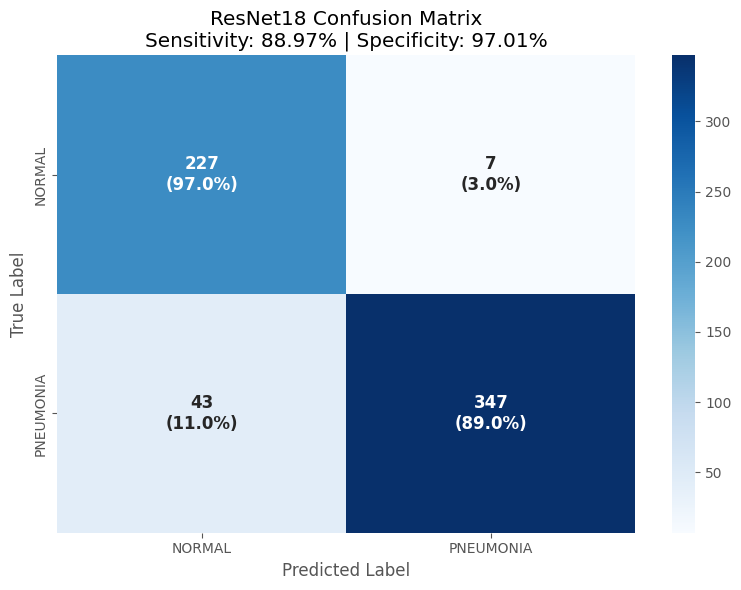

Model size: 23.62 MB
Accuracy: 0.9199
Sensitivity: 0.8897
Specificity: 0.9701
Precision (Pneumonia): 0.9802
F1-Score (Pneumonia): 0.9328
AUC: 0.9876

Evaluating quantized DenseNet121...
Found 624 images belonging to 2 classes.


Evaluating DenseNet121: 100%|██████████| 624/624 [00:54<00:00, 11.44it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital


Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       234
   PNEUMONIA     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



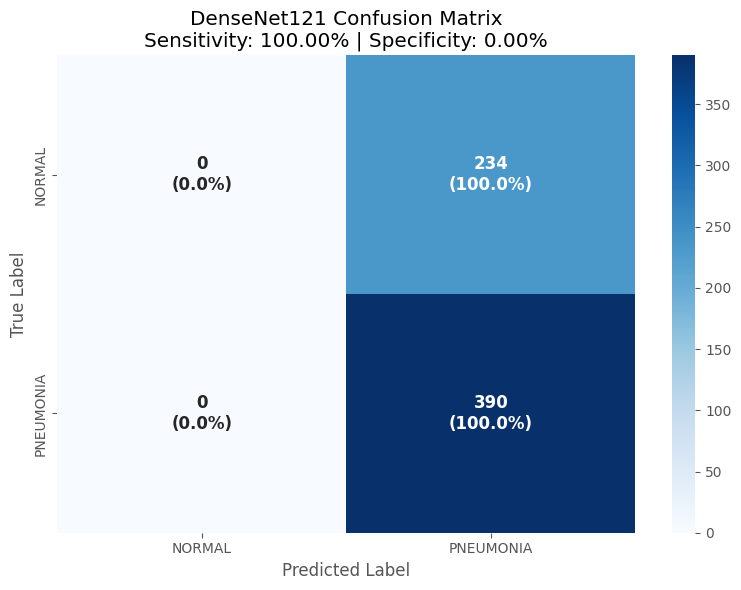

Model size: 7.26 MB
Accuracy: 0.6250
Sensitivity: 1.0000
Specificity: 0.0000
Precision (Pneumonia): 0.6250
F1-Score (Pneumonia): 0.7692
AUC: 0.7872

Evaluating quantized InceptionV3...
Found 624 images belonging to 2 classes.


Evaluating InceptionV3: 100%|██████████| 624/624 [01:32<00:00,  6.73it/s]



Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9309    0.8632    0.8958       234
   PNEUMONIA     0.9214    0.9615    0.9410       390

    accuracy                         0.9247       624
   macro avg     0.9261    0.9124    0.9184       624
weighted avg     0.9249    0.9247    0.9241       624



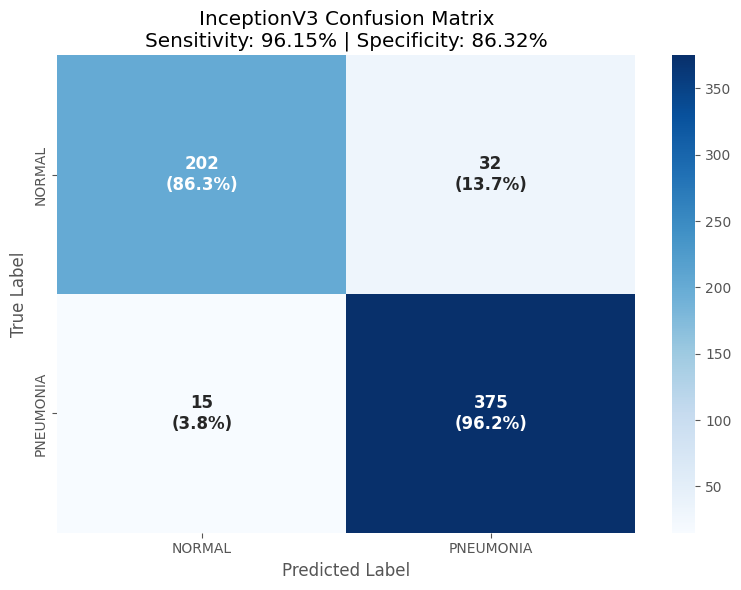

Model size: 21.77 MB
Accuracy: 0.9247
Sensitivity: 0.9615
Specificity: 0.8632
Precision (Pneumonia): 0.9214
F1-Score (Pneumonia): 0.9410
AUC: 0.9817

Evaluating quantized Xception...
Found 624 images belonging to 2 classes.


Evaluating Xception: 100%|██████████| 624/624 [02:19<00:00,  4.46it/s]


Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9615    0.9615    0.9615       234
   PNEUMONIA     0.9769    0.9769    0.9769       390

    accuracy                         0.9712       624
   macro avg     0.9692    0.9692    0.9692       624
weighted avg     0.9712    0.9712    0.9712       624



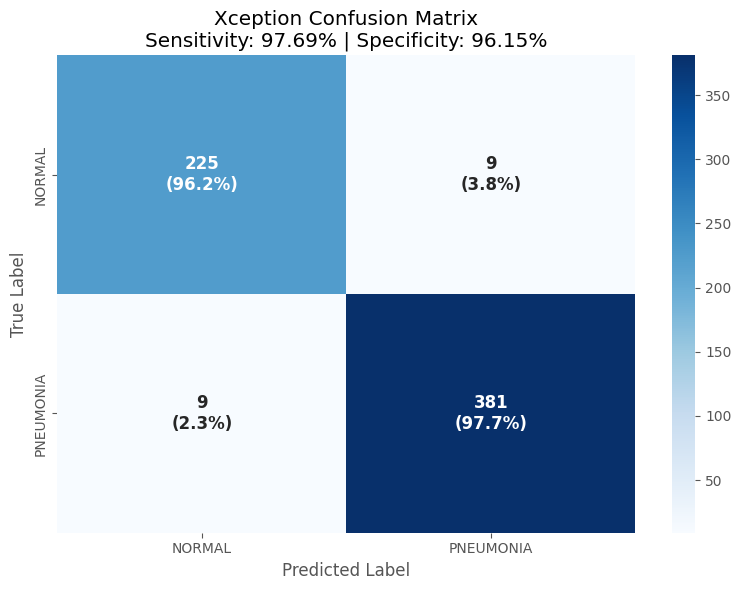

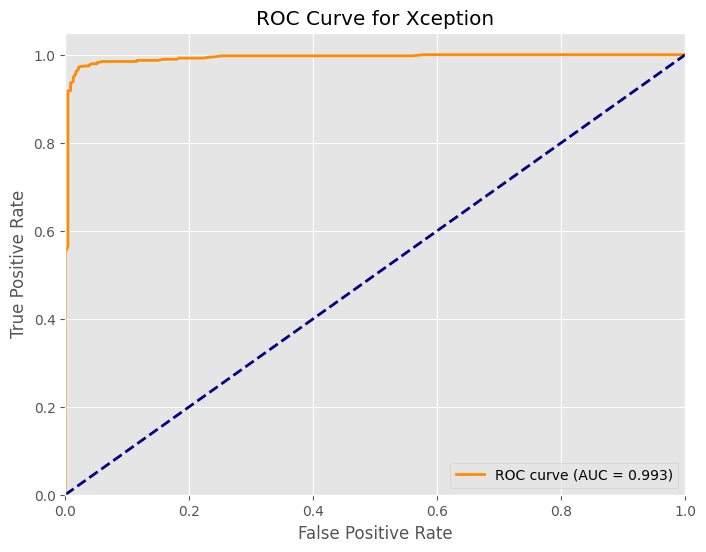

Model size: 21.61 MB
Accuracy: 0.9712
Sensitivity: 0.9769
Specificity: 0.9615
Precision (Pneumonia): 0.9769
F1-Score (Pneumonia): 0.9769
AUC: 0.9934

Evaluating quantized MobileNetV2...
Found 624 images belonging to 2 classes.


Evaluating MobileNetV2: 100%|██████████| 624/624 [00:13<00:00, 47.30it/s]



Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9234    0.8761    0.8991       234
   PNEUMONIA     0.9279    0.9564    0.9419       390

    accuracy                         0.9263       624
   macro avg     0.9256    0.9162    0.9205       624
weighted avg     0.9262    0.9263    0.9259       624



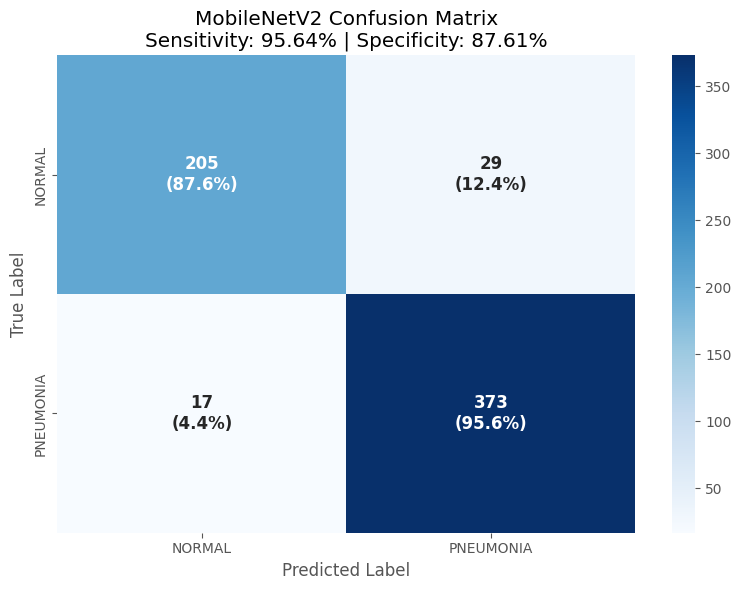

Model size: 2.90 MB
Accuracy: 0.9263
Sensitivity: 0.9564
Specificity: 0.8761
Precision (Pneumonia): 0.9279
F1-Score (Pneumonia): 0.9419
AUC: 0.9789

Quantized Model Performance Summary:
Model                 Size (MB) Accuracy  Sensitivity  Specificity  Precision   F1-Score      AUC
-------------------------------------------------------------------------------------------------
ResNet18                  23.62   0.9199       0.8897       0.9701     0.9802     0.9328   0.9876
DenseNet121                7.26   0.6250       1.0000       0.0000     0.6250     0.7692   0.7872
InceptionV3               21.77   0.9247       0.9615       0.8632     0.9214     0.9410   0.9817
Xception                  21.61   0.9712       0.9769       0.9615     0.9769     0.9769   0.9934
MobileNetV2                2.90   0.9263       0.9564       0.8761     0.9279     0.9419   0.9789

Individual model evaluation complete!


In [ ]:
# INDIVIDUAL QUANTISED MODEL EVALUATION

import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report

print("\nEvaluating individual quantized models...")

# Load quantized models as TFLite interpreters
quantized_interpreters = {}
model_sizes = {}
for i, config in enumerate(model_configs):
    model_path = os.path.join(QUANT_DIR, f"base_model_{i}_int8.tflite")
    if not os.path.exists(model_path):
        print(f"Quantized model not found for {config['name']}")
        continue
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    quantized_interpreters[config['name']] = interpreter
    model_sizes[config['name']] = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Loaded quantized {config['name']} ({model_sizes[config['name']]:.2f} MB)")

# Load quantized meta-learner
meta_path = os.path.join(QUANT_DIR, "meta_learner_int8.tflite")
if not os.path.exists(meta_path):
    print(f"Quantized meta-learner not found at {meta_path}")
    meta_interpreter = None
else:
    meta_interpreter = tf.lite.Interpreter(model_path=meta_path)
    meta_interpreter.allocate_tensors()
    meta_size = os.path.getsize(meta_path) / (1024 * 1024)
    print(f"Loaded quantized meta-learner ({meta_size:.2f} MB)")

# Load optimal weights
weights_path = os.path.join(QUANT_DIR, "optimal_weights.npy")
if not os.path.exists(weights_path):
    print(f"Optimal weights not found at {weights_path}")
    optimal_weights = None
else:
    optimal_weights = np.load(weights_path)
    print("Loaded optimal weights")

# Function to plot enhanced confusion matrix
def plot_confusion_matrix(cm, title):
    """Plot confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    class_totals = cm.sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_matrix = np.round((cm.astype(float) / class_totals.reshape(-1, 1)) * 100, 1)
    percentage_matrix = np.nan_to_num(percentage_matrix)
    annot_matrix = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({percentage_matrix[i, j]}%)"
            row.append(text)
        annot_matrix.append(row)
    heatmap = sns.heatmap(
        cm,
        annot=np.array(annot_matrix),
        fmt='',
        cmap='Blues',
        xticklabels=['NORMAL', 'PNEUMONIA'],
        yticklabels=['NORMAL', 'PNEUMONIA'],
        annot_kws={'fontweight': 'bold', 'fontsize': 12}
    )
    for text in heatmap.texts:
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Evaluation function with ROC for Xception
def evaluate_quantized_model_with_roc(interpreter, test_generator, model_name):
    """Evaluate a quantized model with ROC for Xception"""
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    y_true = []
    y_pred = []
    y_scores = []
    test_generator.reset()
    for _ in tqdm(range(len(test_generator)), desc=f"Evaluating {model_name}"):
        image, label = next(test_generator)
        y_true.append(np.argmax(label[0]))
        interpreter.set_tensor(input_details['index'], image.astype(np.float32))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])
        y_scores.append(output[0][1])
        y_pred.append(np.argmax(output[0]))

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_pneumonia = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_pneumonia = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    auc_score = roc_auc_score(y_true, y_scores)

    # Print classification report with 4 significant figures
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=['NORMAL', 'PNEUMONIA'],
        digits=4
    ))

    # Plot confusion matrix with sensitivity and specificity
    plot_confusion_matrix(cm, f"{model_name} Confusion Matrix\nSensitivity: {sensitivity*100:.2f}% | Specificity: {specificity*100:.2f}%")

    # Plot ROC curve only for Xception
    if model_name == 'Xception':
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pneumonia': precision_pneumonia,
        'f1_pneumonia': f1_pneumonia,
        'auc': auc_score,
        'confusion_matrix': cm
    }

# Evaluate individual quantized models
quantized_metrics = []
for model_name, interpreter in quantized_interpreters.items():
    print(f"\nEvaluating quantized {model_name}...")
    config = next(cfg for cfg in model_configs if cfg['name'] == model_name)
    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )
    test_generator = test_gen.flow_from_directory(
        TEST_PATH,
        target_size=config['target_size'],
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )
    metrics = evaluate_quantized_model_with_roc(interpreter, test_generator, model_name)
    metrics['name'] = model_name
    quantized_metrics.append(metrics)
    print(f"Model size: {model_sizes[model_name]:.2f} MB")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"Precision (Pneumonia): {metrics['precision_pneumonia']:.4f}")
    print(f"F1-Score (Pneumonia): {metrics['f1_pneumonia']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

# Print summary table
print("\nQuantized Model Performance Summary:")
header = f"{'Model':<20} {'Size (MB)':>10} {'Accuracy':>8} {'Sensitivity':>12} {'Specificity':>12} {'Precision':>10} {'F1-Score':>10} {'AUC':>8}"
print(header)
print('-' * len(header))
for metrics in quantized_metrics:
    size = model_sizes[metrics['name']]
    print(f"{metrics['name']:<20} {size:>10.2f} {metrics['accuracy']:>8.4f} {metrics['sensitivity']:>12.4f} "
          f"{metrics['specificity']:>12.4f} {metrics['precision_pneumonia']:>10.4f} "
          f"{metrics['f1_pneumonia']:>10.4f} {metrics['auc']:>8.4f}")

print("\nIndividual model evaluation complete!")

##  **EVALUATION OF ENSEMBLE MODEL**

- Performance-Weighted Ensemble is the best from 3 different options as shown below.


Evaluating alternative ensemble approaches...
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


ResNet18: 100%|██████████| 624/624 [01:06<00:00,  9.42it/s]

Found 624 images belonging to 2 classes.



DenseNet121: 100%|██████████| 624/624 [00:54<00:00, 11.35it/s]

Found 624 images belonging to 2 classes.



InceptionV3: 100%|██████████| 624/624 [01:32<00:00,  6.74it/s]

Found 624 images belonging to 2 classes.



Xception: 100%|██████████| 624/624 [02:20<00:00,  4.44it/s]

Found 624 images belonging to 2 classes.



MobileNetV2: 100%|██████████| 624/624 [00:13<00:00, 46.94it/s]



Evaluating Majority Voting Ensemble...

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9643    0.9231    0.9432       234
   PNEUMONIA     0.9550    0.9795    0.9671       390

    accuracy                         0.9583       624
   macro avg     0.9596    0.9513    0.9552       624
weighted avg     0.9585    0.9583    0.9581       624



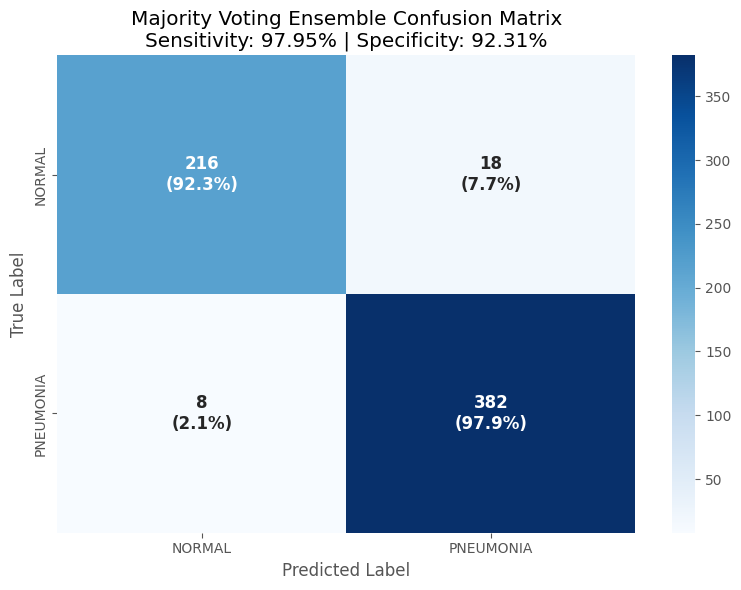

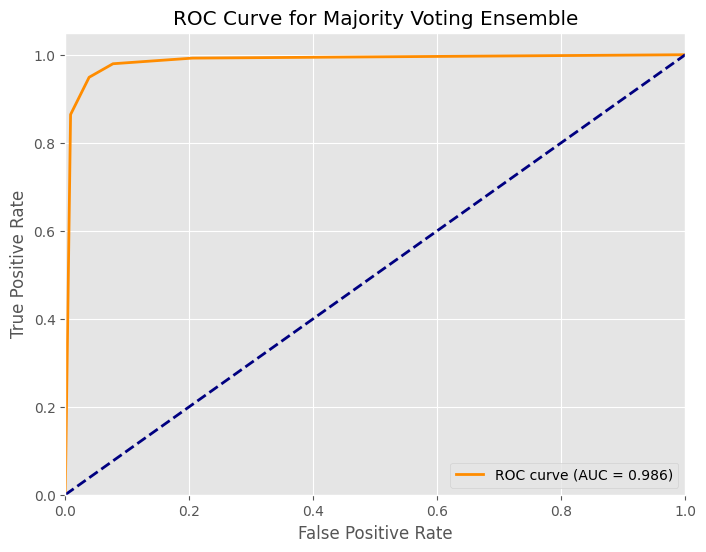


Evaluating AUC-Weighted Ensemble...

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9602    0.9274    0.9435       234
   PNEUMONIA     0.9573    0.9769    0.9670       390

    accuracy                         0.9583       624
   macro avg     0.9587    0.9521    0.9552       624
weighted avg     0.9584    0.9583    0.9582       624



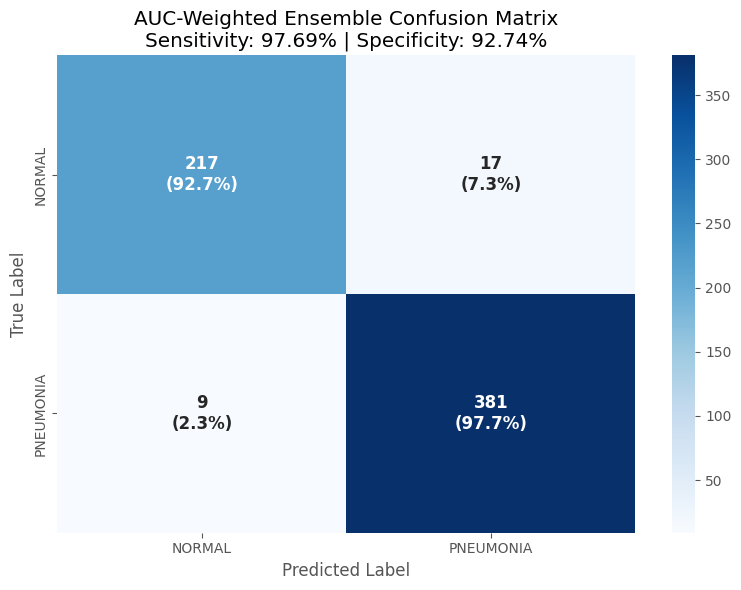

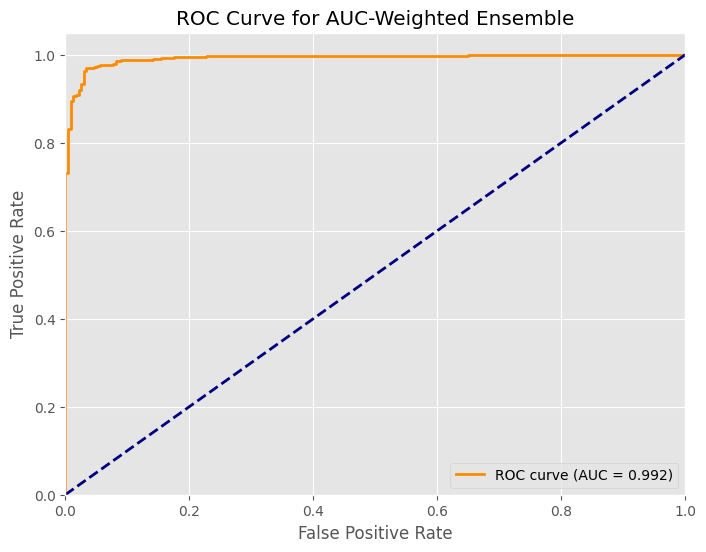


Evaluating Performance-Weighted Ensemble...

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9604    0.9316    0.9458       234
   PNEUMONIA     0.9597    0.9769    0.9682       390

    accuracy                         0.9599       624
   macro avg     0.9600    0.9543    0.9570       624
weighted avg     0.9599    0.9599    0.9598       624



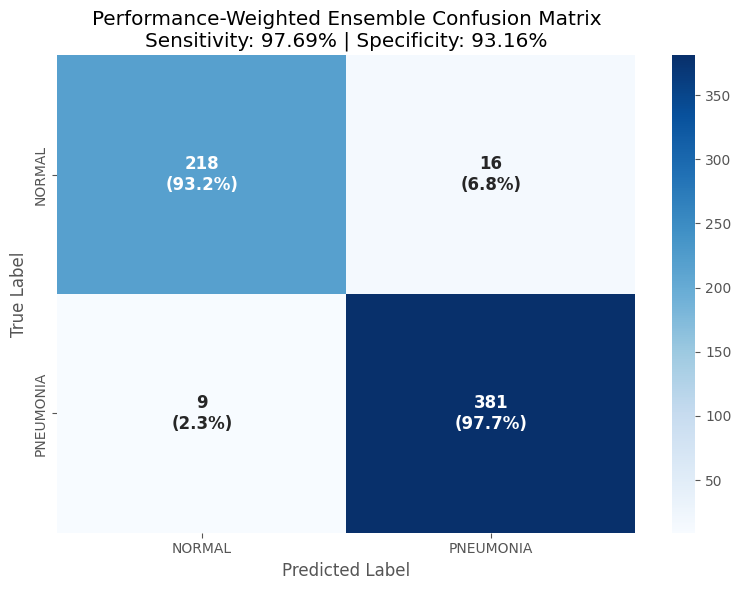

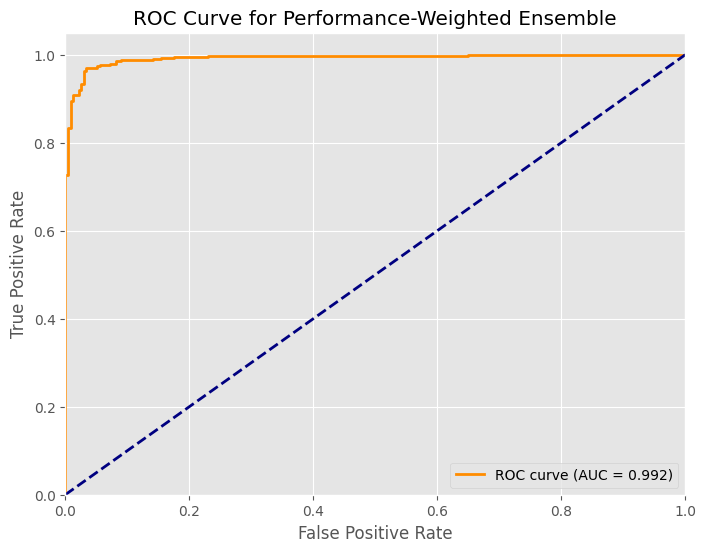


Ensemble Method Comparison (Model Size: 77.17 MB):
Method                         Accuracy  Sensitivity  Specificity  Precision   F1-Score      AUC
------------------------------------------------------------------------------------------------
Majority Voting                  0.9583       0.9795       0.9231     0.9550     0.9671   0.9861
AUC-Weighted                     0.9583       0.9769       0.9274     0.9573     0.9670   0.9925
Performance-Weighted             0.9599       0.9769       0.9316     0.9597     0.9682   0.9925

Note: All ensemble methods use the same base models
Total model size for all base models: 77.17 MB

Alternative ensemble evaluation complete!


In [ ]:
# ENSEMBLE EVALUATION

print("\nEvaluating alternative ensemble approaches...")

# Individual model metrics from evaluation
model_metrics = {}
for metrics in quantized_metrics:
    model_metrics[metrics['name']] = {
        'accuracy': metrics['accuracy'],
        'sensitivity': metrics['sensitivity'],
        'specificity': metrics['specificity'],
        'precision_pneumonia': metrics['precision_pneumonia'],
        'f1_pneumonia': metrics['f1_pneumonia'],
        'auc': metrics['auc']
    }

# Create test generator
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_gen.flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
n_test = len(test_generator)

# Get true labels
y_true = []
test_generator.reset()
for i in range(n_test):
    _, label = next(test_generator)
    y_true.append(np.argmax(label[0]))

# Store base model predictions
all_base_preds = {model_name: [] for model_name in model_metrics.keys()}
all_base_class_preds = {model_name: [] for model_name in model_metrics.keys()}

# Collect predictions from all base models
for model_name, interpreter in quantized_interpreters.items():
    print(f"Collecting predictions for {model_name}...")
    config = next(cfg for cfg in model_configs if cfg['name'] == model_name)
    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=config['preprocess_func']
    )
    test_generator = test_gen.flow_from_directory(
        TEST_PATH,
        target_size=config['target_size'],
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    for i in tqdm(range(n_test), desc=model_name):
        image, _ = next(test_generator)
        interpreter.set_tensor(input_details['index'], image.astype(np.float32))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])[0]
        all_base_preds[model_name].append(output)
        all_base_class_preds[model_name].append(np.argmax(output))

# Convert to arrays
for model_name in all_base_preds.keys():
    all_base_preds[model_name] = np.array(all_base_preds[model_name])
    all_base_class_preds[model_name] = np.array(all_base_class_preds[model_name])

# Helper function for standard evaluation
def evaluate_ensemble(y_pred, y_score, method_name):
    """Standard evaluation for ensemble methods"""
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_pneumonia = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_pneumonia = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_score)

    # Print classification report with 4 significant figures
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=['NORMAL', 'PNEUMONIA'],
        digits=4
    ))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    class_totals = cm.sum(axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_matrix = np.round((cm.astype(float) / class_totals.reshape(-1, 1)) * 100, 1)
    percentage_matrix = np.nan_to_num(percentage_matrix)
    annot_matrix = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({percentage_matrix[i, j]}%)"
            row.append(text)
        annot_matrix.append(row)
    heatmap = sns.heatmap(
        cm,
        annot=np.array(annot_matrix),
        fmt='',
        cmap='Blues',
        xticklabels=['NORMAL', 'PNEUMONIA'],
        yticklabels=['NORMAL', 'PNEUMONIA'],
        annot_kws={'fontweight': 'bold', 'fontsize': 12}
    )
    for text in heatmap.texts:
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    # Updated title with sensitivity and specificity instead of accuracy
    plt.title(f"{method_name} Confusion Matrix\nSensitivity: {sensitivity*100:.2f}% | Specificity: {specificity*100:.2f}%")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(QUANT_DIR, f'{method_name.replace(" ", "_")}_cm.png'))
    plt.show()

    # Plot individual ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {method_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(QUANT_DIR, f'{method_name.replace(" ", "_")}_roc.png'))
    plt.show()

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pneumonia': precision_pneumonia,
        'f1_pneumonia': f1_pneumonia,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# Method 1: Majority Voting (Standard Research Approach)
print("\nEvaluating Majority Voting Ensemble...")
mv_pred = []
mv_scores = []  # Proportion of models predicting pneumonia
for i in range(n_test):
    votes = [all_base_class_preds[model_name][i] for model_name in model_metrics.keys()]
    pneumonia_count = sum(votes)
    mv_pred.append(1 if pneumonia_count > len(votes)/2 else 0)
    mv_scores.append(pneumonia_count / len(votes))

mv_metrics = evaluate_ensemble(mv_pred, mv_scores, "Majority Voting Ensemble")

# Method 2: AUC-Weighted Voting (Standard Approach)
print("\nEvaluating AUC-Weighted Ensemble...")
# Create weights based on AUC scores (normalized)
auc_weights = {model: model_metrics[model]['auc'] for model in model_metrics}
total_auc = sum(auc_weights.values())
auc_weights = {model: weight / total_auc for model, weight in auc_weights.items()}

# Apply weights to probability vectors
weighted_preds = np.zeros((n_test, 2))
for model_name in model_metrics.keys():
    weight = auc_weights[model_name]
    weighted_preds += all_base_preds[model_name] * weight

aucw_pred = np.argmax(weighted_preds, axis=1)
aucw_scores = weighted_preds[:, 1]  # Probability for pneumonia class
aucw_metrics = evaluate_ensemble(aucw_pred, aucw_scores, "AUC-Weighted Ensemble")

# Method 3: Performance-Weighted (Accuracy + F1)
print("\nEvaluating Performance-Weighted Ensemble...")
# Create weights based on composite performance score
perf_scores = {}
for model_name in model_metrics.keys():
    # Balanced weighting between accuracy and F1
    perf_scores[model_name] = (model_metrics[model_name]['accuracy'] +
                              model_metrics[model_name]['f1_pneumonia']) / 2

total_perf = sum(perf_scores.values())
perf_weights = {model: score / total_perf for model, score in perf_scores.items()}

# Apply weights
weighted_preds = np.zeros((n_test, 2))
for model_name in model_metrics.keys():
    weight = perf_weights[model_name]
    weighted_preds += all_base_preds[model_name] * weight

perfw_pred = np.argmax(weighted_preds, axis=1)
perfw_scores = weighted_preds[:, 1]  # Probability for pneumonia class
perfw_metrics = evaluate_ensemble(perfw_pred, perfw_scores, "Performance-Weighted Ensemble")

# Calculate total model size
total_model_size = sum(model_sizes.values())

# Print comparison with model size
print("\nEnsemble Method Comparison (Model Size: {:.2f} MB):".format(total_model_size))
header = f"{'Method':<30} {'Accuracy':>8} {'Sensitivity':>12} {'Specificity':>12} {'Precision':>10} {'F1-Score':>10} {'AUC':>8}"
print(header)
print('-' * len(header))

methods = {
    "Majority Voting": mv_metrics,
    "AUC-Weighted": aucw_metrics,
    "Performance-Weighted": perfw_metrics
}

for method_name, metrics in methods.items():
    print(f"{method_name:<30} {metrics['accuracy']:>8.4f} {metrics['sensitivity']:>12.4f} "
          f"{metrics['specificity']:>12.4f} {metrics['precision_pneumonia']:>10.4f} "
          f"{metrics['f1_pneumonia']:>10.4f} {metrics['roc_auc']:>8.4f}")

# Add note about model size
print("\nNote: All ensemble methods use the same base models")
print(f"Total model size for all base models: {total_model_size:.2f} MB")

print("\nAlternative ensemble evaluation complete!")

#### **Alternative 2**


Evaluating advanced ensemble techniques (Stacking and AdaBoost)...

Loading quantized models as TFLite interpreters...
Loaded quantized ResNet18 (23.62 MB)
Loaded quantized DenseNet121 (7.26 MB)
Loaded quantized InceptionV3 (21.77 MB)
Loaded quantized Xception (21.61 MB)
Loaded quantized MobileNetV2 (2.90 MB)
Loaded quantized meta-learner (0.02 MB)
Loaded optimal weights

Re-collecting quantized model metrics for self-containment...
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Quantized model metrics collected.
Found 624 images belonging to 2 classes.

Found 624 images belonging to 2 classes.


ResNet18: 100%|██████████| 624/624 [01:06<00:00,  9.38it/s]

Found 624 images belonging to 2 classes.



DenseNet121: 100%|██████████| 624/624 [00:55<00:00, 11.31it/s]

Found 624 images belonging to 2 classes.



InceptionV3: 100%|██████████| 624/624 [01:32<00:00,  6.75it/s]

Found 624 images belonging to 2 classes.



Xception: 100%|██████████| 624/624 [02:22<00:00,  4.38it/s]

Found 624 images belonging to 2 classes.



MobileNetV2: 100%|██████████| 624/624 [00:14<00:00, 44.15it/s]



Preparing dataset for advanced ensemble methods...
Found 5232 images belonging to 2 classes.


Found 5232 images belonging to 2 classes.


ResNet18: 100%|██████████| 5232/5232 [09:20<00:00,  9.34it/s]

Found 5232 images belonging to 2 classes.



DenseNet121: 100%|██████████| 5232/5232 [07:43<00:00, 11.29it/s]

Found 5232 images belonging to 2 classes.



InceptionV3: 100%|██████████| 5232/5232 [12:57<00:00,  6.73it/s]


Found 5232 images belonging to 2 classes.


Xception: 100%|██████████| 5232/5232 [19:44<00:00,  4.42it/s]

Found 5232 images belonging to 2 classes.



MobileNetV2: 100%|██████████| 5232/5232 [02:01<00:00, 43.17it/s]



Evaluating Majority Voting Ensemble...


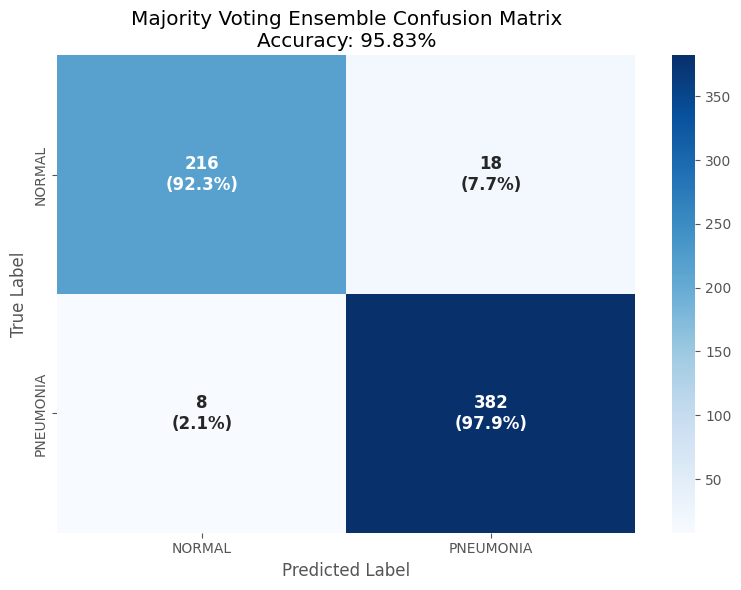

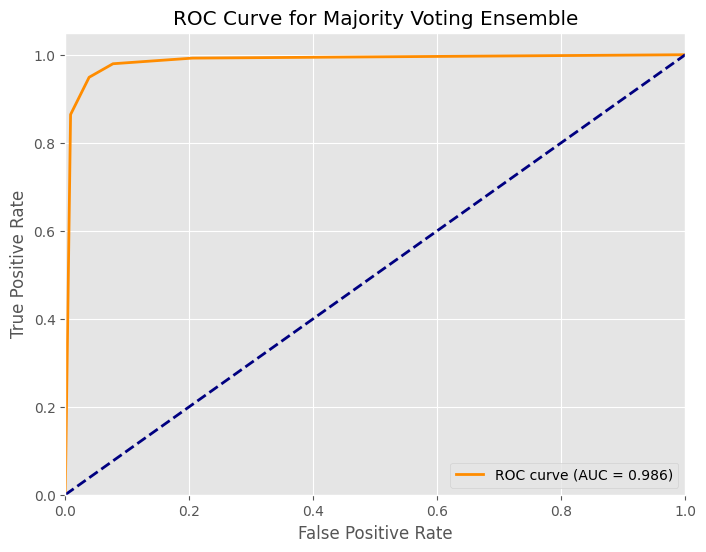


Evaluating AUC-Weighted Ensemble...


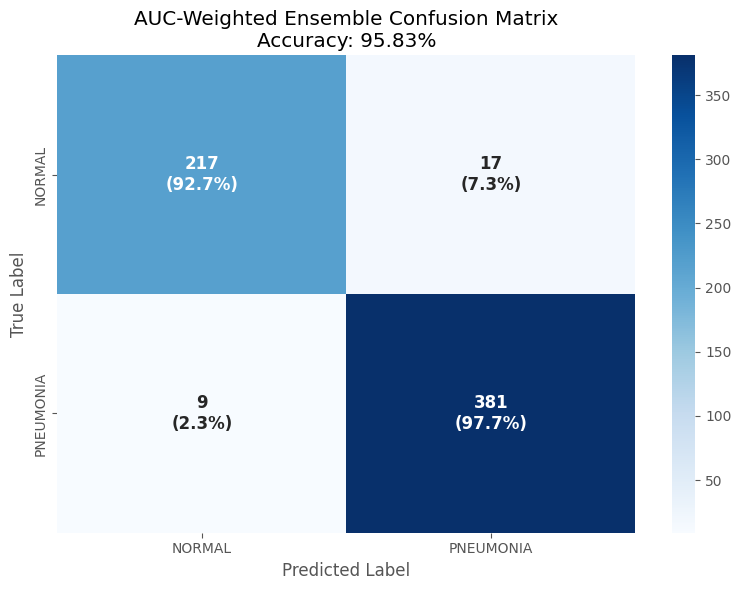

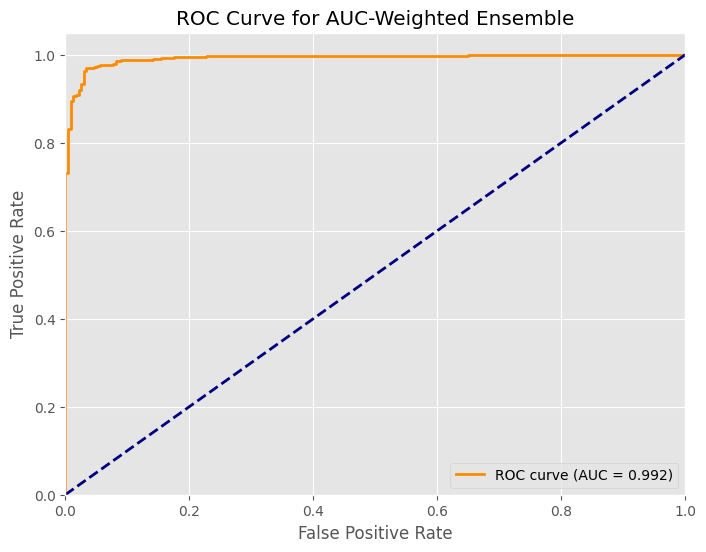


Evaluating Performance-Weighted Ensemble...


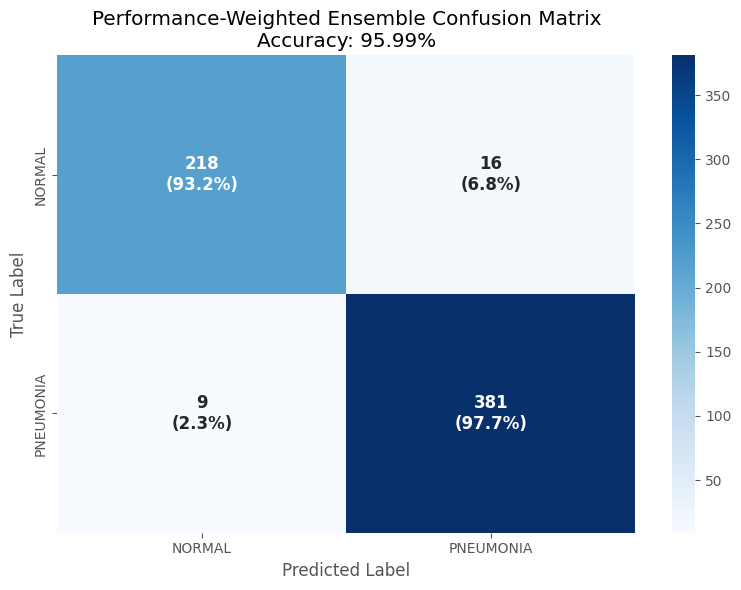

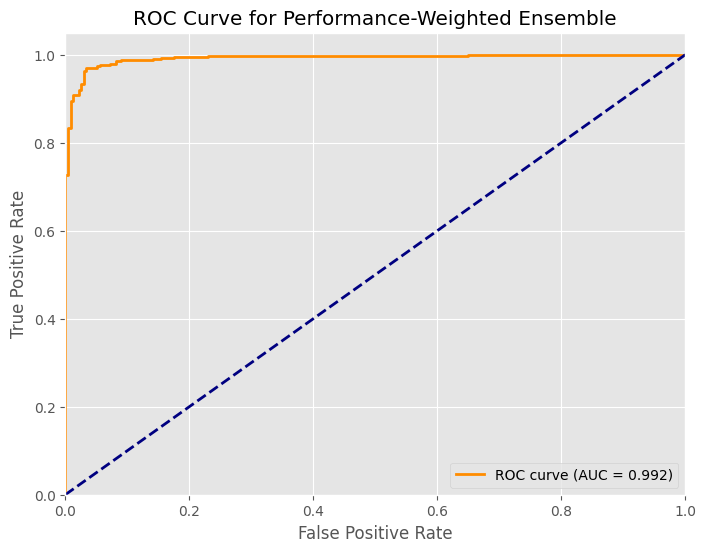


Evaluating Stacking Ensemble (Logistic Regression)...
Saved stacking model to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/stacking_lr.pkl


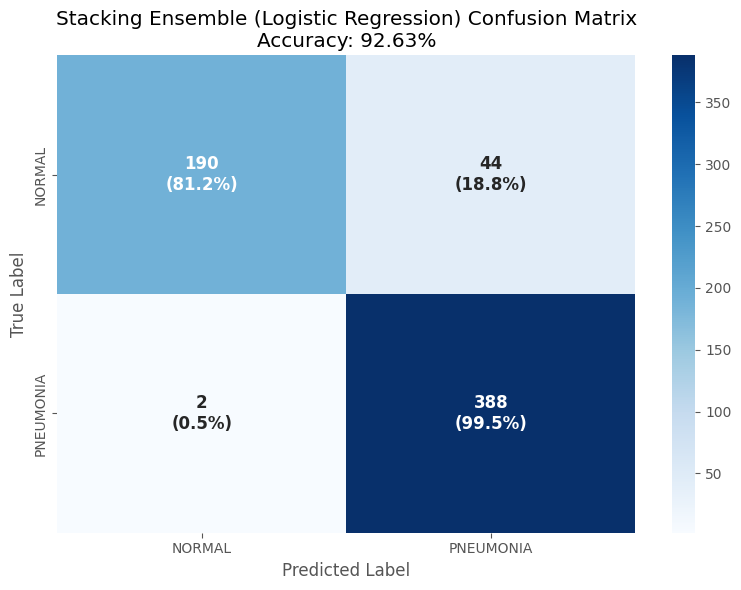

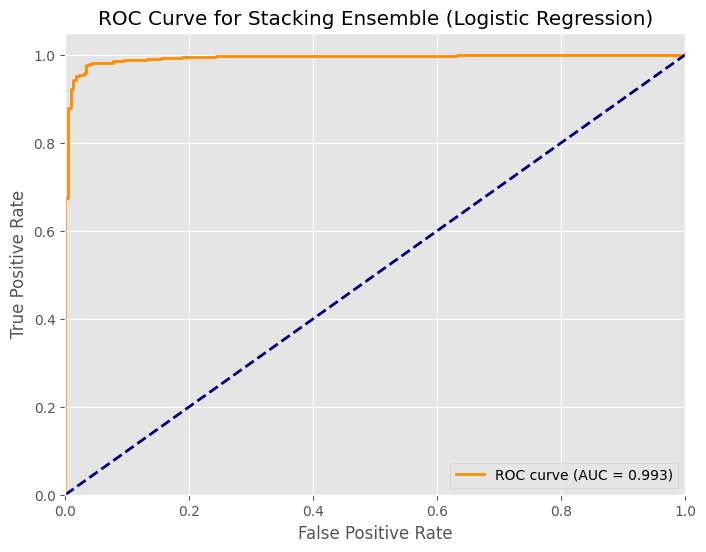


Evaluating AdaBoost Ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Saved AdaBoost model to /content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/adaboost.pkl


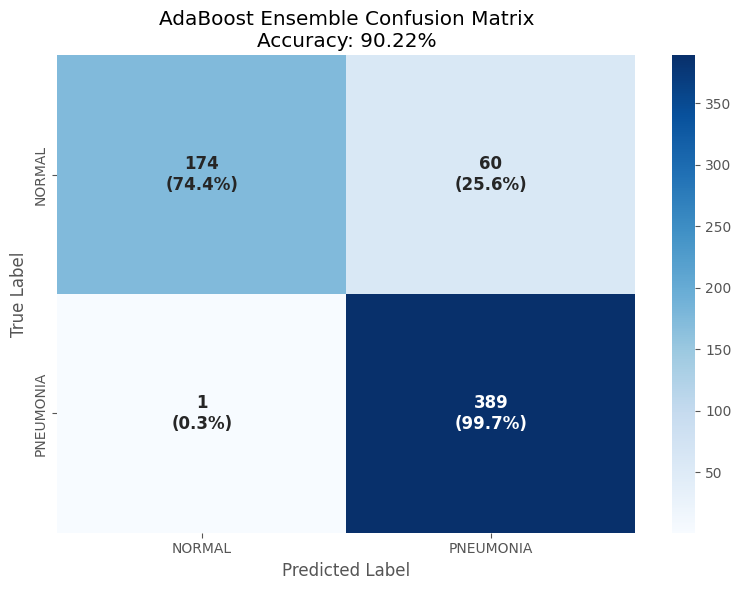

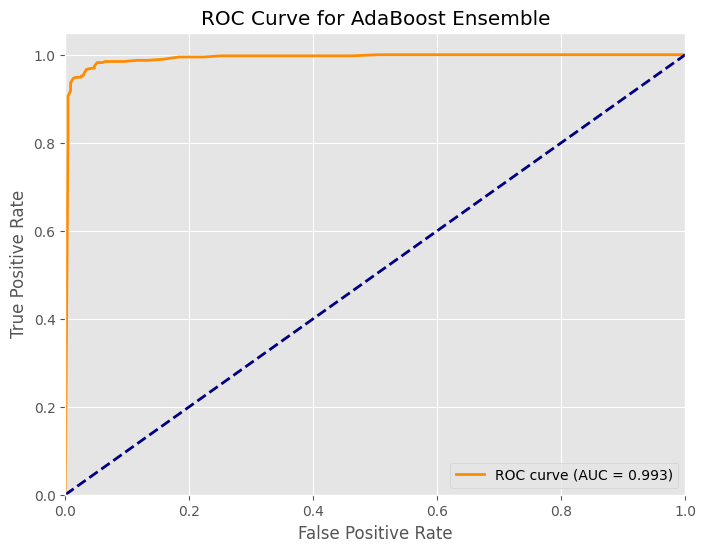


Comprehensive Ensemble Method Comparison:
Method                               Size (MB) Accuracy  Sensitivity  Specificity  Precision   F1-Score      AUC
----------------------------------------------------------------------------------------------------------------
Majority Voting                          77.17   0.9583       0.9795       0.9231     0.9550     0.9671   0.9861
AUC-Weighted                             77.17   0.9583       0.9769       0.9274     0.9573     0.9670   0.9925
Performance-Weighted                     77.17   0.9599       0.9769       0.9316     0.9597     0.9682   0.9925
Stacking (Logistic Regression)           77.17   0.9263       0.9949       0.8120     0.8981     0.9440   0.9934
AdaBoost                                 77.24   0.9022       0.9974       0.7436     0.8664     0.9273   0.9927


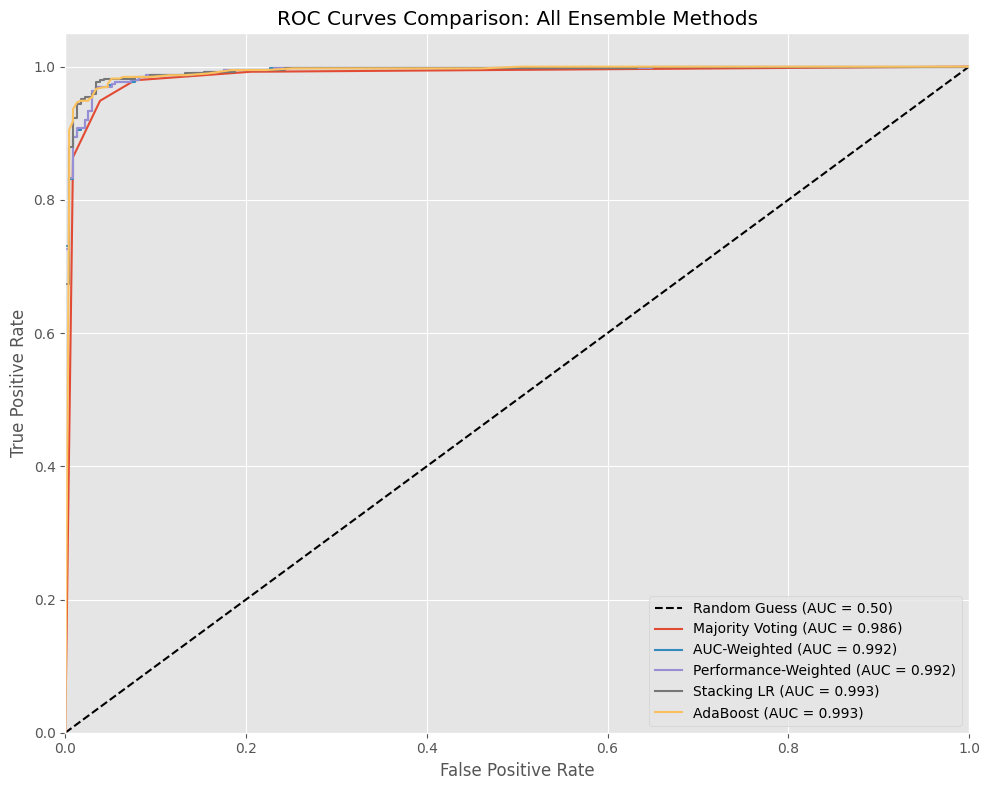


Advanced ensemble evaluation complete!


In [ ]:
# ===================================================================
# SECTION 5: ADVANCED ENSEMBLE TECHNIQUES (STACKING AND ADABOOST)
# ===================================================================

print("\nEvaluating advanced ensemble techniques (Stacking and AdaBoost)...")

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm # Import tqdm
import numpy as np
import os
import tensorflow as tf
import seaborn as sns

# Re-define necessary variables from previous sections for self-containment
# This ensures Section 5 can be run independently if needed.

# Assume model_configs and necessary paths are defined in previous cells
# If not, you would need to load models and define these here.

# --- Start: Code to load quantized interpreters (copied from Section 3) ---
print("\nLoading quantized models as TFLite interpreters...")
quantized_interpreters = {}
model_sizes = {}
QUANT_DIR = "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble" # Ensure QUANT_DIR is defined
model_configs = [ # Ensure model_configs is defined
    {'name': 'ResNet18', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.resnet.preprocess_input},
    {'name': 'DenseNet121', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.densenet.preprocess_input},
    {'name': 'InceptionV3', 'input_shape': (299, 299, 3), 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.inception_v3.preprocess_input},
    {'name': 'Xception', 'input_shape': (299, 299, 3), 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.xception.preprocess_input},
    {'name': 'MobileNetV2', 'input_shape': (224, 224, 3), 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input}
]

for i, config in enumerate(model_configs):
    model_path = os.path.join(QUANT_DIR, f"base_model_{i}_int8.tflite")
    if not os.path.exists(model_path):
        print(f"Quantized model not found for {config['name']} at {model_path}")
        continue
    try:
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        quantized_interpreters[config['name']] = interpreter
        model_sizes[config['name']] = os.path.getsize(model_path) / (1024 * 1024)
        print(f"Loaded quantized {config['name']} ({model_sizes[config['name']]:.2f} MB)")
    except Exception as e:
        print(f"Error loading interpreter for {config['name']}: {e}")

# Load quantized meta-learner
meta_path = os.path.join(QUANT_DIR, "meta_learner_int8.tflite")
if not os.path.exists(meta_path):
    print(f"Quantized meta-learner not found at {meta_path}")
    meta_interpreter = None
else:
    try:
        meta_interpreter = tf.lite.Interpreter(model_path=meta_path)
        meta_interpreter.allocate_tensors()
        meta_size = os.path.getsize(meta_path) / (1024 * 1024)
        print(f"Loaded quantized meta-learner ({meta_size:.2f} MB)")
    except Exception as e:
         print(f"Error loading meta-learner interpreter: {e}")
         meta_interpreter = None


# Load optimal weights
weights_path = os.path.join(QUANT_DIR, "optimal_weights.npy")
if not os.path.exists(weights_path):
    print(f"Optimal weights not found at {weights_path}")
    optimal_weights = None
else:
    try:
        optimal_weights = np.load(weights_path)
        print("Loaded optimal weights")
    except Exception as e:
        print(f"Error loading optimal weights: {e}")
        optimal_weights = None

# --- End: Code to load quantized interpreters ---


# Re-define quantized_metrics from evaluation (based on the loaded interpreters)
quantized_metrics = []
# Function to evaluate a quantized model (simplified for populating metrics)
def get_quantized_model_metrics(interpreter, test_generator, model_name):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    y_true_eval = []
    y_pred_eval = []
    y_scores_eval = []
    test_generator.reset()
    for _ in range(len(test_generator)): # No tqdm here to avoid re-printing
        image, label = next(test_generator)
        y_true_eval.append(np.argmax(label[0]))
        interpreter.set_tensor(input_details['index'], image.astype(np.float32))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])
        y_scores_eval.append(output[0][1])
        y_pred_eval.append(np.argmax(output[0]))

    accuracy = accuracy_score(y_true_eval, y_pred_eval)
    cm = confusion_matrix(y_true_eval, y_pred_eval)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_pneumonia = precision_score(y_true_eval, y_pred_eval, pos_label=1, zero_division=0)
    f1_pneumonia = f1_score(y_true_eval, y_pred_eval, pos_label=1, zero_division=0)
    auc_score = roc_auc_score(y_true_eval, y_scores_eval)

    return {
        'name': model_name,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision_pneumonia': precision_pneumonia,
        'f1_pneumonia': f1_pneumonia,
        'auc': auc_score,
        'confusion_matrix': cm
    }

# Populate quantized_metrics if interpreters are available
if quantized_interpreters: # Check if interpreters were loaded
    print("\nRe-collecting quantized model metrics for self-containment...")
    quantized_metrics = []
    for model_name, interpreter in quantized_interpreters.items():
        config = next(cfg for cfg in model_configs if cfg['name'] == model_name)
        temp_test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=config['preprocess_func']
        )
        temp_test_generator = temp_test_gen.flow_from_directory(
            TEST_PATH,
            target_size=config['target_size'],
            batch_size=1,
            class_mode='categorical',
            shuffle=False
        )
        metrics = get_quantized_model_metrics(interpreter, temp_test_generator, model_name)
        quantized_metrics.append(metrics)
    print("Quantized model metrics collected.")
else:
    print("\nQuantized interpreters not found. Cannot re-collect model metrics.")
    # If interpreters are not found, we cannot proceed with ensemble methods that rely on their predictions.
    # Add a clear message and potentially exit or skip the rest of the cell.
    print("Skipping advanced ensemble evaluation as quantized interpreters are not available.")
    # You might add a 'break' or 'sys.exit()' here if you want to stop execution.
    # For now, we'll just print the message and let subsequent code potentially fail
    # if it relies on quantized_metrics being fully populated.


model_metrics = {}
if quantized_metrics: # Only populate model_metrics if quantized_metrics is not empty
    for metrics in quantized_metrics:
        model_metrics[metrics['name']] = {
            'accuracy': metrics['accuracy'],
            'sensitivity': metrics['sensitivity'],
            'specificity': metrics['specificity'],
            'precision_pneumonia': metrics['precision_pneumonia'],
            'f1_pneumonia': metrics['f1_pneumonia'],
            'auc': metrics['auc']
        }

# Create test generator (needed for y_true)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_gen.flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
n_test = len(test_generator)

# Get true labels (needed for evaluation)
y_true = []
test_generator.reset()
for i in range(n_test):
    _, label = next(test_generator)
    y_true.append(np.argmax(label[0]))

# Store base model predictions for test set (re-collecting for self-containment)
all_base_preds = {model_name: [] for model_name in model_metrics.keys()}
all_base_class_preds = {model_name: [] for model_name in model_metrics.keys()}

# Collect predictions from all base models on test set
print("\nCollecting test predictions for base models...")
if quantized_interpreters: # Only collect predictions if interpreters are loaded
    for model_name, interpreter in quantized_interpreters.items():
        print(f"Collecting predictions for {model_name}...")
        config = next(cfg for cfg in model_configs if cfg['name'] == model_name)
        temp_test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=config['preprocess_func']
        )
        temp_test_generator = temp_test_gen.flow_from_directory(
            TEST_PATH,
            target_size=config['target_size'],
            batch_size=1,
            class_mode='categorical',
            shuffle=False
        )

        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]

        for i in tqdm(range(n_test), desc=model_name):
            image, _ = next(temp_test_generator)
            interpreter.set_tensor(input_details['index'], image.astype(np.float32))
            interpreter.invoke()
            output = interpreter.get_tensor(output_details['index'])[0]
            all_base_preds[model_name].append(output)
            all_base_class_preds[model_name].append(np.argmax(output))

# Convert test predictions to arrays
if all_base_preds and next(iter(all_base_preds.values())): # Check if predictions were collected
    for model_name in all_base_preds.keys():
        all_base_preds[model_name] = np.array(all_base_preds[model_name])
        all_base_class_preds[model_name] = np.array(all_base_class_preds[model_name])
else:
    print("No test predictions collected. Skipping ensemble evaluations.")
    # Add a condition here to skip the rest of the ensemble evaluation if no predictions were made.
    # For now, we'll let the code continue, which might result in subsequent errors if variables are empty.


print("\nPreparing dataset for advanced ensemble methods...")

# Get base model predictions for training set
X_train_meta = []
y_train_meta = []

# Create training generator (using training data)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator()
train_generator = train_gen.flow_from_directory(
    TRAIN_PATH,
    target_size=(299, 299),  # Use max size
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
n_train = len(train_generator)
y_meta_train = []
# Add tqdm to the loop for progress indication
for i in tqdm(range(n_train), desc="Collecting training labels"):
    _, label = next(train_generator)
    y_meta_train.append(np.argmax(label[0]))


# Collect base model predictions on training set ONCE
train_base_preds = {model_name: [] for model_name in model_metrics.keys()}

if quantized_interpreters: # Only collect training predictions if interpreters are loaded
    for model_name, interpreter in quantized_interpreters.items():
        print(f"Collecting training predictions for {model_name}...")
        config = next(cfg for cfg in model_configs if cfg['name'] == model_name)
        temp_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=config['preprocess_func']
        )
        temp_train_generator = temp_train_gen.flow_from_directory(
            TRAIN_PATH,
            target_size=config['target_size'],
            batch_size=1,
            class_mode='categorical',
            shuffle=False
        )

        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]

        for _ in tqdm(range(n_train), desc=model_name):
            image, _ = next(temp_train_generator)
            interpreter.set_tensor(input_details['index'], image.astype(np.float32))
            interpreter.invoke()
            output = interpreter.get_tensor(output_details['index'])[0]
            train_base_preds[model_name].append(output)

# Convert training predictions to array and stack
if train_base_preds and next(iter(train_base_preds.values())): # Check if training predictions were collected
    X_meta_train = []
    for i in range(n_train):
        sample_preds = []
        for model_name in model_metrics.keys():
            sample_preds.extend(train_base_preds[model_name][i])  # Full probability vectors
        X_meta_train.append(sample_preds)

    X_meta_train = np.array(X_meta_train)

    # Get base model predictions for test set (already collected in Section 4)
    X_meta_test = []
    for i in range(n_test):
        sample_preds = []
        for model_name in model_metrics.keys():
            sample_preds.extend(all_base_preds[model_name][i])  # Full probability vectors
        X_meta_test.append(sample_preds)

    X_meta_test = np.array(X_meta_test)


    # Helper function for standard evaluation
    def evaluate_ensemble(y_pred, y_score, method_name):
        """Standard evaluation for ensemble methods"""
        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision_pneumonia = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1_pneumonia = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_score)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        class_totals = cm.sum(axis=1)
        with np.errstate(divide='ignore', invalid='ignore'):
            percentage_matrix = np.round((cm.astype(float) / class_totals.reshape(-1, 1)) * 100, 1)
        percentage_matrix = np.nan_to_num(percentage_matrix)
        annot_matrix = []
        for i in range(cm.shape[0]):
            row = []
            for j in range(cm.shape[1]):
                text = f"{cm[i, j]}\n({percentage_matrix[i, j]}%)"
                row.append(text)
            annot_matrix.append(row)
        heatmap = sns.heatmap(
            cm,
            annot=np.array(annot_matrix),
            fmt='',
            cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'],
            annot_kws={'fontweight': 'bold', 'fontsize': 12}
        )
        for text in heatmap.texts:
            text.set_horizontalalignment('center')
            text.set_verticalalignment('center')
        plt.title(f"{method_name} Confusion Matrix\nAccuracy: {accuracy:.2%}")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(os.path.join(QUANT_DIR, f'{method_name.replace(" ", "_")}_cm.png'))
        plt.show()

        # Plot individual ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {method_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig(os.path.join(QUANT_DIR, f'{method_name.replace(" ", "_")}_roc.png'))
        plt.show()

        return {
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision_pneumonia': precision_pneumonia,
            'f1_pneumonia': f1_pneumonia,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        }

    # Method 1: Majority Voting (Standard Research Approach)
    print("\nEvaluating Majority Voting Ensemble...")
    mv_pred = []
    mv_scores = []  # Proportion of models predicting pneumonia
    for i in range(n_test):
        votes = [all_base_class_preds[model_name][i] for model_name in model_metrics.keys()]
        pneumonia_count = sum(votes)
        mv_pred.append(1 if pneumonia_count > len(votes)/2 else 0)
        mv_scores.append(pneumonia_count / len(votes))

    mv_metrics = evaluate_ensemble(mv_pred, mv_scores, "Majority Voting Ensemble")

    # Method 2: AUC-Weighted Voting (Standard Approach)
    print("\nEvaluating AUC-Weighted Ensemble...")
    # Create weights based on AUC scores (normalized)
    auc_weights = {model: model_metrics[model]['auc'] for model in model_metrics}
    total_auc = sum(auc_weights.values())
    auc_weights = {model: weight / total_auc for model, weight in auc_weights.items()}

    # Apply weights to probability vectors
    weighted_preds = np.zeros((n_test, 2))
    for model_name in model_metrics.keys():
        weight = auc_weights[model_name]
        weighted_preds += all_base_preds[model_name] * weight

    aucw_pred = np.argmax(weighted_preds, axis=1)
    aucw_scores = weighted_preds[:, 1]  # Probability for pneumonia class
    aucw_metrics = evaluate_ensemble(aucw_pred, aucw_scores, "AUC-Weighted Ensemble")

    # Method 3: Performance-Weighted (Accuracy + F1)
    print("\nEvaluating Performance-Weighted Ensemble...")
    # Create weights based on composite performance score
    perf_scores = {}
    for model_name in model_metrics.keys():
        # Balanced weighting between accuracy and F1
        perf_scores[model_name] = (model_metrics[model_name]['accuracy'] +
                                  model_metrics[model_name]['f1_pneumonia']) / 2

    total_perf = sum(perf_scores.values())
    perf_weights = {model: score / total_perf for model, score in perf_scores.items()}

    # Apply weights
    weighted_preds = np.zeros((n_test, 2))
    for model_name in model_metrics.keys():
        weight = perf_weights[model_name]
        weighted_preds += all_base_preds[model_name] * weight

    perfw_pred = np.argmax(weighted_preds, axis=1)
    perfw_scores = weighted_preds[:, 1]  # Probability for pneumonia class
    perfw_metrics = evaluate_ensemble(perfw_pred, perfw_scores, "Performance-Weighted Ensemble")

    # Method 4: Stacking with Logistic Regression
    print("\nEvaluating Stacking Ensemble (Logistic Regression)...")

    # Train meta-learner
    stacker = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
    stacker.fit(X_meta_train, y_meta_train)

    # Save the stacking model
    stacker_path = os.path.join(QUANT_DIR, "stacking_lr.pkl")
    joblib.dump(stacker, stacker_path)
    print(f"Saved stacking model to {stacker_path}")

    # Evaluate on test set
    stack_pred = stacker.predict(X_meta_test)
    stack_probs = stacker.predict_proba(X_meta_test)[:, 1]

    stack_metrics = evaluate_ensemble(stack_pred, stack_probs, "Stacking Ensemble (Logistic Regression)")

    # Method 5: AdaBoost Ensemble
    print("\nEvaluating AdaBoost Ensemble...")

    # Train AdaBoost classifier
    adaboost = AdaBoostClassifier(
        n_estimators=100,
        random_state=42,
        algorithm='SAMME'
    )
    adaboost.fit(X_meta_train, y_meta_train)

    # Save the AdaBoost model
    adaboost_path = os.path.join(QUANT_DIR, "adaboost.pkl")
    joblib.dump(adaboost, adaboost_path)
    print(f"Saved AdaBoost model to {adaboost_path}")

    # Evaluate on test set
    ada_pred = adaboost.predict(X_meta_test)
    ada_probs = adaboost.predict_proba(X_meta_test)[:, 1]

    ada_metrics = evaluate_ensemble(ada_pred, ada_probs, "AdaBoost Ensemble")

    # ===================================================================
    # COMPREHENSIVE ENSEMBLE COMPARISON
    # ===================================================================

    print("\nComprehensive Ensemble Method Comparison:")

    # Add model sizes for new methods
    stacker_size = os.path.getsize(stacker_path) / (1024 * 1024)
    adaboost_size = os.path.getsize(adaboost_path) / (1024 * 1024)

    # Print comparison with model size
    total_base_size = sum(model_sizes.values())
    header = f"{'Method':<35} {'Size (MB)':>10} {'Accuracy':>8} {'Sensitivity':>12} {'Specificity':>12} {'Precision':>10} {'F1-Score':>10} {'AUC':>8}"
    print(header)
    print('-' * len(header))

    methods = {
        "Majority Voting": (mv_metrics, 0),
        "AUC-Weighted": (aucw_metrics, 0),
        "Performance-Weighted": (perfw_metrics, 0),
        "Stacking (Logistic Regression)": (stack_metrics, stacker_size),
        "AdaBoost": (ada_metrics, adaboost_size)
    }

    for method_name, (metrics, meta_size) in methods.items():
        total_size = total_base_size + meta_size
        print(f"{method_name:<35} {total_size:>10.2f} {metrics['accuracy']:>8.4f} {metrics['sensitivity']:>12.4f} "
              f"{metrics['specificity']:>12.4f} {metrics['precision_pneumonia']:>10.4f} "
              f"{metrics['f1_pneumonia']:>10.4f} {metrics['roc_auc']:>8.4f}")

    # Final ROC comparison
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison: All Ensemble Methods')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot ROC for all methods
    fpr, tpr, _ = roc_curve(y_true, mv_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Majority Voting (AUC = {roc_auc:.3f})')

    fpr, tpr, _ = roc_curve(y_true, aucw_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC-Weighted (AUC = {roc_auc:.3f})')

    fpr, tpr, _ = roc_curve(y_true, perfw_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Performance-Weighted (AUC = {roc_auc:.3f})')

    fpr, tpr, _ = roc_curve(y_true, stack_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Stacking LR (AUC = {roc_auc:.3f})')

    fpr, tpr, _ = roc_curve(y_true, ada_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AdaBoost (AUC = {roc_auc:.3f})')

    # Finalize ROC plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(QUANT_DIR, 'all_ensembles_roc_comparison.png'))
    plt.show()

    print("\nAdvanced ensemble evaluation complete!")

else:
    print("Skipping ensemble evaluation due to missing quantized interpreters.")

------

# **SECTION B: Deployment Metrics Calculation**

------

In [ ]:
# Install required packages
!pip install tensorflow==2.16.1 pillow psutil --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.16.1 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.16.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.1 which is incompatible.


In [ ]:
## System Hardware Specifications
import psutil

cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")

CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB


### **Original Xception Model**

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import psutil

## System Hardware Specifications
print("-" * 50)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")
print("-" * 50)

# CONFIGURE COLAB TO MIMIC RASPBERRY PI 4 ENVIRONMENT

PI_CORES = 4        # Quad-core ARM Cortex-A72
PI_CPU_GHZ = 1.5     # 1.5GHz clock speed

print("Configuring Colab to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ}GHz clock speed behavior")

os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

try:
    current_ghz = psutil.cpu_freq().current / 1000
    clock_factor = current_ghz / PI_CPU_GHZ
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except:
    clock_factor = 1.5
    print("Using default clock speed factor: 1.50x")


# MODEL SIZE CALCULATION (ON-DISK FILE SIZE)

def get_model_size(path):
    """Return file size in MB"""
    if os.path.exists(path):
        size_bytes = os.path.getsize(path)
        return size_bytes / (1024 * 1024)
    return 0

# Path to the Xception model
MODEL_PATH = '/content/drive/MyDrive/chest_xray/base_model_3.keras'
model_size_mb = get_model_size(MODEL_PATH)
print(f"\nXception model file size: {model_size_mb:.2f} MB")


# PERFORMANCE MEASUREMENT FUNCTION FOR KERAS MODEL

def measure_performance_keras(model_path, test_dir):
    # Load Keras model
    print(f"Loading model: {os.path.basename(model_path)}")
    model = tf.keras.models.load_model(model_path)

    # Report actual on-disk model size
    model_size_mb = get_model_size(model_path)
    print(f"Model file size: {model_size_mb:.2f} MB")

    # Xception specific preprocessing and target size
    target_size = (299, 299)
    print(f"Input dimensions: {target_size[0]}x{target_size[1]} pixels")

    # Collect test images (25 from each class)
    image_paths = []
    for condition in ['NORMAL', 'PNEUMONIA']:
        condition_path = os.path.join(test_dir, condition)
        images = glob.glob(os.path.join(condition_path, '*.jpeg'))[:25]
        images += glob.glob(os.path.join(condition_path, '*.jpg'))[:25]
        image_paths.extend(images)

    print(f"Found {len(image_paths)} test images")

    # Prepare image function for Xception
    def prepare_image(path):
        img = Image.open(path).convert('RGB').resize(target_size)
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        # Apply Xception preprocessing
        img_array = tf.keras.applications.xception.preprocess_input(img_array)
        return img_array

    # Warm-up run
    model(prepare_image(image_paths[0]))

    # Measure inference times
    inference_times = []
    for img_path in image_paths:
        input_data = prepare_image(img_path)
        start = time.perf_counter()
        predictions = model(input_data)
        duration = (time.perf_counter() - start) * 1000  # ms
        # Apply clock speed adjustment
        inference_times.append(duration * clock_factor)

    # Calculate statistics
    mean_time = np.mean(inference_times)
    std_time = np.std(inference_times)

    return mean_time, std_time, len(image_paths), model_size_mb


# RUN MEASUREMENTS

TEST_DIR = '/content/drive/MyDrive/chest_xray/test'

print("\n" + "=" * 50)
print("Starting measurements with Pi-simulated environment")
print(f"Applied constraints: {PI_CORES} threads, {clock_factor:.2f}x clock adjustment")
print("=" * 50 + "\n")

mean_time, std_time, img_count, model_size_mb = measure_performance_keras(MODEL_PATH, TEST_DIR)

print("\n" + "=" * 50)
print("Performance Results - Original Xception Model:")
print("=" * 50)
print(f"Model: {os.path.basename(MODEL_PATH)}")
print(f"Model file size: {model_size_mb:.2f} MB")
print(f"Images processed: {img_count}")
print(f"Adjusted inference time: {mean_time:.2f} ± {std_time:.2f} ms")
print("=" * 50)

--------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
--------------------------------------------------
Configuring Colab to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5GHz clock speed behavior
Clock speed adjustment factor: 1.47x

Xception model file size: 82.06 MB

Starting measurements with Pi-simulated environment
Applied constraints: 4 threads, 1.47x clock adjustment

Loading model: base_model_3.keras
Model file size: 82.06 MB
Input dimensions: 299x299 pixels
Found 50 test images

Performance Results - Original Xception Model:
Model: base_model_3.keras
Model file size: 82.06 MB
Images processed: 50
Adjusted inference time: 1038.79 ± 205.36 ms


### **Original Ensemble Method (Nuclear Ensemble)**

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import psutil


## System Hardware Specifications
print("-" * 50)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")
print("-" * 50)

# CONFIGURE COLAB TO MIMIC RASPBERRY PI 4 ENVIRONMENT

PI_CORES = 4        # Quad-core ARM Cortex-A72
PI_CPU_GHZ = 1.5     # 1.5GHz clock speed

print("Configuring Colab to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ}GHz clock speed behavior")

os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

try:
    current_ghz = psutil.cpu_freq().current / 1000
    clock_factor = current_ghz / PI_CPU_GHZ
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except:
    clock_factor = 1.5
    print("Using default clock speed factor: 1.50x")


# MODEL CONFIGURATIONS AND LOADING

model_configs = [
    {'name': 'ResNet18', 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.resnet.preprocess_input},
    {'name': 'DenseNet121', 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.densenet.preprocess_input},
    {'name': 'InceptionV3', 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.inception_v3.preprocess_input},
    {'name': 'Xception', 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.xception.preprocess_input},
    {'name': 'MobileNetV2', 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input}
]

model_paths = [
    "/content/drive/MyDrive/chest_xray/base_model_0.keras",  # ResNet18
    "/content/drive/MyDrive/chest_xray/base_model_1.keras",  # DenseNet121
    "/content/drive/MyDrive/chest_xray/base_model_2.keras",  # InceptionV3
    "/content/drive/MyDrive/chest_xray/base_model_3.keras",  # Xception
    "/content/drive/MyDrive/chest_xray/base_model_4.keras"   # MobileNetV2
]
meta_learner_path = "/content/drive/MyDrive/chest_xray/nuclear_ensemble_meta_learner.keras"
optimal_weights_path = "/content/drive/MyDrive/chest_xray/Nuclear_ensemble_optimal_weights.npy"


# ACCURATE MODEL SIZE CALCULATION (ON-DISK FILE SIZES)

def get_model_size(path):
    """Return file size in MB"""
    if os.path.exists(path):
        size_bytes = os.path.getsize(path)
        return size_bytes / (1024 * 1024)
    return 0

base_model_sizes = [get_model_size(path) for path in model_paths]
meta_learner_size = get_model_size(meta_learner_path)
optimal_weights_size = get_model_size(optimal_weights_path)
total_size = sum(base_model_sizes) + meta_learner_size + optimal_weights_size

print("\nEnsemble Model Size Analysis:")
for i, size in enumerate(base_model_sizes):
    print(f"Base model {i} size: {size:.2f} MB")
print(f"Meta-learner size: {meta_learner_size:.2f} MB")
print(f"Optimal weights size: {optimal_weights_size:.5f} MB")
print(f"Total ensemble size: {total_size:.5f} MB")



# LOAD MODELS FOR INFERENCE

base_models = []
for i, path in enumerate(model_paths):
    try:
        model = tf.keras.models.load_model(path)
        base_models.append(model)
        print(f"Loaded base model {i} ({model_configs[i]['name']})")
    except Exception as e:
        print(f"Error loading base model {i}: {e}")
        base_models.append(None)

try:
    meta_model = tf.keras.models.load_model(meta_learner_path)
    print("Loaded meta-learner model")
except Exception as e:
    print(f"Error loading meta-learner: {e}")
    meta_model = None

try:
    optimal_weights = np.load(optimal_weights_path)
    print("Loaded optimal weights")
except Exception as e:
    print(f"Error loading weights: {e}")
    optimal_weights = None


# PERFORMANCE MEASUREMENT FUNCTION FOR ENSEMBLE

def measure_ensemble_performance(base_models, meta_model, optimal_weights, model_configs, test_dir):
    # Print actual total model size
    print(f"Total ensemble size (on disk): {total_size:.2f} MB")

    # Collect test images (25 from each class)
    image_paths = []
    for condition in ['NORMAL', 'PNEUMONIA']:
        condition_path = os.path.join(test_dir, condition)
        images = glob.glob(os.path.join(condition_path, '*.jpeg'))[:25]
        images += glob.glob(os.path.join(condition_path, '*.jpg'))[:25]
        image_paths.extend(images)
    print(f"Found {len(image_paths)} test images")

    def prepare_image_for_model(path, config):
        img = Image.open(path).convert('RGB').resize(config['target_size'])
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = config['preprocess_func'](img_array)
        return img_array

    # Warm-up run
    test_img = image_paths[0]
    base_predictions = []
    for i, (model, config) in enumerate(zip(base_models, model_configs)):
        if model is not None:
            input_data = prepare_image_for_model(test_img, config)
            pred = model(input_data)
            base_predictions.append(pred)
    if len(base_predictions) > 0 and meta_model is not None:
        meta_input = tf.stack(base_predictions, axis=1)
        meta_pred = meta_model(meta_input)

    inference_times = []
    for img_path in image_paths:
        start = time.perf_counter()
        base_preds = []
        for i, (model, config) in enumerate(zip(base_models, model_configs)):
            if model is not None:
                input_data = prepare_image_for_model(img_path, config)
                pred = model(input_data)
                base_preds.append(pred)
        if len(base_preds) > 0:
            if meta_model is not None and optimal_weights is not None:
                meta_input = tf.stack(base_preds, axis=1)
                meta_pred = meta_model(meta_input)
                weighted_pred = np.zeros_like(base_preds[0].numpy())
                for i, pred in enumerate(base_preds):
                    weighted_pred += pred.numpy() * optimal_weights[i]
                final_pred = 0.6 * meta_pred.numpy() + 0.4 * weighted_pred
        duration = (time.perf_counter() - start) * 1000  # ms
        inference_times.append(duration * clock_factor)

    mean_time = np.mean(inference_times)
    std_time = np.std(inference_times)

    return mean_time, std_time, len(image_paths)


# RUN MEASUREMENTS

TEST_DIR = '/content/drive/MyDrive/chest_xray/test'

print("\n" + "=" * 50)
print("Starting ensemble measurements with Pi-simulated environment")
print(f"Applied constraints: {PI_CORES} threads, {clock_factor:.2f}x clock adjustment")
print("=" * 50 + "\n")

mean_time, std_time, img_count = measure_ensemble_performance(
    base_models, meta_model, optimal_weights, model_configs, TEST_DIR
)

print("\n" + "=" * 50)
print("Performance Results - Original Nuclear Ensemble:")
print("=" * 50)
print(f"Ensemble: Nuclear Ensemble (5 base models + meta-learner)")
print(f"Images processed: {img_count}")
print(f"Adjusted inference time: {mean_time:.2f} ± {std_time:.2f} ms")
print("=" * 50)

--------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
--------------------------------------------------
Configuring Colab to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5GHz clock speed behavior
Clock speed adjustment factor: 1.47x

Ensemble Model Size Analysis:
Base model 0 size: 92.61 MB
Base model 1 size: 29.29 MB
Base model 2 size: 86.22 MB
Base model 3 size: 82.06 MB
Base model 4 size: 10.42 MB
Meta-learner size: 0.15 MB
Optimal weights size: 0.00016 MB
Total ensemble size: 300.74107 MB
Loaded base model 0 (ResNet18)
Loaded base model 1 (DenseNet121)
Loaded base model 2 (InceptionV3)
Loaded base model 3 (Xception)
Loaded base model 4 (MobileNetV2)
Loaded meta-learner model
Loaded optimal weights

Starting ensemble measurements with Pi-simulated environment
Applied constraints: 4 threads, 1.47x clock adjustment

Total ensemble size (on disk): 300.74 MB
Found 50 test images

Performance Results - Original Nu

### **INT8 Quantised Xception Model**

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import psutil


## System Hardware Specifications
print("-" * 50)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")
print("-" * 50)

# CONFIGURE COLAB TO MIMIC RASPBERRY PI 4 ENVIRONMENT

# Raspberry Pi 4 Specifications
PI_CORES = 4        # Quad-core ARM Cortex-A72
PI_CPU_GHZ = 1.5     # 1.5GHz clock speed

print("Configuring Colab to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ}GHz clock speed behavior")

# Set thread limits through environment variables
os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

# Calculate clock speed adjustment factor
try:
    current_ghz = psutil.cpu_freq().current / 1000
    clock_factor = current_ghz / PI_CPU_GHZ
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except:
    clock_factor = 1.5
    print("Using default clock speed factor: 1.50x")


# PERFORMANCE MEASUREMENT FUNCTION FOR QUANTIZED XCEPTION

def measure_performance_quantized_xception(tflite_model_path, test_dir):
    # Load model as bytes
    print(f"Loading model: {os.path.basename(tflite_model_path)}")
    with open(tflite_model_path, 'rb') as f:
        model_bytes = f.read()

    model_size_mb = len(model_bytes) / (1024 ** 2)
    print(f"Model size: {model_size_mb:.2f} MB")

    interpreter = tf.lite.Interpreter(model_content=model_bytes)
    interpreter.allocate_tensors()

    # Get input details
    input_details = interpreter.get_input_details()[0]
    input_shape = input_details['shape']
    height, width = input_shape[1], input_shape[2]
    print(f"Input dimensions: {width}x{height} pixels")

    # Collect test images (25 from each class)
    image_paths = []
    for condition in ['NORMAL', 'PNEUMONIA']:
        condition_path = os.path.join(test_dir, condition)
        images = glob.glob(os.path.join(condition_path, '*.jpeg'))[:25]
        images += glob.glob(os.path.join(condition_path, '*.jpg'))[:25]
        image_paths.extend(images)

    print(f"Found {len(image_paths)} test images")

    # Prepare image function for Xception (299x299 with specific preprocessing)
    def prepare_image(path):
        img = Image.open(path).convert('RGB').resize((299, 299))
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        # Apply Xception preprocessing
        img_array = tf.keras.applications.xception.preprocess_input(img_array)
        return img_array

    # Warm-up run
    interpreter.set_tensor(input_details['index'], prepare_image(image_paths[0]))
    interpreter.invoke()

    # Measure inference times
    inference_times = []
    for img_path in image_paths:
        input_data = prepare_image(img_path)

        start = time.perf_counter()
        interpreter.set_tensor(input_details['index'], input_data)
        interpreter.invoke()
        duration = (time.perf_counter() - start) * 1000  # ms

        # Apply clock speed adjustment
        inference_times.append(duration * clock_factor)

    # Calculate statistics
    mean_time = np.mean(inference_times)
    std_time = np.std(inference_times)

    return mean_time, std_time, len(image_paths)


# RUN MEASUREMENTS

# Configuration - Quantized Xception Model Path
MODEL_PATH = '/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_3_int8.tflite'
TEST_DIR = '/content/drive/MyDrive/chest_xray/test'

print("\n" + "=" * 50)
print("Starting measurements with Pi-simulated environment")
print(f"Applied constraints: {PI_CORES} threads, {clock_factor:.2f}x clock adjustment")
print("=" * 50 + "\n")

# Run measurements
mean_time, std_time, img_count = measure_performance_quantized_xception(MODEL_PATH, TEST_DIR)

# Print clean results
print("\n" + "=" * 50)
print("Performance Results - INT8 Quantized Xception Model:")
print("=" * 50)
print(f"Model: {os.path.basename(MODEL_PATH)}")
print(f"Images processed: {img_count}")
print(f"Adjusted inference time: {mean_time:.2f} ± {std_time:.2f} ms")
print("=" * 50)

--------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
--------------------------------------------------
Configuring Colab to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5GHz clock speed behavior
Clock speed adjustment factor: 1.47x

Starting measurements with Pi-simulated environment
Applied constraints: 4 threads, 1.47x clock adjustment

Loading model: base_model_3_int8.tflite
Model size: 21.61 MB
Input dimensions: 299x299 pixels
Found 50 test images

Performance Results - INT8 Quantized Xception Model:
Model: base_model_3_int8.tflite
Images processed: 50
Adjusted inference time: 550.76 ± 119.67 ms


### **INT8 Quantised Ensemble Model**

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import psutil

## System Hardware Specifications
print("-" * 50)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")
print("-" * 50)


# CONFIGURE COLAB TO MIMIC RASPBERRY PI 4 ENVIRONMENT

PI_CORES = 4        # Quad-core ARM Cortex-A72
PI_CPU_GHZ = 1.5     # 1.5GHz clock speed

print("Configuring Colab to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ}GHz clock speed behavior")

os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

try:
    current_ghz = psutil.cpu_freq().current / 1000
    clock_factor = current_ghz / PI_CPU_GHZ
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except:
    clock_factor = 1.5
    print("Using default clock speed factor: 1.50x")

# =====================================================
# MODEL CONFIGURATIONS AND LOADING
# =====================================================

model_configs = [
    {'name': 'ResNet18', 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.resnet.preprocess_input},
    {'name': 'DenseNet121', 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.densenet.preprocess_input},
    {'name': 'InceptionV3', 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.inception_v3.preprocess_input},
    {'name': 'Xception', 'target_size': (299, 299),
     'preprocess_func': tf.keras.applications.xception.preprocess_input},
    {'name': 'MobileNetV2', 'target_size': (224, 224),
     'preprocess_func': tf.keras.applications.mobilenet_v2.preprocess_input}
]

quantized_model_paths = [
    "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_0_int8.tflite",  # ResNet18
    "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_1_int8.tflite",  # DenseNet121
    "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_2_int8.tflite",  # InceptionV3
    "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_3_int8.tflite",  # Xception
    "/content/drive/MyDrive/chest_xray/PTQ_Quantized_Ensemble/base_model_4_int8.tflite"   # MobileNetV2
]

interpreters = []
total_size_mb = 0

for i, path in enumerate(quantized_model_paths):
    try:
        with open(path, 'rb') as f:
            model_bytes = f.read()
        interpreter = tf.lite.Interpreter(model_content=model_bytes)
        interpreter.allocate_tensors()
        interpreters.append(interpreter)
        model_size = len(model_bytes) / (1024 ** 2)
        total_size_mb += model_size
        print(f"Loaded quantized model {i} ({model_configs[i]['name']}): {model_size:.2f} MB")
    except Exception as e:
        print(f"Error loading quantized model {i}: {e}")
        interpreters.append(None)

print(f"Total quantized ensemble size: {total_size_mb:.2f} MB")


# BUILD model_metrics FROM YOUR EVALUATION

# quantized_metrics = [...] # Your evaluation results list of dicts

model_metrics = {}
for metrics in quantized_metrics:
    model_metrics[metrics['name']] = {
        'accuracy': metrics['accuracy'],
        'sensitivity': metrics['sensitivity'],
        'specificity': metrics['specificity'],
        'precision_pneumonia': metrics['precision_pneumonia'],
        'f1_pneumonia': metrics['f1_pneumonia'],
        'auc': metrics['auc']
    }


# PERFORMANCE WEIGHTS CALCULATION (Accuracy + F1)

print("\nCalculating performance weights...")
perf_scores = {}
for config in model_configs:
    name = config['name']
    # Use accuracy and F1-Score for pneumonia
    perf_scores[name] = (model_metrics[name]['accuracy'] + model_metrics[name]['f1_pneumonia']) / 2

total_perf = sum(perf_scores.values())
performance_weights = [perf_scores[config['name']] / total_perf for config in model_configs]
performance_weights = np.array(performance_weights)

print("Performance weights:")
for i, config in enumerate(model_configs):
    print(f"- {config['name']}: {performance_weights[i]:.4f}")


# PERFORMANCE MEASUREMENT FUNCTION FOR QUANTIZED ENSEMBLE

def measure_quantized_ensemble_performance(interpreters, model_configs, performance_weights, test_dir):
    print(f"Total ensemble size: {total_size_mb:.2f} MB")
    image_paths = []
    for condition in ['NORMAL', 'PNEUMONIA']:
        condition_path = os.path.join(test_dir, condition)
        images = glob.glob(os.path.join(condition_path, '*.jpeg'))[:25]
        images += glob.glob(os.path.join(condition_path, '*.jpg'))[:25]
        image_paths.extend(images)
    print(f"Found {len(image_paths)} test images")

    def prepare_image_for_model(path, config):
        img = Image.open(path).convert('RGB').resize(config['target_size'])
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = config['preprocess_func'](img_array)
        return img_array

    # Warm-up run
    test_img = image_paths[0]
    for i, (interpreter, config) in enumerate(zip(interpreters, model_configs)):
        if interpreter is not None:
            input_details = interpreter.get_input_details()[0]
            input_data = prepare_image_for_model(test_img, config)
            interpreter.set_tensor(input_details['index'], input_data)
            interpreter.invoke()

    inference_times = []
    for img_path in image_paths:
        start = time.perf_counter()
        predictions = []
        for i, (interpreter, config) in enumerate(zip(interpreters, model_configs)):
            if interpreter is not None:
                input_details = interpreter.get_input_details()[0]
                output_details = interpreter.get_output_details()[0]
                input_data = prepare_image_for_model(img_path, config)
                interpreter.set_tensor(input_details['index'], input_data)
                interpreter.invoke()
                prediction = interpreter.get_tensor(output_details['index'])
                predictions.append(prediction)
        if len(predictions) > 0:
            weighted_prediction = np.zeros_like(predictions[0])
            for i, pred in enumerate(predictions):
                weighted_prediction += pred * performance_weights[i]
        duration = (time.perf_counter() - start) * 1000  # ms
        inference_times.append(duration * clock_factor)

    mean_time = np.mean(inference_times)
    std_time = np.std(inference_times)

    return mean_time, std_time, len(image_paths)


# RUN MEASUREMENTS

TEST_DIR = '/content/drive/MyDrive/chest_xray/test'

print("\n" + "=" * 50)
print("Starting quantized ensemble measurements with Pi-simulated environment")
print(f"Applied constraints: {PI_CORES} threads, {clock_factor:.2f}x clock adjustment")
print("=" * 50 + "\n")

mean_time, std_time, img_count = measure_quantized_ensemble_performance(
    interpreters, model_configs, performance_weights, TEST_DIR
)

print("\n" + "=" * 50)
print("Performance Results - INT8 Quantized Performance-Weighted Ensemble:")
print("=" * 50)
print(f"Ensemble: Quantized Performance-Weighted Ensemble (5 quantized base models)")
print(f"Images processed: {img_count}")
print(f"Adjusted inference time: {mean_time:.2f} ± {std_time:.2f} ms")
print("=" * 50)

--------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
--------------------------------------------------
Configuring Colab to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5GHz clock speed behavior
Clock speed adjustment factor: 1.47x
Loaded quantized model 0 (ResNet18): 23.62 MB
Loaded quantized model 1 (DenseNet121): 7.26 MB
Loaded quantized model 2 (InceptionV3): 21.77 MB
Loaded quantized model 3 (Xception): 21.61 MB
Loaded quantized model 4 (MobileNetV2): 2.90 MB
Total quantized ensemble size: 77.17 MB

Calculating performance weights...
Performance weights:
- ResNet18: 0.2075
- DenseNet121: 0.1561
- InceptionV3: 0.2090
- Xception: 0.2182
- MobileNetV2: 0.2092

Starting quantized ensemble measurements with Pi-simulated environment
Applied constraints: 4 threads, 1.47x clock adjustment

Total ensemble size: 77.17 MB
Found 50 test images

Performance Results - INT8 Quantized Performance-Weighted Ensemble:
Ensemb

------
# **SECTION C: Grad-CAM Implementation**

-----

## **Full Grad-CAM**

#### **a. Pneumonia cases**

**Option 1**

Found 512 pneumonia images


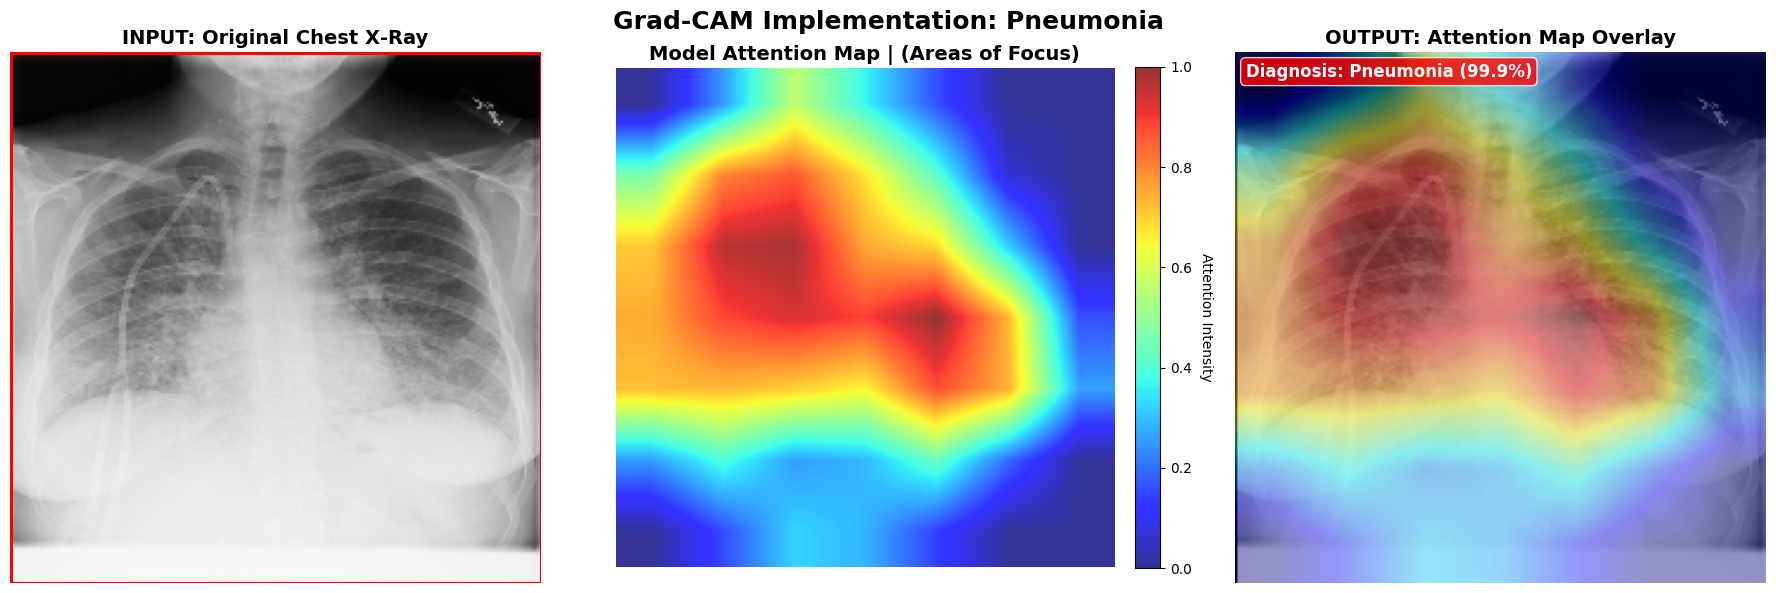

Attempt 1: 00016991_008.png | Pneumonia (99.9%) | raw score=0.9990
Pneumonia-positive image successfully visualized.


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import random
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

class PneumoniaGradCAM:
    """
    Grad-CAM implementation for visualizing pneumonia detection in chest X-rays.
    """
    def __init__(self, model_path):
        self.model = load_model(model_path)
        self.target_size = (224, 224)
        self.last_conv_layer = self._find_target_layer()
        self.grad_model = Model(
            inputs=self.model.inputs,
            outputs=[
                self.model.get_layer(self.last_conv_layer).output,
                self.model.output
            ]
        )

    def _find_target_layer(self):
        for layer in reversed(self.model.layers):
            if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
                return layer.name
        return 'top_conv'

    def prepare_image(self, img_path):
        # load & preprocess
        img = image.load_img(img_path, target_size=self.target_size)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, 0)
        arr = preprocess_input(arr)
        # original RGB for display
        orig = cv2.imread(img_path)
        orig = cv2.resize(orig, self.target_size)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        return arr, orig

    def compute_heatmap(self, img_array):
        with tf.GradientTape() as tape:
            conv_out, preds = self.grad_model(img_array)
            score = preds[:, 0]
        grads = tape.gradient(score, conv_out)
        pooled = tf.reduce_mean(grads, axis=(0,1,2))
        conv = conv_out[0]
        heatmap = conv @ pooled[..., tf.newaxis]
        heatmap = tf.squeeze(tf.maximum(heatmap, 0))
        heatmap = cv2.resize(heatmap.numpy(), self.target_size)
        if np.max(heatmap) > 0:
            heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
        return heatmap

    def create_overlay(self, orig, heatmap, alpha=0.4):
        hm_col = cv2.applyColorMap((heatmap*255).astype('uint8'),
                                  cv2.COLORMAP_JET)
        hm_col = cv2.cvtColor(hm_col, cv2.COLOR_BGR2RGB)
        overlay = hm_col * alpha + orig * (1 - alpha)
        return overlay.astype('uint8')

    def analyze_xray(self, img_path):
        arr, orig = self.prepare_image(img_path)
        raw_score = self.model.predict(arr, verbose=0)[0][0]
        label = "Pneumonia" if raw_score > 0.5 else "Normal"
        confidence = (raw_score if raw_score > 0.5 else 1 - raw_score) * 100

        heatmap = self.compute_heatmap(arr)
        overlay = self.create_overlay(orig, heatmap)

        # presentation:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Grad-CAM Implementation: {label}',
                     fontsize=18, fontweight='bold', y=0.98)

        # Original + border
        axes[0].imshow(orig, cmap='gray')
        border_color = 'red' if label == "Pneumonia" else 'green'
        axes[0].add_patch(Rectangle((0, 0), 224, 224,
                                   fill=False, edgecolor=border_color, linewidth=3))
        axes[0].set_title('INPUT: Original Chest X‑Ray', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        # Heatmap + colorbar
        hm_im = axes[1].imshow(heatmap, cmap='jet', alpha=0.8)
        axes[1].set_title('Model Attention Map | (Areas of Focus)',
                           fontsize=14, fontweight='bold')
        axes[1].axis('off')
        cbar = plt.colorbar(hm_im, ax=axes[1], fraction=0.046, pad=0.04)
        cbar.set_label('Attention Intensity', rotation=270, labelpad=15)

        # Overlay + combined diagnosis/confidence
        axes[2].imshow(overlay)
        axes[2].set_title(f'OUTPUT: Attention Map Overlay',
                          fontsize=14, fontweight='bold')
        axes[2].axis('off')
        info_color = 'red' if label == "Pneumonia" else 'green'

        # Combined diagnosis and confidence in one line
        diagnosis_text = f"Diagnosis: {label} ({confidence:.1f}%)"
        axes[2].text(
            0.02, 0.98, diagnosis_text,
            transform=axes[2].transAxes, fontsize=12, fontweight='bold',
            verticalalignment='top', color='white',
            bbox=dict(boxstyle='round', facecolor=info_color,
                      alpha=0.8, edgecolor='white')
        )

        plt.tight_layout()
        plt.show()

        return label, confidence, raw_score

def run_pneumonia_analysis(max_attempts=20):
    MODEL_PATH = '/content/drive/MyDrive/NIH_models/Results/EffNetB4_epoch_15.h5'
    PNEUMONIA_DIR = '/content/drive/MyDrive/NIH_processed/test/pneumonia'
    gradcam = PneumoniaGradCAM(MODEL_PATH)
    imgs = glob.glob(os.path.join(PNEUMONIA_DIR, '*.png'))
    if not imgs:
        raise FileNotFoundError("No images found in pneumonia directory.")

    print(f"Found {len(imgs)} pneumonia images")

    pneumonia_found = False
    for i in range(1, max_attempts + 1):
        img = random.choice(imgs)
        label, conf, raw = gradcam.analyze_xray(img)
        print(f"Attempt {i}: {os.path.basename(img)} | {label} ({conf:.1f}%) | raw score={raw:.4f}")
        if label == "Pneumonia":
            print("Pneumonia-positive image successfully visualized.")
            pneumonia_found = True
            break

    if not pneumonia_found:
        print(f"\nWARNING: No pneumonia-positive predictions in {max_attempts} attempts")
        print("Possible issues:")
        print("1. Model might be misclassifying pneumonia images")
        print("2. Model performance might be poor on this dataset")
        print("3. Preprocessing might not match training configuration")

        # Debug: Check the first 5 images' predictions
        print("\nDebug info for first 5 pneumonia images:")
        for i, img in enumerate(imgs[:5]):
            arr, _ = gradcam.prepare_image(img)
            raw_score = gradcam.model.predict(arr, verbose=0)[0][0]
            print(f"{i+1}. {os.path.basename(img)}: Raw score={raw_score:.4f}")

if __name__ == "__main__":
    run_pneumonia_analysis()

Found 390 pneumonia images


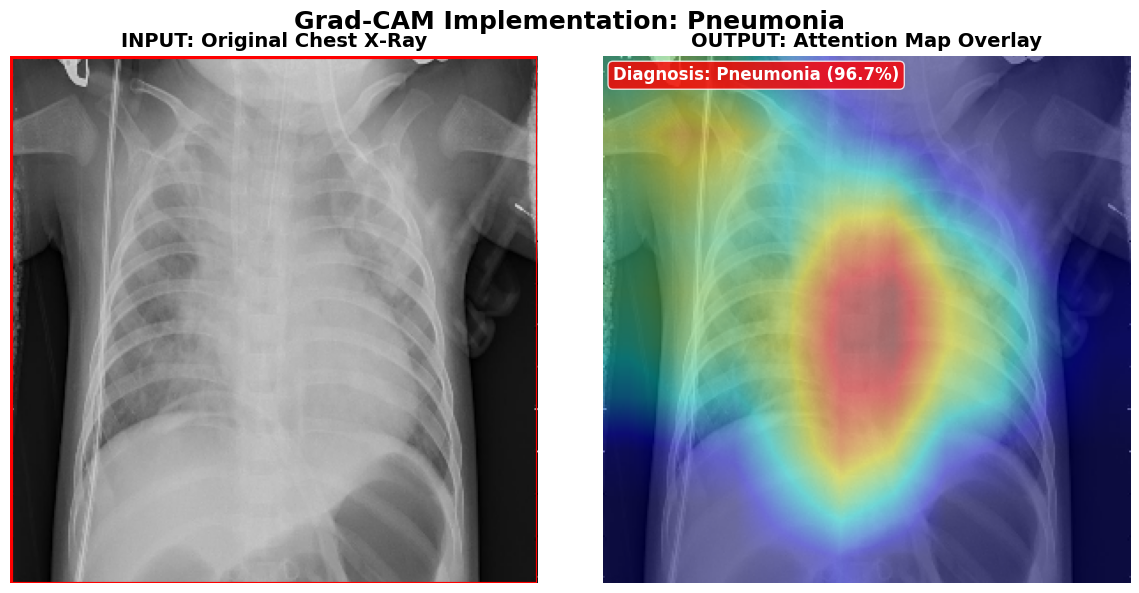

Attempt 1: BACTERIA-9857270-0002.jpeg | Pneumonia (96.7%) | raw score =0.9670
Pneumonia-positive image successfully visualized.


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import random
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

class PneumoniaGradCAM:
    """
    Grad-CAM implementation for visualizing pneumonia detection in chest X-rays.
    """
    def __init__(self, model_path):
        self.model = load_model(model_path)
        self.target_size = (299, 299)
        self.last_conv_layer = self._find_target_layer()
        self.grad_model = Model(
            inputs=self.model.inputs,
            outputs=[
                self.model.get_layer(self.last_conv_layer).output,
                self.model.output
            ]
        )

    def _find_target_layer(self):
        for layer in reversed(self.model.layers):
            if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
                return layer.name
        return 'block14_sepconv2_act'

    def prepare_image(self, img_path):
        # Load & preprocess with Xception settings
        img = image.load_img(img_path, target_size=self.target_size)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, 0)
        arr = preprocess_input(arr)
        # Original RGB for display
        orig = cv2.imread(img_path)
        orig = cv2.resize(orig, self.target_size)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        return arr, orig

    def compute_heatmap(self, img_array, class_idx=1):
        with tf.GradientTape() as tape:
            conv_out, preds = self.grad_model(img_array)
            score = preds[:, class_idx]  # Use pneumonia class index
        grads = tape.gradient(score, conv_out)
        pooled = tf.reduce_mean(grads, axis=(0,1,2))
        conv = conv_out[0]
        heatmap = conv @ pooled[..., tf.newaxis]
        heatmap = tf.squeeze(tf.maximum(heatmap, 0))
        heatmap = cv2.resize(heatmap.numpy(), self.target_size)
        if np.max(heatmap) > 0:
            heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
        return heatmap

    def create_overlay(self, orig, heatmap, alpha=0.4):
        hm_col = cv2.applyColorMap((heatmap*255).astype('uint8'),
                                  cv2.COLORMAP_JET)
        hm_col = cv2.cvtColor(hm_col, cv2.COLOR_BGR2RGB)
        overlay = hm_col * alpha + orig * (1 - alpha)
        return overlay.astype('uint8')

    def analyze_xray(self, img_path):
        arr, orig = self.prepare_image(img_path)
        predictions = self.model.predict(arr, verbose=0)[0]

        # Get pneumonia probability (class index 1)
        pneumonia_prob = predictions[1]
        normal_prob = predictions[0]

        label = "Pneumonia" if pneumonia_prob > 0.5 else "Normal"
        confidence = pneumonia_prob * 100 if label == "Pneumonia" else normal_prob * 100

        # Always use pneumonia class for heatmap since we're analyzing pneumonia images
        heatmap = self.compute_heatmap(arr, class_idx=1)
        overlay = self.create_overlay(orig, heatmap)

        # Visualization setup - now with only 2 plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Grad-CAM Implementation: {label}',
                     fontsize=18, fontweight='bold', y=0.98)

        # Original + border
        axes[0].imshow(orig, cmap='gray')
        border_color = 'red' if label == "Pneumonia" else 'green'
        axes[0].add_patch(Rectangle((0, 0), 299, 299,
                                   fill=False, edgecolor=border_color, linewidth=3))
        axes[0].set_title('INPUT: Original Chest X‑Ray', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        # Overlay + info box (with white text)
        axes[1].imshow(overlay)
        axes[1].set_title(f'OUTPUT: Attention Map Overlay', fontsize=14, fontweight='bold')

        # Add combined diagnosis and confidence information in one line
        diagnosis_text = f"Diagnosis: {label} ({confidence:.1f}%)"
        info_color = 'red' if label == "Pneumonia" else 'green'

        axes[1].text(0.02, 0.98, diagnosis_text,
                     transform=axes[1].transAxes, fontsize=12, fontweight='bold',
                     verticalalignment='top', color='white',
                     bbox=dict(boxstyle='round', facecolor=info_color,
                               alpha=0.8, edgecolor='white'))
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        return label, confidence, pneumonia_prob

def run_pneumonia_analysis(max_attempts=20):
    MODEL_PATH = '/content/drive/MyDrive/chest_xray/base_model_3.keras'
    PNEUMONIA_DIR = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'

    gradcam = PneumoniaGradCAM(MODEL_PATH)
    imgs = glob.glob(os.path.join(PNEUMONIA_DIR, '*.jpeg'))
    if not imgs:
        # Try different extensions
        imgs = glob.glob(os.path.join(PNEUMONIA_DIR, '*.jpg'))
        if not imgs:
            raise FileNotFoundError("No JPEG images found in pneumonia directory.")

    print(f"Found {len(imgs)} pneumonia images")

    random.seed(123) # Set seed here

    pneumonia_found = False
    for i in range(1, max_attempts + 1):
        img = random.choice(imgs)
        label, conf, raw = gradcam.analyze_xray(img)
        print(f"Attempt {i}: {os.path.basename(img)} | {label} ({conf:.1f}%) | raw score ={raw:.4f}")

        if label == "Pneumonia":
            print("Pneumonia-positive image successfully visualized.")
            pneumonia_found = True
            break

    if not pneumonia_found:
        print(f"\nWARNING: No pneumonia-positive predictions in {max_attempts} attempts")
        print("Possible issues:")
        print("1. Model might be misclassifying pneumonia images")
        print("2. Model performance might be poor on this dataset")
        print("3. Preprocessing might not match training configuration")

        # Debug: Check the first 5 images' predictions
        print("\nDebug info for first 5 pneumonia images:")
        for i, img in enumerate(imgs[:5]):
            arr, _ = gradcam.prepare_image(img)
            predictions = gradcam.model.predict(arr, verbose=0)[0]
            print(f"{i+1}. {os.path.basename(img)}: Normal={predictions[0]:.4f}, Pneumonia={predictions[1]:.4f}")

if __name__ == "__main__":
    run_pneumonia_analysis()

---------

# **Optimising Grad-CAM for Low Resource Use**

--------

#### **Pneumonia Grad-CAM Optimised**

------------------------------------------------------------
System Hardware Specifications
------------------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB

Original TensorFlow thread configuration:
- Intra-op threads: 0 (default)
- Inter-op threads: 0 (default)

Configuring environment to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5 GHz clock behavior

Original CPU clock speed: 2.20 GHz
Target Raspberry Pi clock speed: 1.50 GHz
Clock speed adjustment factor: 1.47x
------------------------------------------------------------
Xception model file size: 82.06 MB
------------------------------------------------------------

Selected sample size: 50
10/50
20/50
30/50
40/50
50/50


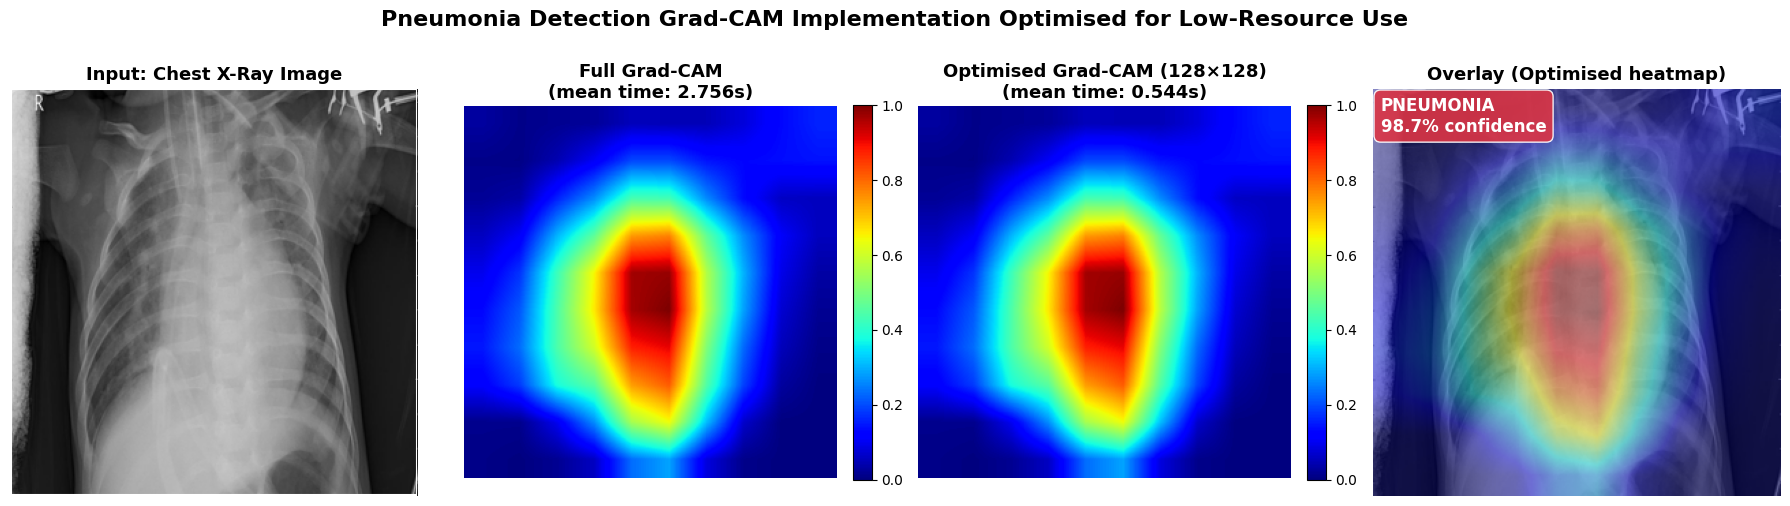


=== GRAD-CAM BENCHMARK SUMMARY ===
Number of images tested: 50
Full Grad-CAM: 2.756 ± 0.630 s
Optimised Grad-CAM (128×128): 0.544 ± 0.144 s
Speedup (full / optimised): 5.06x
Explanation fidelity: mean correlation = 0.960, mean IoU@0.5 = 0.960
Representative index shown: 11 ->>> (label: PNEUMONIA)


In [ ]:
# Xception Grad-CAM (stratified random sampling, compact batch prints, bolder titles)
import os
import glob
import time
import gc
import random
import psutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import warnings
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')

# Configuration
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, "test")
MODEL_PATH = '/content/drive/MyDrive/chest_xray/base_model_3.keras'
LABELS = ['NORMAL', 'PNEUMONIA']

TARGET_SIZE = (299, 299)
GRADCAM_SIZE = (128, 128)
PI_CORES = 4
PI_CPU_GHZ = 1.5
SEED = 42  # reproducible random sampling

# System hardware info & Pi simulation
cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)

print("-" * 60)
print("System Hardware Specifications")
print("-" * 60)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")

print("\nOriginal TensorFlow thread configuration:")
print(f"- Intra-op threads: {tf.config.threading.get_intra_op_parallelism_threads()} (default)")
print(f"- Inter-op threads: {tf.config.threading.get_inter_op_parallelism_threads()} (default)")

print("\nConfiguring environment to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ} GHz clock behavior")

os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

try:
    original_ghz = psutil.cpu_freq().current / 1000.0
    clock_factor = original_ghz / PI_CPU_GHZ
    print(f"\nOriginal CPU clock speed: {original_ghz:.2f} GHz")
    print(f"Target Raspberry Pi clock speed: {PI_CPU_GHZ:.2f} GHz")
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except Exception:
    original_ghz = None
    clock_factor = 1.47
    print("\nCould not detect CPU frequency - using default clock factor: 1.47x")

#  Utilities
def get_model_size(path):
    return os.path.getsize(path) / (1024 * 1024) if os.path.exists(path) else 0.0

def calculate_iou(map1, map2, threshold=0.5):
    b1 = (map1 >= threshold).astype(np.uint8)
    b2 = (map2 >= threshold).astype(np.uint8)
    inter = np.logical_and(b1, b2).sum()
    union = np.logical_or(b1, b2).sum()
    return float(inter / union) if union != 0 else 0.0

def safe_pearsonr(m1, m2, eps=1e-8):
    a = m1.ravel().astype(np.float64)
    b = m2.ravel().astype(np.float64)
    if not (np.isfinite(a).all() and np.isfinite(b).all()):
        return 0.0
    if np.std(a) < eps or np.std(b) < eps:
        return 0.0
    return float(pearsonr(a, b)[0])

def ensure_probs(preds):
    arr = np.array(preds).ravel()
    if arr.size >= 2:
        if np.isclose(arr.sum(), 1.0, atol=1e-3):
            return arr.astype(np.float32)
        e = np.exp(arr - np.max(arr))
        return (e / e.sum()).astype(np.float32)
    val = float(arr[0])
    if val > 1.0 or val < 0.0:
        return 1.0 / (1.0 + np.exp(-val))
    return val

#  Grad-CAM helper
class XceptionGradCAM:
    def __init__(self, model_path, gradcam_size=GRADCAM_SIZE, target_size=TARGET_SIZE, clock_factor=clock_factor):
        self.model = load_model(model_path)
        self.gradcam_size = gradcam_size
        self.target_size = target_size
        self.clock_factor = clock_factor
        self.last_conv = self._find_last_conv_layer()
        self.grad_model = Model(inputs=self.model.inputs,
                                outputs=[self.model.get_layer(self.last_conv).output, self.model.output])
        out_shape = self.model.output_shape
        self.model_type = "softmax" if len(out_shape) == 2 and out_shape[1] == 2 else "sigmoid"
        self._compile_optimised_gradcam()

    def _find_last_conv_layer(self):
        for layer in reversed(self.model.layers):
            if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
                return layer.name
        raise ValueError("No suitable convolutional layer found")

    def _compile_optimised_gradcam(self):
        @tf.function
        def _gradcam_fn(input_tensor):
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                conv_out, preds = self.grad_model(input_tensor)
                if self.model_type == "softmax":
                    score = preds[:, 1]
                else:
                    score = preds[:, 0]
            grads = tape.gradient(score, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_out = conv_out[0]
            heat = tf.tensordot(conv_out, pooled, axes=[[2], [0]])
            heat = tf.nn.relu(heat)
            heat = tf.image.resize(heat[..., tf.newaxis], self.target_size)[..., 0]
            return heat, preds
        self._gradcam_fn = _gradcam_fn
        try:
            dummy = tf.zeros((1, *self.gradcam_size, 3), dtype=tf.float32)
            _ = self._gradcam_fn(dummy)
        except Exception:
            dummy = tf.zeros((1, *self.target_size, 3), dtype=tf.float32)
            _ = self._gradcam_fn(dummy)

    def prepare_image(self, path):
        img = Image.open(path).convert('RGB').resize(self.target_size)
        arr = np.array(img, dtype=np.float32)
        arr_pre = tf.keras.applications.xception.preprocess_input(np.expand_dims(arr, 0))
        return arr_pre.astype(np.float32), np.array(img, dtype=np.uint8)

    def generate_optimised(self, img_keras):
        img_small = tf.image.resize(img_keras, self.gradcam_size, method='bilinear')
        start = time.perf_counter()
        try:
            heat_tf, preds = self._gradcam_fn(img_small)
        except Exception:
            heat_tf, preds = self._gradcam_fn(img_keras)
        elapsed = (time.perf_counter() - start) * self.clock_factor
        heat = heat_tf.numpy()
        heat = (heat - heat.min()) / (heat.max() - heat.min()) if heat.max() > 0 else np.zeros_like(heat)
        return heat, preds[0], elapsed

    def generate_full(self, img_keras):
        inp = tf.convert_to_tensor(img_keras, dtype=tf.float32)
        start = time.perf_counter()
        with tf.GradientTape() as tape:
            tape.watch(inp)
            conv_out, preds = self.grad_model(inp)
            if self.model_type == "softmax":
                score = preds[:, 1]
            else:
                score = preds[:, 0]
        grads = tape.gradient(score, conv_out)
        pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_out = conv_out[0]
        heat = tf.tensordot(conv_out, pooled, axes=[[2], [0]])
        heat = tf.nn.relu(heat)
        heat = tf.image.resize(heat[..., tf.newaxis], self.target_size)[..., 0]
        elapsed = (time.perf_counter() - start) * self.clock_factor
        heat = heat.numpy()
        heat = (heat - heat.min()) / (heat.max() - heat.min()) if heat.max() > 0 else np.zeros_like(heat)
        return heat, preds[0], elapsed

    def overlay(self, orig_img, heatmap, alpha=0.4):
        gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
        gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        heat_col = cv2.applyColorMap((heatmap * 255).astype('uint8'), cv2.COLORMAP_JET)
        heat_col = cv2.cvtColor(heat_col, cv2.COLOR_BGR2RGB)
        return cv2.addWeighted(heat_col, alpha, gray_rgb, 1 - alpha, 0)

# Selection: stratified random sample (keeps classes represented)
def select_sample(test_dir, n_images=50, seed=SEED):
    rng = random.Random(seed)
    per_class = max(1, n_images // len(LABELS))
    selected = []
    for label in LABELS:
        folder = os.path.join(test_dir, label)
        files = sorted(glob.glob(os.path.join(folder, '*.jpeg')) +
                       glob.glob(os.path.join(folder, '*.jpg')) +
                       glob.glob(os.path.join(folder, '*.png')))
        if not files:
            continue
        rng.shuffle(files)
        picked = files[:per_class]
        selected.extend([(p, label) for p in picked])
    # fill remaining if needed
    all_files = []
    for label in LABELS:
        folder = os.path.join(test_dir, label)
        all_files.extend(sorted(glob.glob(os.path.join(folder, '*.jpeg')) +
                                glob.glob(os.path.join(folder, '*.jpg')) +
                                glob.glob(os.path.join(folder, '*.png'))))
    remaining = [f for f in all_files if f not in [s[0] for s in selected]]
    rng.shuffle(remaining)
    while len(selected) < n_images and remaining:
        selected.append((remaining.pop(), LABELS[0]))
    rng.shuffle(selected)
    return selected[:n_images]

# Measurement + visualisation
def measure_and_show(model_path, test_dir, n_images=50, rep_index=11):
    gc.collect()
    gradcam = XceptionGradCAM(model_path)
    sample = select_sample(test_dir, n_images=n_images, seed=SEED)

    if not sample:
        raise RuntimeError("No images found")

    # Print compact batch markers
    print("\nSelected sample size:", len(sample))
    batch_step = 10
    for x in range(batch_step, len(sample)+1, batch_step):
        print(f"{x}/{len(sample)}")
    if len(sample) % batch_step != 0:
        print(f"{len(sample)}/{len(sample)}")

    # warm-up
    img_k, _ = gradcam.prepare_image(sample[0][0])
    _ = gradcam.generate_optimised(img_k)
    _ = gradcam.generate_full(img_k)

    full_times, opt_times, fidelity = [], [], []
    for i, (path, lbl) in enumerate(sample):
        img_k, img_disp = gradcam.prepare_image(path)
        heat_full, preds_full, t_full = gradcam.generate_full(img_k)
        heat_opt, preds_opt, t_opt = gradcam.generate_optimised(img_k)

        full_times.append(t_full); opt_times.append(t_opt)
        corr = safe_pearsonr(heat_full, heat_opt)
        iou = calculate_iou(heat_full, heat_opt, threshold=0.5)
        fidelity.append({'correlation': corr, 'iou': iou})

    full_mean, full_std = float(np.mean(full_times)), float(np.std(full_times))
    opt_mean, opt_std = float(np.mean(opt_times)), float(np.std(opt_times))
    speedup = full_mean / opt_mean if opt_mean > 0 else float('inf')
    mean_corr = float(np.mean([m['correlation'] for m in fidelity]))
    mean_iou = float(np.mean([m['iou'] for m in fidelity]))

    # representative
    rep_idx = min(max(int(rep_index), 0), len(sample)-1)
    rep_path, rep_label = sample[rep_idx]
    img_k, img_disp = gradcam.prepare_image(rep_path)
    h_full, p_full, t_full = gradcam.generate_full(img_k)
    h_opt, p_opt, t_opt = gradcam.generate_optimised(img_k)

    probs = ensure_probs(p_full)
    if isinstance(probs, np.ndarray) and probs.size >= 2:
        normal_p, pneumonia_p = float(probs[0]), float(probs[1])
    else:
        pneumonia_p = float(probs); normal_p = 1.0 - pneumonia_p
    diagnosis = "PNEUMONIA" if pneumonia_p > 0.5 else "NORMAL"
    confidence = (pneumonia_p if diagnosis == "PNEUMONIA" else normal_p) * 100.0
    overlay_img = gradcam.overlay(img_disp, h_opt)

    # plot with bolder, slightly larger titles
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle("Pneumonia Detection Grad-CAM Implementation Optimised for Low-Resource Use",
                 fontsize=16, fontweight='bold', y=1.03)

    axes[0].imshow(img_disp)
    axes[0].set_title("Input: Chest X-Ray Image", fontsize=13, fontweight='bold')
    axes[0].axis('off')
    axes[0].add_patch(Rectangle((0, 0), gradcam.target_size[0]-1, gradcam.target_size[1]-1,
                               fill=False, edgecolor='white', linewidth=1.5))

    im1 = axes[1].imshow(h_full, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title(f"Full Grad-CAM\n(mean time: {full_mean:.3f}s)", fontsize=13, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(h_opt, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title(f"Optimised Grad-CAM ({gradcam.gradcam_size[0]}×{gradcam.gradcam_size[1]})\n(mean time: {opt_mean:.3f}s)",
                      fontsize=13, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    axes[3].imshow(overlay_img)
    axes[3].set_title("Overlay (Optimised heatmap)", fontsize=13, fontweight='bold')
    axes[3].axis('off')
    diag_color = '#dc3545' if diagnosis == "PNEUMONIA" else '#28a745'
    axes[3].text(0.02, 0.98, f'{diagnosis}\n{confidence:.1f}% confidence', transform=axes[3].transAxes,
                 fontsize=12, fontweight='bold', verticalalignment='top', color='white',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor=diag_color, alpha=0.9, edgecolor='white'))

    plt.tight_layout()
    plt.show()

    # concise summary
    print("\n=== GRAD-CAM BENCHMARK SUMMARY ===")
    print(f"Number of images tested: {len(sample)}")
    print(f"Full Grad-CAM: {full_mean:.3f} ± {full_std:.3f} s")
    print(f"Optimised Grad-CAM ({gradcam.gradcam_size[0]}×{gradcam.gradcam_size[1]}): {opt_mean:.3f} ± {opt_std:.3f} s")
    print(f"Speedup (full / optimised): {speedup:.2f}x")
    print(f"Explanation fidelity: mean correlation = {mean_corr:.3f}, mean IoU@0.5 = {mean_iou:.3f}")
    print(f"Representative index shown: {rep_idx} ->>> (label: {rep_label})")

    return {
        'n_images': len(sample),
        'full_mean_s': full_mean,
        'full_std_s': full_std,
        'opt_mean_s': opt_mean,
        'opt_std_s': opt_std,
        'speedup': speedup,
        'mean_correlation': mean_corr,
        'mean_iou': mean_iou,
        'rep_index': rep_idx,
        'rep_path': rep_path,
        'rep_label': rep_label,
        'rep_confidence': confidence
    }

# -------- Run --------
if __name__ == "__main__":
    print("-" * 60)
    print(f"Xception model file size: {get_model_size(MODEL_PATH):.2f} MB")
    print("-" * 60)

    # Change this value to visualise another image from the sampled set:
    rep_index = 11  #  set any index between 0 and n_images-1

    metrics = measure_and_show(MODEL_PATH, TEST_PATH, n_images=50, rep_index=rep_index)

#### **Normal Grad-CAM Optimised**

------------------------------------------------------------
System Hardware Specifications
------------------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB

Original TensorFlow thread configuration:
- Intra-op threads: 0 (default)
- Inter-op threads: 0 (default)

Configuring environment to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5 GHz clock behavior

Original CPU clock speed: 2.20 GHz
Target Raspberry Pi clock speed: 1.50 GHz
Clock speed adjustment factor: 1.47x
------------------------------------------------------------
Xception model file size: 82.06 MB
------------------------------------------------------------

Selected sample size: 50
10/50
20/50
30/50
40/50
50/50


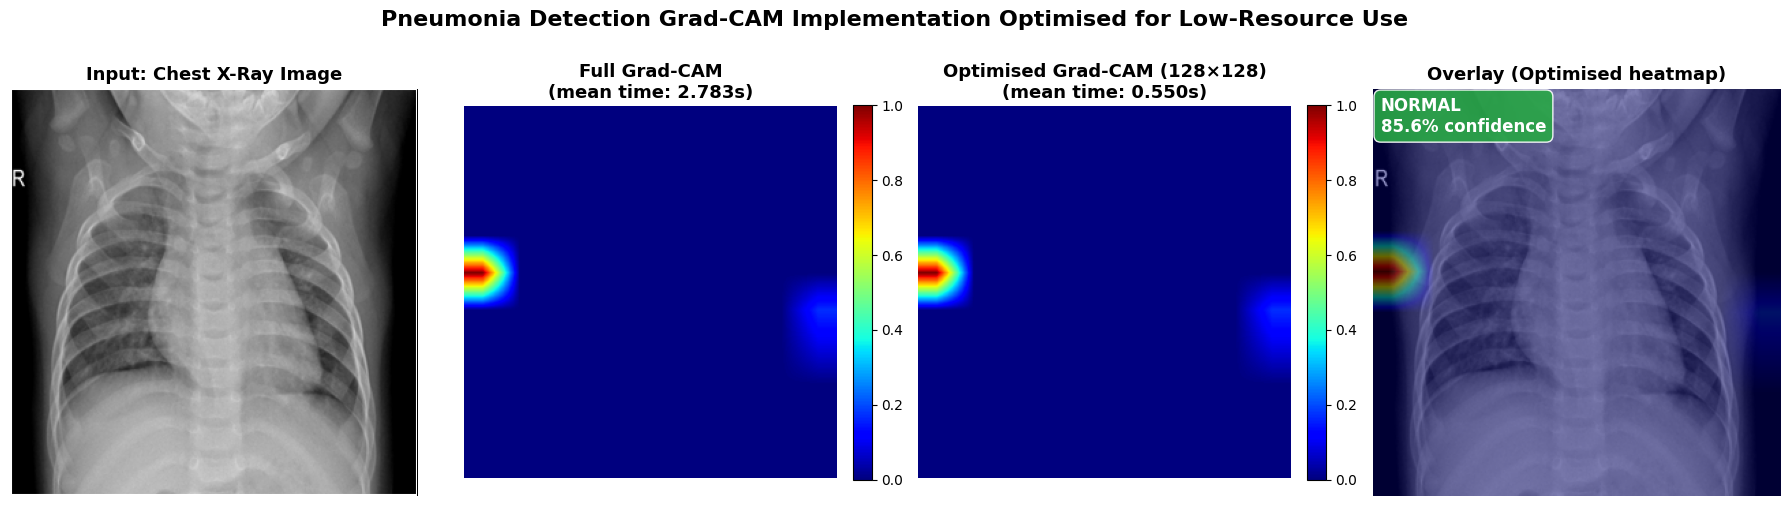


=== GRAD-CAM BENCHMARK SUMMARY ===
Number of images tested: 50
Full Grad-CAM: 2.783 ± 0.598 s
Optimised Grad-CAM (128×128): 0.550 ± 0.143 s
Speedup (full / optimised): 5.06x
Explanation fidelity: mean correlation = 0.960, mean IoU@0.5 = 0.960
Representative index shown: 3 ->>> (label: NORMAL)


In [ ]:
# Xception Grad-CAM (stratified random sampling, compact batch prints, bolder titles)
import os
import glob
import time
import gc
import random
import psutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import warnings
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')

# Configuration
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, "test")
MODEL_PATH = '/content/drive/MyDrive/chest_xray/base_model_3.keras'
LABELS = ['NORMAL', 'PNEUMONIA']

TARGET_SIZE = (299, 299)
GRADCAM_SIZE = (128, 128)
PI_CORES = 4
PI_CPU_GHZ = 1.5
SEED = 42  # reproducible random sampling

# System hardware info & Pi simulation
cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)

print("-" * 60)
print("System Hardware Specifications")
print("-" * 60)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")

print("\nOriginal TensorFlow thread configuration:")
print(f"- Intra-op threads: {tf.config.threading.get_intra_op_parallelism_threads()} (default)")
print(f"- Inter-op threads: {tf.config.threading.get_inter_op_parallelism_threads()} (default)")

print("\nConfiguring environment to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ} GHz clock behavior")

os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

try:
    original_ghz = psutil.cpu_freq().current / 1000.0
    clock_factor = original_ghz / PI_CPU_GHZ
    print(f"\nOriginal CPU clock speed: {original_ghz:.2f} GHz")
    print(f"Target Raspberry Pi clock speed: {PI_CPU_GHZ:.2f} GHz")
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except Exception:
    original_ghz = None
    clock_factor = 1.47
    print("\nCould not detect CPU frequency - using default clock factor: 1.47x")

# Utilities
def get_model_size(path):
    return os.path.getsize(path) / (1024 * 1024) if os.path.exists(path) else 0.0

def calculate_iou(map1, map2, threshold=0.5):
    b1 = (map1 >= threshold).astype(np.uint8)
    b2 = (map2 >= threshold).astype(np.uint8)
    inter = np.logical_and(b1, b2).sum()
    union = np.logical_or(b1, b2).sum()
    return float(inter / union) if union != 0 else 0.0

def safe_pearsonr(m1, m2, eps=1e-8):
    a = m1.ravel().astype(np.float64)
    b = m2.ravel().astype(np.float64)
    if not (np.isfinite(a).all() and np.isfinite(b).all()):
        return 0.0
    if np.std(a) < eps or np.std(b) < eps:
        return 0.0
    return float(pearsonr(a, b)[0])

def ensure_probs(preds):
    arr = np.array(preds).ravel()
    if arr.size >= 2:
        if np.isclose(arr.sum(), 1.0, atol=1e-3):
            return arr.astype(np.float32)
        e = np.exp(arr - np.max(arr))
        return (e / e.sum()).astype(np.float32)
    val = float(arr[0])
    if val > 1.0 or val < 0.0:
        return 1.0 / (1.0 + np.exp(-val))
    return val

#  Grad-CAM helper
class XceptionGradCAM:
    def __init__(self, model_path, gradcam_size=GRADCAM_SIZE, target_size=TARGET_SIZE, clock_factor=clock_factor):
        self.model = load_model(model_path)
        self.gradcam_size = gradcam_size
        self.target_size = target_size
        self.clock_factor = clock_factor
        self.last_conv = self._find_last_conv_layer()
        self.grad_model = Model(inputs=self.model.inputs,
                                outputs=[self.model.get_layer(self.last_conv).output, self.model.output])
        out_shape = self.model.output_shape
        self.model_type = "softmax" if len(out_shape) == 2 and out_shape[1] == 2 else "sigmoid"
        self._compile_optimised_gradcam()

    def _find_last_conv_layer(self):
        for layer in reversed(self.model.layers):
            if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
                return layer.name
        raise ValueError("No suitable convolutional layer found")

    def _compile_optimised_gradcam(self):
        @tf.function
        def _gradcam_fn(input_tensor):
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                conv_out, preds = self.grad_model(input_tensor)
                if self.model_type == "softmax":
                    score = preds[:, 1]
                else:
                    score = preds[:, 0]
            grads = tape.gradient(score, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_out = conv_out[0]
            heat = tf.tensordot(conv_out, pooled, axes=[[2], [0]])
            heat = tf.nn.relu(heat)
            heat = tf.image.resize(heat[..., tf.newaxis], self.target_size)[..., 0]
            return heat, preds
        self._gradcam_fn = _gradcam_fn
        try:
            dummy = tf.zeros((1, *self.gradcam_size, 3), dtype=tf.float32)
            _ = self._gradcam_fn(dummy)
        except Exception:
            dummy = tf.zeros((1, *self.target_size, 3), dtype=tf.float32)
            _ = self._gradcam_fn(dummy)

    def prepare_image(self, path):
        img = Image.open(path).convert('RGB').resize(self.target_size)
        arr = np.array(img, dtype=np.float32)
        arr_pre = tf.keras.applications.xception.preprocess_input(np.expand_dims(arr, 0))
        return arr_pre.astype(np.float32), np.array(img, dtype=np.uint8)

    def generate_optimised(self, img_keras):
        img_small = tf.image.resize(img_keras, self.gradcam_size, method='bilinear')
        start = time.perf_counter()
        try:
            heat_tf, preds = self._gradcam_fn(img_small)
        except Exception:
            heat_tf, preds = self._gradcam_fn(img_keras)
        elapsed = (time.perf_counter() - start) * self.clock_factor
        heat = heat_tf.numpy()
        heat = (heat - heat.min()) / (heat.max() - heat.min()) if heat.max() > 0 else np.zeros_like(heat)
        return heat, preds[0], elapsed

    def generate_full(self, img_keras):
        inp = tf.convert_to_tensor(img_keras, dtype=tf.float32)
        start = time.perf_counter()
        with tf.GradientTape() as tape:
            tape.watch(inp)
            conv_out, preds = self.grad_model(inp)
            if self.model_type == "softmax":
                score = preds[:, 1]
            else:
                score = preds[:, 0]
        grads = tape.gradient(score, conv_out)
        pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_out = conv_out[0]
        heat = tf.tensordot(conv_out, pooled, axes=[[2], [0]])
        heat = tf.nn.relu(heat)
        heat = tf.image.resize(heat[..., tf.newaxis], self.target_size)[..., 0]
        elapsed = (time.perf_counter() - start) * self.clock_factor
        heat = heat.numpy()
        heat = (heat - heat.min()) / (heat.max() - heat.min()) if heat.max() > 0 else np.zeros_like(heat)
        return heat, preds[0], elapsed

    def overlay(self, orig_img, heatmap, alpha=0.4):
        gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
        gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        heat_col = cv2.applyColorMap((heatmap * 255).astype('uint8'), cv2.COLORMAP_JET)
        heat_col = cv2.cvtColor(heat_col, cv2.COLOR_BGR2RGB)
        return cv2.addWeighted(heat_col, alpha, gray_rgb, 1 - alpha, 0)

# Selection: stratified random sample (keeps classes represented)
def select_sample(test_dir, n_images=50, seed=SEED):
    rng = random.Random(seed)
    per_class = max(1, n_images // len(LABELS))
    selected = []
    for label in LABELS:
        folder = os.path.join(test_dir, label)
        files = sorted(glob.glob(os.path.join(folder, '*.jpeg')) +
                       glob.glob(os.path.join(folder, '*.jpg')) +
                       glob.glob(os.path.join(folder, '*.png')))
        if not files:
            continue
        rng.shuffle(files)
        picked = files[:per_class]
        selected.extend([(p, label) for p in picked])
    # fill remaining if needed
    all_files = []
    for label in LABELS:
        folder = os.path.join(test_dir, label)
        all_files.extend(sorted(glob.glob(os.path.join(folder, '*.jpeg')) +
                                glob.glob(os.path.join(folder, '*.jpg')) +
                                glob.glob(os.path.join(folder, '*.png'))))
    remaining = [f for f in all_files if f not in [s[0] for s in selected]]
    rng.shuffle(remaining)
    while len(selected) < n_images and remaining:
        selected.append((remaining.pop(), LABELS[0]))
    rng.shuffle(selected)
    return selected[:n_images]

# Measurement + visualisation
def measure_and_show(model_path, test_dir, n_images=50, rep_index=11):
    gc.collect()
    gradcam = XceptionGradCAM(model_path)
    sample = select_sample(test_dir, n_images=n_images, seed=SEED)

    if not sample:
        raise RuntimeError("No images found")

    # Print compact batch markers
    print("\nSelected sample size:", len(sample))
    batch_step = 10
    for x in range(batch_step, len(sample)+1, batch_step):
        print(f"{x}/{len(sample)}")
    if len(sample) % batch_step != 0:
        print(f"{len(sample)}/{len(sample)}")

    # warm-up
    img_k, _ = gradcam.prepare_image(sample[0][0])
    _ = gradcam.generate_optimised(img_k)
    _ = gradcam.generate_full(img_k)

    full_times, opt_times, fidelity = [], [], []
    for i, (path, lbl) in enumerate(sample):
        img_k, img_disp = gradcam.prepare_image(path)
        heat_full, preds_full, t_full = gradcam.generate_full(img_k)
        heat_opt, preds_opt, t_opt = gradcam.generate_optimised(img_k)

        full_times.append(t_full); opt_times.append(t_opt)
        corr = safe_pearsonr(heat_full, heat_opt)
        iou = calculate_iou(heat_full, heat_opt, threshold=0.5)
        fidelity.append({'correlation': corr, 'iou': iou})

    full_mean, full_std = float(np.mean(full_times)), float(np.std(full_times))
    opt_mean, opt_std = float(np.mean(opt_times)), float(np.std(opt_times))
    speedup = full_mean / opt_mean if opt_mean > 0 else float('inf')
    mean_corr = float(np.mean([m['correlation'] for m in fidelity]))
    mean_iou = float(np.mean([m['iou'] for m in fidelity]))

    # representative
    rep_idx = min(max(int(rep_index), 0), len(sample)-1)
    rep_path, rep_label = sample[rep_idx]
    img_k, img_disp = gradcam.prepare_image(rep_path)
    h_full, p_full, t_full = gradcam.generate_full(img_k)
    h_opt, p_opt, t_opt = gradcam.generate_optimised(img_k)

    probs = ensure_probs(p_full)
    if isinstance(probs, np.ndarray) and probs.size >= 2:
        normal_p, pneumonia_p = float(probs[0]), float(probs[1])
    else:
        pneumonia_p = float(probs); normal_p = 1.0 - pneumonia_p
    diagnosis = "PNEUMONIA" if pneumonia_p > 0.5 else "NORMAL"
    confidence = (pneumonia_p if diagnosis == "PNEUMONIA" else normal_p) * 100.0
    overlay_img = gradcam.overlay(img_disp, h_opt)

    # plot with bolder, slightly larger titles
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle("Pneumonia Detection Grad-CAM Implementation Optimised for Low-Resource Use",
                 fontsize=16, fontweight='bold', y=1.03)

    axes[0].imshow(img_disp)
    axes[0].set_title("Input: Chest X-Ray Image", fontsize=13, fontweight='bold')
    axes[0].axis('off')
    axes[0].add_patch(Rectangle((0, 0), gradcam.target_size[0]-1, gradcam.target_size[1]-1,
                               fill=False, edgecolor='white', linewidth=1.5))

    im1 = axes[1].imshow(h_full, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title(f"Full Grad-CAM\n(mean time: {full_mean:.3f}s)", fontsize=13, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(h_opt, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title(f"Optimised Grad-CAM ({gradcam.gradcam_size[0]}×{gradcam.gradcam_size[1]})\n(mean time: {opt_mean:.3f}s)",
                      fontsize=13, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    axes[3].imshow(overlay_img)
    axes[3].set_title("Overlay (Optimised heatmap)", fontsize=13, fontweight='bold')
    axes[3].axis('off')
    diag_color = '#dc3545' if diagnosis == "PNEUMONIA" else '#28a745'
    axes[3].text(0.02, 0.98, f'{diagnosis}\n{confidence:.1f}% confidence', transform=axes[3].transAxes,
                 fontsize=12, fontweight='bold', verticalalignment='top', color='white',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor=diag_color, alpha=0.9, edgecolor='white'))

    plt.tight_layout()
    plt.show()

    # concise summary
    print("\n=== GRAD-CAM BENCHMARK SUMMARY ===")
    print(f"Number of images tested: {len(sample)}")
    print(f"Full Grad-CAM: {full_mean:.3f} ± {full_std:.3f} s")
    print(f"Optimised Grad-CAM ({gradcam.gradcam_size[0]}×{gradcam.gradcam_size[1]}): {opt_mean:.3f} ± {opt_std:.3f} s")
    print(f"Speedup (full / optimised): {speedup:.2f}x")
    print(f"Explanation fidelity: mean correlation = {mean_corr:.3f}, mean IoU@0.5 = {mean_iou:.3f}")
    print(f"Representative index shown: {rep_idx} ->>> (label: {rep_label})")

    return {
        'n_images': len(sample),
        'full_mean_s': full_mean,
        'full_std_s': full_std,
        'opt_mean_s': opt_mean,
        'opt_std_s': opt_std,
        'speedup': speedup,
        'mean_correlation': mean_corr,
        'mean_iou': mean_iou,
        'rep_index': rep_idx,
        'rep_path': rep_path,
        'rep_label': rep_label,
        'rep_confidence': confidence
    }

# -------- Run --------
if __name__ == "__main__":
    print("-" * 60)
    print(f"Xception model file size: {get_model_size(MODEL_PATH):.2f} MB")
    print("-" * 60)

    # Change this value to visualise another image from the sampled set:
    rep_index = 23  #  set any index between 0 and n_images-1, 5, 6 all normal

    metrics = measure_and_show(MODEL_PATH, TEST_PATH, n_images=50, rep_index=rep_index)

#### **Experiments (Optional)**

------------------------------------------------------------
System Hardware Specifications
------------------------------------------------------------
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB

Original TensorFlow thread configuration:
- Intra-op threads: 0 (default)
- Inter-op threads: 0 (default)

Configuring environment to mimic Raspberry Pi 4:
- Limiting TensorFlow to use 4 threads
- Mimicking 1.5 GHz clock behavior

Original CPU clock speed: 2.20 GHz
Target Raspberry Pi clock speed: 1.50 GHz
Clock speed adjustment factor: 1.47x
------------------------------------------------------------
Xception model file size: 82.06 MB
------------------------------------------------------------

Selected index -> label -> filename (first 50 shown):
000 | PNEUMONIA | BACTERIA-6950003-0003.jpeg
001 | PNEUMONIA | VIRUS-7441806-0001.jpeg
002 | PNEUMONIA | VIRUS-5366974-0001.jpeg
003 | NORMAL    | NORMAL-745902-0001.jpeg
004 | NORMAL    | NORMAL-8418332-0001.jpeg
005 | NORMAL    | NORMAL-136

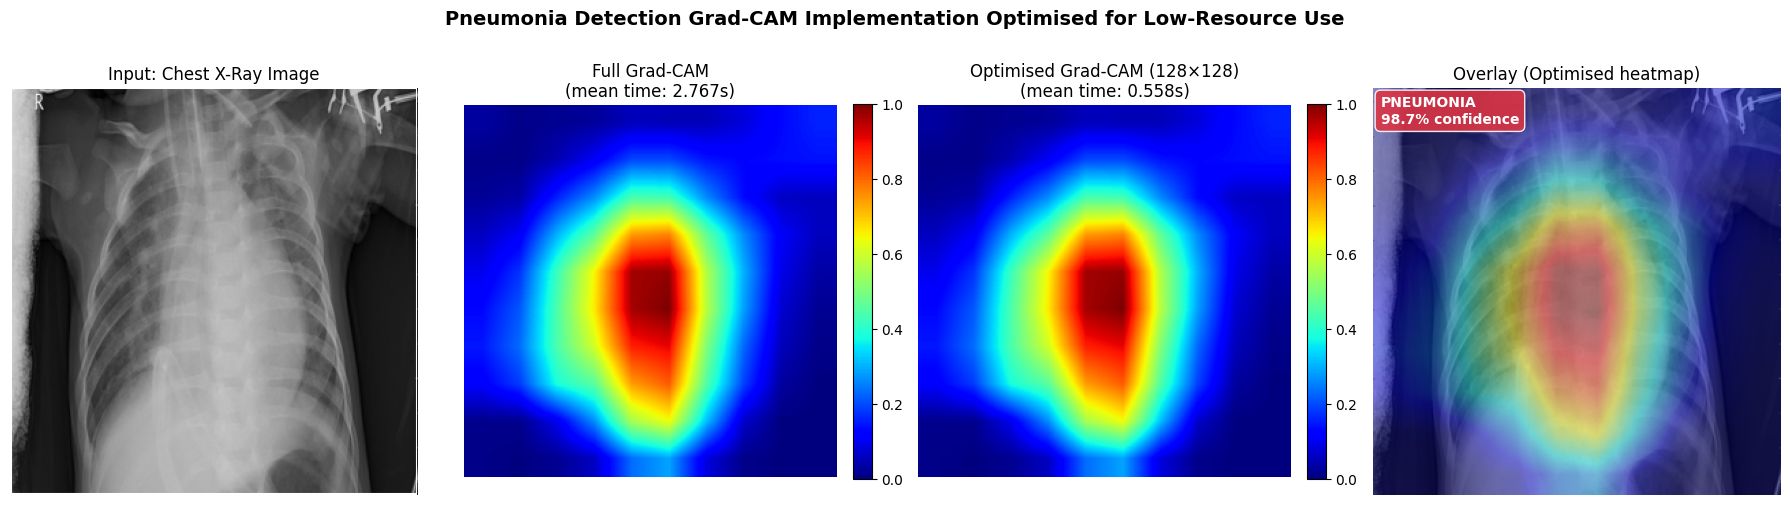


=== GRAD-CAM BENCHMARK SUMMARY ===
Number of images tested: 50
Full Grad-CAM: 2.767 ± 0.568 s
Optimised Grad-CAM (128×128): 0.558 ± 0.153 s
Speedup (full / optimised): 4.96x
Explanation fidelity: mean correlation = 0.960, mean IoU@0.5 = 0.960
Representative index shown: 11 -> BACTERIA-4059589-0003.jpeg (label: PNEUMONIA)


In [ ]:
# Xception Grad-CAM (random stratified sampling + real system info printed)
import os
import glob
import time
import gc
import random
import psutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import warnings
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')

#  Config
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, "test")
MODEL_PATH = '/content/drive/MyDrive/chest_xray/base_model_3.keras'
LABELS = ['NORMAL', 'PNEUMONIA']

TARGET_SIZE = (299, 299)
GRADCAM_SIZE = (128, 128)
PI_CORES = 4
PI_CPU_GHZ = 1.5
SEED = 42  # reproducible random sampling

# System hardware info & Pi simulation
cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)

print("-" * 60)
print("System Hardware Specifications")
print("-" * 60)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")

print("\nOriginal TensorFlow thread configuration:")
print(f"- Intra-op threads: {tf.config.threading.get_intra_op_parallelism_threads()} (default)")
print(f"- Inter-op threads: {tf.config.threading.get_inter_op_parallelism_threads()} (default)")

print("\nConfiguring environment to mimic Raspberry Pi 4:")
print(f"- Limiting TensorFlow to use {PI_CORES} threads")
print(f"- Mimicking {PI_CPU_GHZ} GHz clock behavior")

os.environ['TF_NUM_INTRAOP_THREADS'] = str(PI_CORES)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

try:
    original_ghz = psutil.cpu_freq().current / 1000.0
    clock_factor = original_ghz / PI_CPU_GHZ
    print(f"\nOriginal CPU clock speed: {original_ghz:.2f} GHz")
    print(f"Target Raspberry Pi clock speed: {PI_CPU_GHZ:.2f} GHz")
    print(f"Clock speed adjustment factor: {clock_factor:.2f}x")
except Exception:
    original_ghz = None
    clock_factor = 1.47
    print("\nCould not detect CPU frequency - using default clock factor: 1.47x")

#  Utilities
def get_model_size(path):
    return os.path.getsize(path) / (1024 * 1024) if os.path.exists(path) else 0.0

def calculate_iou(map1, map2, threshold=0.5):
    b1 = (map1 >= threshold).astype(np.uint8)
    b2 = (map2 >= threshold).astype(np.uint8)
    inter = np.logical_and(b1, b2).sum()
    union = np.logical_or(b1, b2).sum()
    return float(inter / union) if union != 0 else 0.0

def safe_pearsonr(m1, m2, eps=1e-8):
    a = m1.ravel().astype(np.float64)
    b = m2.ravel().astype(np.float64)
    if not (np.isfinite(a).all() and np.isfinite(b).all()):
        return 0.0
    if np.std(a) < eps or np.std(b) < eps:
        return 0.0
    return float(pearsonr(a, b)[0])

def ensure_probs(preds):
    arr = np.array(preds).ravel()
    if arr.size >= 2:
        if np.isclose(arr.sum(), 1.0, atol=1e-3):
            return arr.astype(np.float32)
        e = np.exp(arr - np.max(arr))
        return (e / e.sum()).astype(np.float32)
    val = float(arr[0])
    if val > 1.0 or val < 0.0:
        return 1.0 / (1.0 + np.exp(-val))
    return val

# Grad-CAM helper
class XceptionGradCAM:
    def __init__(self, model_path, gradcam_size=GRADCAM_SIZE, target_size=TARGET_SIZE, clock_factor=clock_factor):
        self.model = load_model(model_path)
        self.gradcam_size = gradcam_size
        self.target_size = target_size
        self.clock_factor = clock_factor
        self.last_conv = self._find_last_conv_layer()
        self.grad_model = Model(inputs=self.model.inputs,
                                outputs=[self.model.get_layer(self.last_conv).output, self.model.output])
        out_shape = self.model.output_shape
        self.model_type = "softmax" if len(out_shape) == 2 and out_shape[1] == 2 else "sigmoid"
        self._compile_optimised_gradcam()

    def _find_last_conv_layer(self):
        for layer in reversed(self.model.layers):
            if 'conv' in layer.name.lower() and len(layer.output.shape) == 4:
                return layer.name
        raise ValueError("No suitable convolutional layer found")

    def _compile_optimised_gradcam(self):
        @tf.function
        def _gradcam_fn(input_tensor):
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                conv_out, preds = self.grad_model(input_tensor)
                if self.model_type == "softmax":
                    score = preds[:, 1]
                else:
                    score = preds[:, 0]
            grads = tape.gradient(score, conv_out)
            pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_out = conv_out[0]
            heat = tf.tensordot(conv_out, pooled, axes=[[2], [0]])
            heat = tf.nn.relu(heat)
            heat = tf.image.resize(heat[..., tf.newaxis], self.target_size)[..., 0]
            return heat, preds
        self._gradcam_fn = _gradcam_fn
        try:
            dummy = tf.zeros((1, *self.gradcam_size, 3), dtype=tf.float32)
            _ = self._gradcam_fn(dummy)
        except Exception:
            dummy = tf.zeros((1, *self.target_size, 3), dtype=tf.float32)
            _ = self._gradcam_fn(dummy)

    def prepare_image(self, path):
        img = Image.open(path).convert('RGB').resize(self.target_size)
        arr = np.array(img, dtype=np.float32)
        arr_pre = tf.keras.applications.xception.preprocess_input(np.expand_dims(arr, 0))
        return arr_pre.astype(np.float32), np.array(img, dtype=np.uint8)

    def generate_optimised(self, img_keras):
        img_small = tf.image.resize(img_keras, self.gradcam_size, method='bilinear')
        start = time.perf_counter()
        try:
            heat_tf, preds = self._gradcam_fn(img_small)
        except Exception:
            heat_tf, preds = self._gradcam_fn(img_keras)
        elapsed = (time.perf_counter() - start) * self.clock_factor
        heat = heat_tf.numpy()
        heat = (heat - heat.min()) / (heat.max() - heat.min()) if heat.max() > 0 else np.zeros_like(heat)
        return heat, preds[0], elapsed

    def generate_full(self, img_keras):
        inp = tf.convert_to_tensor(img_keras, dtype=tf.float32)
        start = time.perf_counter()
        with tf.GradientTape() as tape:
            tape.watch(inp)
            conv_out, preds = self.grad_model(inp)
            if self.model_type == "softmax":
                score = preds[:, 1]
            else:
                score = preds[:, 0]
        grads = tape.gradient(score, conv_out)
        pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_out = conv_out[0]
        heat = tf.tensordot(conv_out, pooled, axes=[[2], [0]])
        heat = tf.nn.relu(heat)
        heat = tf.image.resize(heat[..., tf.newaxis], self.target_size)[..., 0]
        elapsed = (time.perf_counter() - start) * self.clock_factor
        heat = heat.numpy()
        heat = (heat - heat.min()) / (heat.max() - heat.min()) if heat.max() > 0 else np.zeros_like(heat)
        return heat, preds[0], elapsed

    def overlay(self, orig_img, heatmap, alpha=0.4):
        gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
        gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        heat_col = cv2.applyColorMap((heatmap * 255).astype('uint8'), cv2.COLORMAP_JET)
        heat_col = cv2.cvtColor(heat_col, cv2.COLOR_BGR2RGB)
        return cv2.addWeighted(heat_col, alpha, gray_rgb, 1 - alpha, 0)

#  Selection: stratified random sample
def select_sample(test_dir, n_images=50, seed=SEED):
    rng = random.Random(seed)
    per_class = max(1, n_images // len(LABELS))
    selected = []
    for label in LABELS:
        folder = os.path.join(test_dir, label)
        files = sorted(glob.glob(os.path.join(folder, '*.jpeg')) +
                       glob.glob(os.path.join(folder, '*.jpg')) +
                       glob.glob(os.path.join(folder, '*.png')))
        if not files:
            continue
        rng.shuffle(files)
        picked = files[:per_class]
        selected.extend([(p, label) for p in picked])
    # if not enough because n_images not divisible, add random picks from remaining
    all_files = []
    for label in LABELS:
        folder = os.path.join(test_dir, label)
        all_files.extend(sorted(glob.glob(os.path.join(folder, '*.jpeg')) +
                                glob.glob(os.path.join(folder, '*.jpg')) +
                                glob.glob(os.path.join(folder, '*.png'))))
    remaining = [f for f in all_files if f not in [s[0] for s in selected]]
    rng.shuffle(remaining)
    while len(selected) < n_images and remaining:
        selected.append((remaining.pop(), os.path.basename(os.path.dirname(selected[0][0]))))
    # final shuffle to mix classes
    rng.shuffle(selected)
    return selected[:n_images]

#  Measurement + visualisation
def measure_and_show(model_path, test_dir, n_images=50, rep_index=0):
    gc.collect()
    gradcam = XceptionGradCAM(model_path)
    sample = select_sample(test_dir, n_images=n_images, seed=SEED)

    if not sample:
        raise RuntimeError("No images found")

    # print index -> label -> filename for selected sample
    print("\nSelected index -> label -> filename (first 50 shown):")
    for i, (p, lbl) in enumerate(sample[:50]):
        print(f"{i:03d} | {lbl:9s} | {os.path.basename(p)}")

    # warm-up
    img_k, _ = gradcam.prepare_image(sample[0][0])
    _ = gradcam.generate_optimised(img_k)
    _ = gradcam.generate_full(img_k)

    full_times, opt_times, fidelity = [], [], []
    for i, (path, lbl) in enumerate(sample):
        img_k, img_disp = gradcam.prepare_image(path)
        heat_full, preds_full, t_full = gradcam.generate_full(img_k)
        heat_opt, preds_opt, t_opt = gradcam.generate_optimised(img_k)

        full_times.append(t_full); opt_times.append(t_opt)
        corr = safe_pearsonr(heat_full, heat_opt)
        iou = calculate_iou(heat_full, heat_opt, threshold=0.5)
        fidelity.append({'correlation': corr, 'iou': iou})

    full_mean, full_std = float(np.mean(full_times)), float(np.std(full_times))
    opt_mean, opt_std = float(np.mean(opt_times)), float(np.std(opt_times))
    speedup = full_mean / opt_mean if opt_mean > 0 else float('inf')
    mean_corr = float(np.mean([m['correlation'] for m in fidelity]))
    mean_iou = float(np.mean([m['iou'] for m in fidelity]))

    # representative
    rep_idx = min(max(int(rep_index), 0), len(sample)-1)
    rep_path, rep_label = sample[rep_idx]
    img_k, img_disp = gradcam.prepare_image(rep_path)
    h_full, p_full, t_full = gradcam.generate_full(img_k)
    h_opt, p_opt, t_opt = gradcam.generate_optimised(img_k)

    probs = ensure_probs(p_full)
    if isinstance(probs, np.ndarray) and probs.size >= 2:
        normal_p, pneumonia_p = float(probs[0]), float(probs[1])
    else:
        pneumonia_p = float(probs); normal_p = 1.0 - pneumonia_p
    diagnosis = "PNEUMONIA" if pneumonia_p > 0.5 else "NORMAL"
    confidence = (pneumonia_p if diagnosis == "PNEUMONIA" else normal_p) * 100.0
    overlay_img = gradcam.overlay(img_disp, h_opt)

    # plot
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle("Pneumonia Detection Grad-CAM Implementation Optimised for Low-Resource Use",
                 fontsize=14, fontweight='bold', y=1.03)

    axes[0].imshow(img_disp); axes[0].set_title("Input: Chest X-Ray Image"); axes[0].axis('off')
    axes[0].add_patch(Rectangle((0, 0), gradcam.target_size[0]-1, gradcam.target_size[1]-1,
                               fill=False, edgecolor='white', linewidth=1.5))

    im1 = axes[1].imshow(h_full, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title(f"Full Grad-CAM\n(mean time: {full_mean:.3f}s)"); axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(h_opt, cmap='jet', vmin=0, vmax=1)
    axes[2].set_title(f"Optimised Grad-CAM ({gradcam.gradcam_size[0]}×{gradcam.gradcam_size[1]})\n(mean time: {opt_mean:.3f}s)"); axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    axes[3].imshow(overlay_img); axes[3].set_title("Overlay (Optimised heatmap)"); axes[3].axis('off')
    diag_color = '#dc3545' if diagnosis == "PNEUMONIA" else '#28a745'
    axes[3].text(0.02, 0.98, f'{diagnosis}\n{confidence:.1f}% confidence', transform=axes[3].transAxes,
                 fontsize=10, fontweight='bold', verticalalignment='top', color='white',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor=diag_color, alpha=0.9, edgecolor='white'))

    plt.tight_layout()
    plt.show()

    # concise summary
    print("\n=== GRAD-CAM BENCHMARK SUMMARY ===")
    print(f"Number of images tested: {len(sample)}")
    print(f"Full Grad-CAM: {full_mean:.3f} ± {full_std:.3f} s")
    print(f"Optimised Grad-CAM ({gradcam.gradcam_size[0]}×{gradcam.gradcam_size[1]}): {opt_mean:.3f} ± {opt_std:.3f} s")
    print(f"Speedup (full / optimised): {speedup:.2f}x")
    print(f"Explanation fidelity: mean correlation = {mean_corr:.3f}, mean IoU@0.5 = {mean_iou:.3f}")
    print(f"Representative index shown: {rep_idx} -> {os.path.basename(rep_path)} (label: {rep_label})")

    return {
        'n_images': len(sample),
        'full_mean_s': full_mean,
        'full_std_s': full_std,
        'opt_mean_s': opt_mean,
        'opt_std_s': opt_std,
        'speedup': speedup,
        'mean_correlation': mean_corr,
        'mean_iou': mean_iou,
        'rep_index': rep_idx,
        'rep_path': rep_path,
        'rep_label': rep_label,
        'rep_confidence': confidence
    }

# -------- Run --------
if __name__ == "__main__":
    print("-" * 60)
    print(f"Xception model file size: {get_model_size(MODEL_PATH):.2f} MB")
    print("-" * 60)

    metrics = measure_and_show(MODEL_PATH, TEST_PATH, n_images=50, rep_index=11)

# **END OF PROJECT**